# Linear Regression
Regression is an approach to finding function $f(x)$, that models the conditional expectation of $Y$ given X:

$$
f(x) = E[Y|X=x]
$$

In linear regression, we assume that this function is globally linear (see [parent README.md](../README.md) for the meaning of this.).

In regression, minimizing the sum of square residuals by finding the the minimizing set of parameters is called the least squared solution,
and the regression function when viewed in a statistical sense is the solution to least squares.

For linear regression,there is an analytical solution derived from linear algebra:
$$
\hat{\vec{b}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T*\vec{y}
$$

Alternatively, when direct matrix inversion is computationally prohibitive (due to its cubic complexity in the number of features, O(p³)), iterative methods like (mini-)batch gradient descent are preferred (O(np) per iteration). This is where we estimate the gradient using the minibatch.

While the analytical solution, in its purest form, requires a global computation on the entire dataset, making it difficult to directly parallelize in the same way as gradient descent is and the tool ecosystem is very mature for optimizing in this way.

Assume here * refers to matrix multiplication, unless otherwise noted.


$$
Loss = (\vec{y} - \mathbf{X}\vec{b})^T(\vec{y} - \mathbf{X}\vec{b}) \\
\forall (\forall \mathbf{X}_{b} \in \mathbf{X}) \in N_{trainiter} \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M *\nabla_{\hat{\vec{b}}} Loss \\
\hat{\vec{b}} = \hat{\vec{b}} + \alpha * 1/M * 2\mathbf{X}_b^T*(\vec{y} - \mathbf{X}_b \hat{\vec{b}})
$$

## Assumptions:
* Can have additive error, $ y = f(x) + \epsilon $, and uncorrelated with x ( $\epsilon \perp X$) constant variance and usually $\epsilon  \sim N(0,\sigma^2)$. This helps for further statistical analysis.
* Globally linear f(x)

### Note:
This is expected to be run inside the `dev-client` service as specified in `./cluster/docker-compose.yml`. One way to do this after starting `docker-compose up -d --scale spark-worker=2 --build` in the `cluster` directory, use `Dev Containers` vscode extension to connect to the dev-client container and open the `/home/jovyan/workspace` folder where this file will be and run it there.

Be sure to run `docker-compose down` in the `./cluster/` to remove these resources after you are done.

## Example:
Lets generate some data using a linear model with additive error, and use both the gradient based and analytical model to see if we can get the original parameters.


In [1]:
import numpy as np

coefficients = np.array([0.1, 5]).T
bias = np.array([3])

noise = np.random.normal(0, 1, (1000))

input = np.random.uniform(-1.0, 1.0, (1000, 2))

output = noise + input @ coefficients + bias

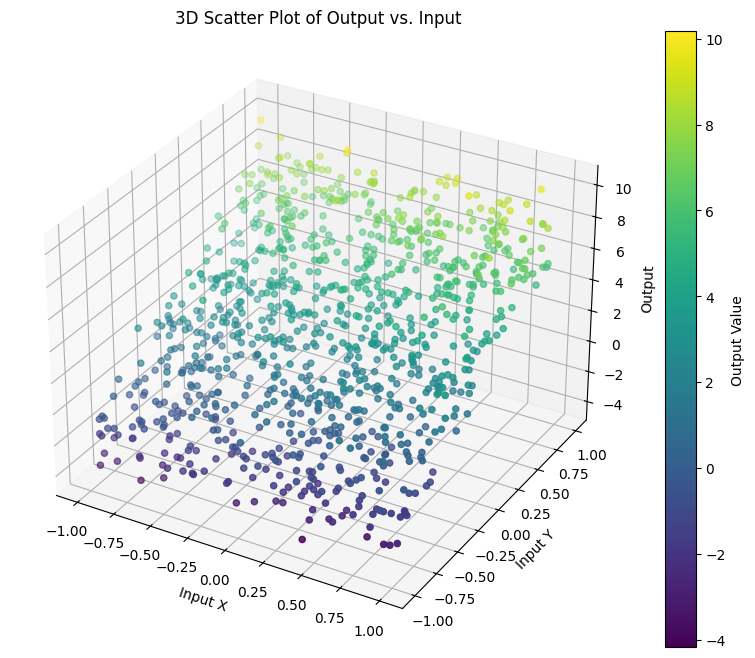

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(input[:, 0], input[:, 1], output, c=output, cmap='viridis', marker='o')
ax.set_xlabel("Input X")
ax.set_ylabel("Input Y")
ax.set_zlabel("Output")
ax.set_title("3D Scatter Plot of Output vs. Input")
fig.colorbar(scatter, label="Output Value")
plt.show()

In [3]:
# analytical approach:
inputWithBias = np.hstack([input, np.ones((input.shape[0], 1))])
def analyticalLinearRegression(inputWithBias, output, debug=True):
    coefficientsEstimateAnalytical = np.linalg.inv(inputWithBias.T @ inputWithBias) @ inputWithBias.T @ output
    mse = np.sum((output - inputWithBias @ coefficientsEstimateAnalytical) ** 2) / output.shape[0]
    if debug:
        print(f"mse: {mse}")
    return coefficientsEstimateAnalytical
coefficientsEstimateAnalytical = analyticalLinearRegression(inputWithBias, output)
print(f"Estimated coefficients: {coefficientsEstimateAnalytical[:-1]}, true coefficients: {coefficients}")
print(f"Estimated bias: {coefficientsEstimateAnalytical[-1]}, true bias: {bias}")

mse: 1.0080108159334398
Estimated coefficients: [0.07087927 5.03377999], true coefficients: [0.1 5. ]
Estimated bias: 2.972448978320677, true bias: [3]


In [4]:
# gradient based approach:
def gradientBasedLinearRegression(inputWithBias, output, debug=True):
    coefficientsEstimateGradient = np.random.normal(0, 1, (3))
    batchSize = 10
    learningRate = 0.01
    epochs = 10
    for epoch in range(epochs):
        for batch in range(inputWithBias.shape[0] // batchSize):
            batchInput = inputWithBias[batchSize * batch : batchSize * batch + batchSize]
            batchOutput = output[batchSize * batch : batchSize * batch + batchSize]
            coefficientsEstimateGradient += learningRate * 1 / batchInput.shape[0] * 2 * batchInput.T @ (batchOutput - batchInput @ coefficientsEstimateGradient)
        epochalMSE = np.sum((output - inputWithBias @ coefficientsEstimateGradient) ** 2) / output.shape[0]
        if debug==True:
            print(f"end epoch {epoch + 1}, mse: {epochalMSE}")
    return coefficientsEstimateGradient
coefficientsEstimateGradient = gradientBasedLinearRegression(inputWithBias, output)

end epoch 1, mse: 3.0083830984836384
end epoch 2, mse: 1.4878111435810288
end epoch 3, mse: 1.1381415035689642
end epoch 4, mse: 1.0435011040171998
end epoch 5, mse: 1.0176180355829523
end epoch 6, mse: 1.0105697785052241
end epoch 7, mse: 1.0086711859693787
end epoch 8, mse: 1.0081710147000584
end epoch 9, mse: 1.008045324682719
end epoch 10, mse: 1.0080170864386129


In [24]:
print(f"gradient coefficients + intercept: {coefficientsEstimateGradient}, and analytical{ coefficientsEstimateAnalytical}")

import statsmodels.formula.api as smf
import pandas as pd
df = pd.DataFrame(input, columns=['feature_1', 'feature_2'])
df['target_output'] = output
formula = 'target_output ~ feature_1 + feature_2'
model_formula = smf.ols(formula=formula, data=df)
results_formula = model_formula.fit()
print("\n--- Statsmodels OLS Results---")
print(results_formula.params)

gradient coefficients + intercept: [0.06969434 5.03003006 2.97142033], and analytical[0.07087927 5.03377999 2.97244898]

--- Statsmodels OLS Results---
Intercept    2.972449
feature_1    0.070879
feature_2    5.033780
dtype: float64


This shows they get to the same place.

## Goodness of fit
The goal of goodness-of-fit tests in linear regression is to assess how well the model's assumptions hold and whether the model adequately captures the relationship between the predictors and the response. This goes beyond just minimizing the loss function; it's about ensuring the validity of the model and its interpretations.

The fundamental approach is to use a model output ($\hat{\vec{y}}$) vs residual ($\hat{\vec{y}} - \vec{y}$) plot, this is expected to be a random scatter centered around 0.

If it's not (e.g., a curved pattern or a non-constant variance (not Homoscedasticity)) one can dig further to see which features are non linear by considering feature vs residual plot. 

One could then try to transform the feature/output to have a more linear relationship, or consider another model.


### For interpretability
It's important for interpretability and to make inferences about coefficients to look at and check for multi-colinearity and to look at and check for normality of errors.

#### Multi - collinearity
This violates one of the assumptions that each feature is independent from another $P(X_i | X_j) = P(X_i), \forall i, j$ where $i \neq j$.

Two approaches:

##### VIF
VIF is the Variance Inflation Factor (VIF). It is performing linear regression treating the feature for which you are finding the VIF for as dependent varaible to be predicted by all the other features, then computing $ 1 / (1 - R^2)$ for this model. $R^2$ is 1 - sum of square residuals / total sum of squares, it compares how off we are from predicting the feature over a baseline of just using the average, where 1 means the model is 0 error, than just predicting and 0 means the model explains none of the variance in the VIF feature; it's no better than simply predicting the mean, then The VIF is the reciprocal of (1 - R²), which quantifies how well the model could get on without the feature (since it could be linearly constructed from the others). R² larger is smallest error, so then 1 - R² flips this and reciprical flips it again and R² then larger is smaller error, which would mean that the feature is redundant.

We compute VIFs for each feature and A VIF > 5 (or 10, depending on the context) suggests problematic multicollinearity.

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

After you find features with VIFs, you can look at correlation matrix to find the variables that you can consider dropping then recheck for VIF values. You don't necessarily have to do this for just prediction usage but for interpretability of the coefficients. You could also combine them (average or otherwise), or even use regularization though the simple interpretability that came from the assumptions of independent factors is not valid anymore.

##### Correlation matrix
One could also directly examine the correlation matrix of the predictors. The correlation matrix is derived from covariance matrix, its the covariance matrix divided by the product of the standard deviations of the two variables in each pair- it normalizes the covariance so its always between -1 and 1, removing the scaling differences that would otherwise make covariance a good option to compare how features "move together" which is the condition of multi collinearity that we seek.

Pairwise correlation:
$\rho_{jk} = \frac{\sum_{i=1}^{n} (x_{ij} - \bar{x}_j)(x_{ik} - \bar{x}_k)}{\sigma_i * \sigma_j}$


Efficient Linear Algebra for correlation matrix:


$$
\vec{\bar{x}} = average(\mathbf{X}, dim=0).reshape(1, \mathbf{X}.shape[1]) \\
\mathbf{X_{demenaed}} = \mathbf{X} -\vec{\bar{x}} \\ 
Cov = (\mathbf{X_{demeaned}}^T*\mathbf{X_{demeaned}}) / (\mathbf{X}.shape[0] - 1) \\
StdDevInv = 1 / sqrt(diagnol(Cov)) \\
Correlation = Cov *_{element} StdDevInv.reshape(1,\mathbf{X}.shape[1]) *_{element} StdDevInv.reshape(\mathbf{X}.shape[1], 1)
$$

Here we make use of broadcasting, as Numpy implements it.

Look for high pairwise correlations (e.g., |r| > 0.8 or 0.9), remove those with very high.

#### Normality of errors
To see whether errors are normal, one could plot them with a histogram and see if it's the traditional bell shaped curve, centered around 0 or use normal Q-Q (Quantile - Quantile) plot, where you plot values in Y axis and the standard normal z score for the porportion of sample values below that (altered a bit to avoid infinity z scores) (inverse CDF of standard normal). A 45-degree reference line from 0 is often added and how well the plotted points lines up and where indicate how standard normal the residuals actually are, a straight line indicates a linear relationship though the standard deviation and mean are the slope and offset respectively.

Tests like the Shapiro-Wilk test or Anderson-Darling test provide a p-value to formally test the null hypothesis that the residuals are normally distributed. However, visual inspection with histograms and especially Q-Q plots is often preferred, particularly for understanding *how* the distribution deviates from normality if it does.

If they're not, may want to transform the response variable, for example taking a $log(Y)$ is most common or square root (particulary if its right skew which means mean is greater than median), if it's left skew you can do $1 - log(y)$.

Or consider generalized linear models (GLMs) which do not assume normal 0 centered noise.

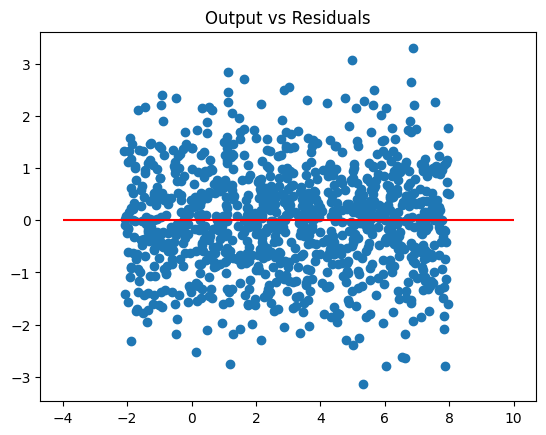

In [25]:
## goodness of fit
residuals = output - (inputWithBias @ coefficientsEstimateGradient)
plt.scatter((inputWithBias @ coefficientsEstimateGradient), residuals)
plt.hlines(0, -4, 10, colors="red")
plt.title("Output vs Residuals");

In [26]:
# looks pretty good, which it should, constant variance 0 noise was used to generate it
# for interpretability, lets do VIF
# VIF = 1 / (1 - R^2) for R^2 value of using other features used regress to feature we are getting VIF from
# R^2 = 1 - SSR / SST where SSR is sum(residuals^2) and SST is sum((y - mean(y))^2)
def VIF(featureIndex, modelInput):
    x = np.hstack([modelInput[:, :featureIndex], modelInput[:, featureIndex + 1:]])
    y = modelInput[:, featureIndex]
    xWithBias = np.hstack([x, np.ones((x.shape[0], 1))])
    coefficients = np.linalg.inv(xWithBias.T @ xWithBias) @ xWithBias.T @ y
    modelOutput = xWithBias @ coefficients
    ssr = np.sum((y - modelOutput)**2)
    residuals = y - modelOutput
    sst = np.sum((y - np.mean(y))**2)
    rSquared = 1 - ssr / sst
    return 1 / (1 - rSquared)

for i in range(input.shape[1]):
    print(f"VIF of index {i}: {VIF(i, input)}")

def correlationMatrix(modelInput):
    means = np.mean(modelInput, axis=0).reshape(1, modelInput.shape[1])
    demeanedX = modelInput - means
    covariance = (demeanedX.T @ demeanedX) / (modelInput.shape[0] - 1)
    standardDeviationInv = 1/ np.sqrt(np.diag(covariance))
    return covariance * standardDeviationInv.reshape(1, modelInput.shape[1]) * standardDeviationInv.reshape(1, modelInput.shape[1]) 

print("Correlation matrix:\n", correlationMatrix(input))

VIF of index 0: 1.0000551182766049
VIF of index 1: 1.000055118276605
Correlation matrix:
 [[1.         0.00760479]
 [0.00724744 1.        ]]


In [27]:
# looks like the VIFs indicate a low multi collinearity
# also correlation matrix is pretty much identity
# which is expected
# Using numpy's built-in function
corr_matrix_np = np.corrcoef(input, rowvar=False)
# 'rowvar=False' means columns are variables, rows are observations
print("Correlation matrix (using np.corrcoef):\n", corr_matrix_np)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant # To add the intercept term

X_with_const = add_constant(input)
print("VIFs from statsmodels:\n", [variance_inflation_factor(X_with_const, i + 1) for i in range(input.shape[1])])

## so we are on track, though the correlation coefficient was off, its in the 4th decimal place in a value that ranges from -1 to 1
# so we will chalk it up to rounding errors and exact procedure

Correlation matrix (using np.corrcoef):
 [[1.         0.00742396]
 [0.00742396 1.        ]]
VIFs from statsmodels:
 [np.float64(1.0000551182766049), np.float64(1.0000551182766049)]


## Validation
While goodness-of-fit diagnostics check how well the model fits the data it was trained on and whether assumptions are met, validation focuses on estimating how well the model will perform on new, unseen data. This is crucial for understanding the model's generalization ability and avoiding overfitting, where the model learns noise specific to the training set rather than the underlying relationship.

There are a couple common ways to do this:
1. **Simple test / train split**: One randomly partitions the dataset into a train and test dataset. The train dataset is used to estimate the coefficients of the model and then the test dataset is used to estimate the generalization error (like MSE, or square root of MSE).This is simple but an unlucky split could give you a pessimistic or optimistic estimate of the generalization error.
2. **K-fold cross validation**: One randomly partitions the dataset into K chunks, K - 1 are used to train the model while 1 is used to estimate the generalization error. This is done for each of the K partitions and the estimate of the generalization error is more robust to a random partition's data (since one could look at it's average as a point estimate and it's spread to understand the stability of the generalization error). It does take more to compute. 


In [28]:
# split train and test
splitIndex = int(len(input)*0.8)
trainX = input[:splitIndex]
trainY = output[:splitIndex]

testX = input[splitIndex:]
testY = output[splitIndex:]

# train on train
trainWithBias = np.hstack([trainX, np.ones((len(trainX), 1))])
print("training gradient:")
estimatedCoefficientsGradient = gradientBasedLinearRegression(trainWithBias, trainY)
print()
print("training analytical:")
estimatedCoefficientsAnalytical = analyticalLinearRegression(trainWithBias, trainY)
print()
# validate on test:
print("validating on test:")
testWithBias = np.hstack([testX, np.ones((len(testX), 1))])
print()
print("analytical mse:")
print(((testWithBias @ estimatedCoefficientsAnalytical - testY)**2).sum() / len(testX))
print()
print("gradient mse:")
print(((testWithBias @ estimatedCoefficientsGradient - testY)**2).sum() / len(testX))

training gradient:
end epoch 1, mse: 3.993233293920736
end epoch 2, mse: 1.997453526805441
end epoch 3, mse: 1.3609851641472313
end epoch 4, mse: 1.1391361204234216
end epoch 5, mse: 1.0612423067208199
end epoch 6, mse: 1.0339905380469283
end epoch 7, mse: 1.02452544256104
end epoch 8, mse: 1.0212786261401126
end epoch 9, mse: 1.0201891079462657
end epoch 10, mse: 1.0198382675538586

training analytical:
mse: 1.0187422603456489

validating on test:

analytical mse:
0.9696989556740536

gradient mse:
0.9796582851116323


analytical:
1.014330223812999
0.17329013709576627
gradient:
1.0148497839875685
0.1719969765360329


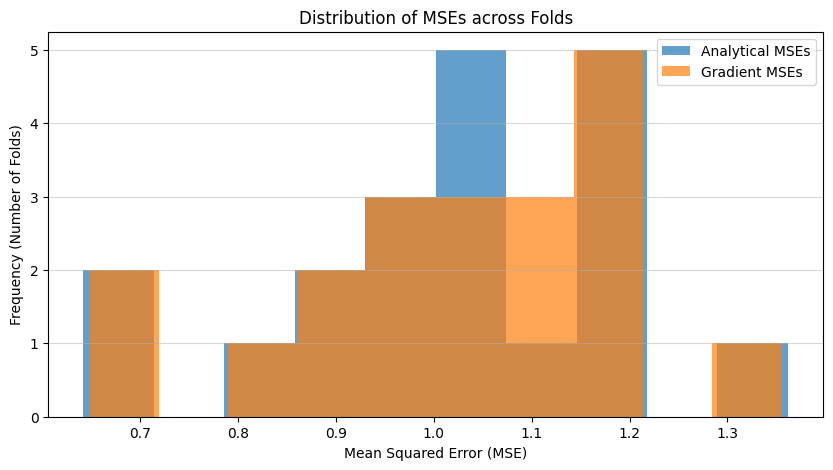

In [29]:
# k fold cross validation
# split everything
numFolds = 20
itemsPerFold =inputWithBias.shape[0] // numFolds
folds = []
targets = []
numIndices = inputWithBias.shape[0]

indices = np.random.permutation(numIndices)
outputMixed = output[indices]
inputWithBiasMixed = inputWithBias[indices]


folds = np.array_split(inputWithBiasMixed, numFolds)
targets = np.array_split(outputMixed, numFolds)
# for each do the process infer on the iterated fold
mses = []
for foldIndex, fold in enumerate(folds):
    trainX = np.vstack([folds[x] for x in range(len(folds)) if x != foldIndex])
    trainY = np.hstack([targets[x] for x in range(len(targets)) if x != foldIndex])

    testX = fold
    testY = targets[foldIndex]
    estimatedCoefficientsGradient = gradientBasedLinearRegression(trainX, trainY, debug=False)
    estimatedCoefficientsAnalytical = analyticalLinearRegression(trainX, trainY, debug=False)
    mse = (((testX @ estimatedCoefficientsAnalytical - testY)**2).sum() / len(testX), ((testX @ estimatedCoefficientsGradient - testY)**2).sum() / len(testX))
    mses.append(mse)
# average, capture spread, maybe distribution
plt.figure(figsize=(10, 5))
print("analytical:")
print(np.array([m[0] for m in mses]).mean())
print(np.array([m[0] for m in mses]).std())
plt.hist([m[0] for m in mses],  alpha=0.7, label='Analytical MSEs')

print("gradient:")
print(np.array([m[1] for m in mses]).mean())
print(np.array([m[1] for m in mses]).std())
plt.hist([m[1] for m in mses],  alpha=0.7, label='Gradient MSEs')
plt.title('Distribution of MSEs across Folds')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Frequency (Number of Folds)')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

plt.show()

# Model Complexity
Model complexity for linear regression can be controlled by both regularization and feature selection. Both of these reduce the variance (sensitivty to the training data) and introduce a bias.

## Regularization
Regularization introduces a penalty based on coefficient size. This penalty helps reduce model variance and improve generalization error, especially when dealing with multicollinearity or high-dimensional data. However, it makes direct interpretation of the coefficients harder because it introduces bias, shrinking them towards 0 compared to the OLS estimates.

Since the penalty is applied to the coefficient size, it's crucial to standardize features (e.g., subtract mean, divide by standard deviation) before applying regularization. This ensures features are on a comparable scale and the penalty is applied fairly, rather than being influenced by arbitrary units. Standardization adds a layer to interpretation, as coefficients then relate to changes in standard deviations of the predictors.

Also regularization excludes the intercept (or bias) term since this term isn't a measure of sensitivity to the features as the feature coefficients are, and the bias term itself is origin-dependent (really the baseline, if all coefficients are zero), and penalizing it would undesirably tie the regularization outcome to the choice of origin (or data centering), which is generally not the goal. The goal is to penalize feature sensitivity (slopes), not the overall offset (intercept).

There are two types of regularization adding either or both to $ sum((Y - \mathbf{X}\Beta)^2)$:
1. Lasso regularization or adding a $\lambda * \sum_i|\beta_i|$. Lasso stands for least absolute shrinkage and selection operator. If you look at the slope for absolute value compared to L2 (quadratic) the slope is stronger as you get closer to 0, therefore it tends to shrink coefficients and produce sparse models. Cannot be solved in analytical closed form, use proximal gradient descent (split the coefficient update into two):
    1. The gradient descent normal update (as described above in this notebook). Let's say this gives you $\vec{z}$.
    2. Proximal update, which is $\beta_j = sign(z_j)*max(|z_j| - \eta, 0)$, this essentially drives the ceofficient closer to 0 if it's not already in some threshold within 0. $η=α*\lambda$. Proximal gradient descent has been shown to be convex.


2. Ridge regularizaton or adding a $\lambda * \sum_i\beta_i^2$. Ridge is named that because its equivalent to adding a $\lambda*\mathbf{I}$ to the matrix before inverting, which looks like a series of peaks. It forces correlated predictors to "share" the credit because fo the quadratic nature. Instead of one coefficient becoming huge positive and a correlated one huge negative, Ridge tends to shrink both of their coefficients towards each other and towards zero. Can be solved analytical closed form as well: $\hat{\mathbf{b}}_{\text{Ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$, as well as gradient descent (gradient is only different $\nabla_{\beta} L_{\text{Ridge}}(\beta) = -2\mathbf{X}^T(Y - \mathbf{X}\beta) + 2\lambda\beta$).


3. Mix Lasso and ridge for elastic net regression, using a single $\alpha$ for both and ratio ($\rho$) of L1 and L2. so it would be $\alpha*(\rho*\sum_i|\beta_i| + (1-\rho)*1/2*\sum_i\beta_i^2)$. This would similarily be optimized using proximal gradient descent:
    1. The gradient descent normal update (as described above in this notebook) with the L2 regularization parameter ($(1-\rho)*1/2$). Let's say this gives you $\vec{z}$.
    2. Proximal update, which is $\beta_j = sign(z_j)*max(|z_j| - \eta, 0)$, this essentially drives the ceofficient closer to 0 if it's not already in some threshold within 0. $η=α*\lambda$

Generally the weights add a retriction on the coefficient space that's being searched, in the bias variance decomposition $E[(y - \mathbf{x}.T\beta)^2] = bias^2 + Variance + \sigma^2$, bias is increased, but variance is reduced as well, so you can end up with a more stable estimate, thats not so dependent on the training data (less sensitive).

When searching for hyperparameters one could take the training set and further split it into a validation and training set, where the training set is used to train the parameters, and the validation set is used to find the best hyper parameters. or partition the dataset into a train (80-90%) and test, then on the train perform k-fold validation to find best hyper parameters, retrain on entire training set and report the test set performance of thsi model as the generalization error.


In [30]:
# lets standardize
inputStd = (input - input.mean(0)) / input.std(0)

# need to transform the y too to remove bias
outputDemeaned = output - output.mean()

In [31]:
n = 57
np.eye(n) @ inputStd[57 - n:57].astype(np.float64)
print("Runtime error")
# numpy bug: RuntimeWarning: invalid value encountered in matmul
# https://github.com/numpy/numpy/issues/28687 

Runtime error


In [32]:
# ridge regression (L2):
def ridgeRegressionAnalytical(inputStd, y, strength = 1):
    return np.linalg.inv(inputStd.T @ inputStd + strength*np.identity(inputStd.shape[1])) @ inputStd.T @ y

print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned)}")
print(f"train mse: {((inputStd @ ridgeRegressionAnalytical(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

def ridgeRegressionGradient(x, y, strength = 1, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate) - learningRate * 2 * strength * coefficientsEstimate / (x.shape[0] / batchInput.shape[0])
    return coefficientsEstimate

print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ ridgeRegressionGradient(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

Ridge regression analytical solution:[0.04110955 2.84867735]
train mse: 1.0080189312945451 
Ridge regression gradient solution: [0.0404303  2.82374075]
train mse: 1.0087836067811327 


In [33]:
print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned, strength=1)}")
print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned, strength=1)}")

Ridge regression gradient solution: [0.0404303  2.82374075]
Ridge regression analytical solution:[0.04110955 2.84867735]


In [34]:
print(f"Ridge regression gradient solution: {ridgeRegressionGradient(x=inputStd, y=outputDemeaned, strength=100)}")
print(f"Ridge regression analytical solution:{ridgeRegressionAnalytical(inputStd, outputDemeaned, strength=100)}")
# looks like the difference is even more pronounced as strenght goes up.
# I guess the reason is because additional hyper parameters for learning rate and epochs, though not entirely a satisfying outcome.

Ridge regression gradient solution: [0.02171027 1.42327338]
Ridge regression analytical solution:[0.03913993 2.59230968]


In [35]:
def lassoRegression(x, y, strength = 1, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate)
            # lasso update
            threshold = learningRate*strength
            coefficientsEstimate = np.sign(coefficientsEstimate)*np.maximum(np.abs(coefficientsEstimate) - threshold, 0)
    return coefficientsEstimate

print(f"Lasso regression solution: {lassoRegression(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ lassoRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

def elasticNetRegression(x, y, strength = 1, l1Ratio = 0.5, learningRate=.001, epochs=1000, batchSize = 10, debug=True ):
    coefficientsEstimate = np.random.standard_normal(((2)))
    splitX = np.array_split(x, x.shape[0] // batchSize)
    splitY = np.array_split(y, x.shape[0] // batchSize)
    for e in range(epochs):
        for batchIndex in range(len(splitX)):
            batchInput = splitX[batchIndex]
            batchOutput = splitY[batchIndex]
            # ridge update
            coefficientsEstimate += learningRate*2/ batchInput.shape[0] * batchInput.T@(batchOutput - batchInput @ coefficientsEstimate) - 1/2 * (1-l1Ratio) * learningRate * 2 * strength * coefficientsEstimate / (x.shape[0] / batchInput.shape[0])
            # lasso update
            threshold = learningRate*strength*l1Ratio
            coefficientsEstimate = np.sign(coefficientsEstimate)*np.maximum(np.abs(coefficientsEstimate) - threshold, 0)
    return coefficientsEstimate
print(f"Elastic Net regression solution: {elasticNetRegression(x=inputStd, y=outputDemeaned)}")
print(f"train mse: {((inputStd @ elasticNetRegression(inputStd, outputDemeaned) - outputDemeaned)**2).sum() / inputStd.shape[0]} ")

Lasso regression solution: [0.         2.35114603]
train mse: 1.2603880243079513 
Elastic Net regression solution: [0.        2.5951691]
train mse: 1.0755778053594012 


## Feature Selection
For the sake of generalization (less degrees of freedom for the optimization to use to overfit), and interpretability (removing redundant features), it may be of use to find an ideal minimal subset of features that gets an acceptable performance.
This can also be viewed as a kind of regularization (discussed earlier) though in a discrete way, rather than continously as discussed in previous methods - an entire feature is removed not just coefficient adjusted.

Though for a subset size of n there are $2^n$ combinations of features to try. Which can be come prohibitive quickly. Practically, this is done in a greedy fashion either from the full set down to just an intercept or building up and selecting a feature to add one at a time, which is quadratic $O(p^2)$ in number of fits, which may not find the optimal subset, but has been empirically shown to be close.

To decide the best subset, one can use p-values (though more brittle since assumptions of feature independence are likely violated), or an information criteria like AIC or validation performance.

There are two ways to do this:
1. Forward stepwise - fit an intercept, then add the "best" feature next.
2. Backward stepwise - start will full set of features regression, remove feature that is "worst".

AIC is Akaike Information Criterion. It tries to capture a measure of generalization performance by including goodness of fit and model complexity:

$AIC = 2k - 2log(L)$

Linear model with additive normal 0 centered noise with constant variance:

$log(L) = -n/2log(2pi) - n/2log(\sigma^2) - 1/(2\sigma^2)*\sum_i e_i^2$

This is minimized.

In [36]:
x = np.arange(0,9).reshape(3,3)
x[:, [1,0]]

array([[1, 0],
       [4, 3],
       [7, 6]])

In [37]:
def AICModel(input, output):
    features = set(list(range(1, input.shape[1]))) # features to try (pooled)
    bestFeatures = [0]
    weights = analyticalLinearRegression(input[:, [(0)]], output)
    bestWeights = weights
    estimate = input[:, [(0)]] @ weights
    sse = (estimate - output) @ (estimate - output)
    n = input.shape[0]
    varEstimate = sse / n 
    k = 2
    logLikelihood = -n / 2 * np.log(2*np.pi) - n / 2 * np.log(varEstimate) - 1/2/varEstimate*sse
    AIC = 2*k - 2*logLikelihood
    while features:
        oldAIC = AIC
        bestFeature = -1
        for featureIndex in features:
            weights = analyticalLinearRegression(input[:, bestFeatures + [featureIndex]], output)
            estimate = input[:, bestFeatures + [featureIndex]] @ weights
            sse = (estimate - output) @ (estimate - output)
            n = input.shape[0]
            varEstimate = sse / n 
            kTemp = k + 1
            logLikelihood = -n / 2 * np.log(2*np.pi) - n / 2 * np.log(varEstimate) - 1/2/varEstimate*sse
            AICForThisModel = 2*kTemp - 2*logLikelihood
            if AICForThisModel < AIC:
                AIC = AICForThisModel
                bestFeature =  featureIndex
                bestWeights = weights
        if AIC == oldAIC:
            break
        bestFeatures.append(bestFeature)
        features.remove(bestFeature)
        k += 1
    return AIC, bestWeights, bestFeatures
        

AICModel(inputWithBias, output)

mse: 18.639891279031406
mse: 9.827146912676529
mse: 9.138762496990806
mse: 1.0080108159334398


(np.float64(2853.8559660936535),
 array([0.07087927, 2.97244898, 5.03377999]),
 [0, 2, 1])

## Interpretability
The biggest allure to linear regression is it's interpetability. Holding everything else constant a unit change in some covariate correlates with an increase in the response by the coefficient of that covariate. For dummy encodec categorical variables the coefficients for these k-1 dummy variables are then interpreted as the average effect or difference in the outcome variable compared to the baseline (the omitted category), holding all other variables constant.

The intercept is the solution if all covariates are zero.

If the input is standardized, then its a change in the standard deviation of the covariate.

However this only holds if the assumptions we've discussed so far are valid:

1. Linearity - the relationship is a linear one between covariate and response - (Check with residual plots).
1. Independent features - the features are independent among themselves, not correlated as that would offend the assumption of holding everything else constant - (Check VIFs).
1. No regularization - regularization adds a bias to make the coefficients smaller (and depending on type can move coefficients differently).
You've done an excellent job capturing the essence of these transformations! Your understanding is very strong. The statements just need a few minor tweaks for perfect precision and clarity, which is a common final polishing step.

You can apply transformations to your features or your output variable to better meet the assumptions of linear regression, but you must adjust your interpretation accordingly. Here are the common scenarios:

*   **Log-Log Model** ($\log(Y) \sim \log(X)$):
    *   **What it is:** Both the dependent variable ($Y$) and the independent variable ($X$) are log-transformed.
    *   **Interpretation:** The coefficient, $\beta$, represents an **elasticity**. A **1%** increase in the input ($X$) is associated with an approximate **$\beta$%** change in the output ($Y$).

*   **Log-Level Model** ($\log(Y) \sim X$):
    *   **What it is:** Only the dependent variable ($Y$) is log-transformed. The predictor ($X$) is in its original "level" scale.
    *   **Interpretation:** For a **one-unit** increase in the input ($X$), the output ($Y$) is expected to change by a multiplicative **factor of $\exp(\beta)$**. This translates to an approximate **$(\beta \times 100)\%$** change, or more precisely, a **$(\exp(\beta) - 1) \times 100\%$** change.

*   **Level-Log Model** ($Y \sim \log(X)$):
    *   **What it is:** Only the independent variable ($X$) is log-transformed. The output ($Y$) is in its original "level" scale.
    *   **Interpretation:** For a **1%** increase in the input ($X$), the output ($Y$) is expected to change by an absolute amount of **$(\beta / 100)$ units**.

*   **Level-Level Model** ($Y \sim X$):
    *   **What it is:** No log transformations on $X$ or $Y$.
    *   **Interpretation:** For a **one-unit** increase in the input ($X$), the output ($Y$) is expected to change by an absolute amount of **$\beta$ units**.
    

Transforming may help with better conforming to (linearity). See Feature Engineering section for a process.

### Statistically
From a statistical point of view, with the following additional assumptions, we can start to make inferential statements (confidence bands) about the true coefficient (s) and about the response.

1. Additive zero meaned gaussian noise with constant variance (Check with residual plots).

#### Coefficient Inferences

To get the standard error (which lets us build confidence intervals), we need variance, which can be shown to be equal to:

$$
Var(\hat{\vec{\beta}} | \mathbf{X}) = \sigma^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$

$$
s^2 = \hat{\sigma}^2 = \frac{RSS}{n - p - 1} = \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{n - p - 1} = \frac{(\vec{y} - \mathbf{X}\hat{\vec{\beta}})^T(\vec{y} - \mathbf{X}\hat{\vec{\beta}})}{n - p - 1}
$$

where `n` is the number of observations and `p` is the number of predictors (excluding the intercept). The term `n - p - 1` represents the degrees of freedom for the error estimate.

The estimated variance-covariance matrix of `β̂` is then:

$$
\hat{Var}(\hat{\vec{\beta}} | \mathbf{X}) = s^2 (\mathbf{X}^T\mathbf{X})^{-1}
$$

The **Standard Error (SE)** for an individual coefficient estimate `β̂ⱼ` is the square root of the j-th diagonal element of this estimated variance-covariance matrix:

$$
SE(\hat{\beta}_j) = \sqrt{s^2 [(\mathbf{X}^T\mathbf{X})^{-1}]_{jj}}
$$


A (1 - α) * 100% confidence interval for `βⱼ` is calculated as:

$$
\hat{\beta}_j \pm t_{\alpha/2, n-p-1} \times SE(\hat{\beta}_j)
$$

Where:
*   `β̂ⱼ` is the point estimate for the coefficient.
*   `SE(β̂ⱼ)` is the standard error of the estimate.
*   `t_(α/2, n-p-1)` is the critical value from the t-distribution with `n-p-1` degrees of freedom that leaves `α/2` probability in the upper tail (e.g., for a 95% CI, α = 0.05, and we look up the t-value for 0.025).

There is also hypothesis testing that can be performed to determine whether a covariate has a statistically significant linear relationship with response, and this can be formed into a hypothesis test:
* Null hypothesis is predictor has no linear relationship ($\beta_j == 0$)
* Alternative hypothesis is that it has a linear relationship ($\beta_j <> 0$)

$$
t = \frac{\hat{\beta}_j - 0}{SE(\hat{\beta}_j)} = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)}
$$


Under the null hypothesis and the model assumptions, this t-statistic follows a t-distribution with `n - p - 1` degrees of freedom.

**Decision Rule:**
1.  **Using p-value:** Calculate the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated, assuming `H₀` is true. This is the p-value. If the p-value is less than the chosen significance level `α` (e.g., 0.05), we reject `H₀` in favor of `H₁`.
2.  **Using Critical Value:** Compare the absolute value of the calculated t-statistic `|t|` to the critical value `t_(α/2, n-p-1)`. If `|t| > t_(α/2, n-p-1)`, we reject `H₀`.

Rejecting `H₀` provides evidence that `Xⱼ` is significantly associated with `Y` in the context of the current model. Note that failing to reject `H₀` does not prove `βⱼ` is exactly zero, only that we lack sufficient evidence to conclude it's non-zero.

Now lets look at groups of covariates:

### The General F-Statistic Test (Comparing Nested Models)

Let's consider two nested linear models:

*   **Reduced Model (Model 0):** This model has $p_0$ predictors (excluding the intercept). Its residual sum of squares is $RSS_0$.
*   **Full Model (Model 1):** This model includes all predictors from the reduced model *plus* an additional $q$ predictors, so it has $p_1 = p_0 + q$ predictors (excluding the intercept). Its residual sum of squares is $RSS_1$.

The null and alternative hypotheses are:

*   $\mathcal{H}_0$: The $q$ additional predictors in the full model have no effect on the response variable (i.e., their true coefficients are all zero: $\beta_{p_0+1} = \beta_{p_0+2} = \dots = \beta_{p_1} = 0$).
*   $\mathcal{H}_1$: At least one of the $q$ additional predictors has a non-zero coefficient.

The F-statistic is calculated as:

$$
F = \frac{(RSS_0 - RSS_1) / q}{RSS_1 / (n - p_1 - 1)}
$$

Where:
*   $RSS_0$ is the Residual Sum of Squares for the reduced model.
*   $RSS_1$ is the Residual Sum of Squares for the full model.
*   $q = p_1 - p_0$ is the number of additional predictors being tested (degrees of freedom for the numerator).
*   $n$ is the number of observations.
*   $p_1$ is the number of predictors in the full model (excluding the intercept).
*   $n - p_1 - 1$ is the degrees of freedom for the error in the full model (degrees of freedom for the denominator).

Under the null hypothesis $\mathcal{H}_0$ and the standard linear model assumptions, this F-statistic follows an F-distribution with $q$ and $n - p_1 - 1$ degrees of freedom: $F \sim F(q, n - p_1 - 1)$.


### Testing a Subset of Predictors (e.g., for Categorical Variables)

Suppose you have a model with $p$ predictors, and you want to test if a specific subset of $q$ of these predictors are jointly significant. For instance, if you have a categorical variable with $k$ levels, it's typically encoded using $k-1$ dummy variables. The F-test can be used to test if the categorical variable *as a whole* is significant by testing if these $k-1$ dummy variable coefficients are all zero.

*   **Reduced Model (Model 0):** The model *without* the $q$ predictors you are testing, but including the other $p-q$ predictors and the intercept. Let its $RSS$ be $RSS_0$ and it has $p_0 = p-q$ predictors.
*   **Full Model (Model 1):** The model *with all* $p$ predictors (including the $q$ predictors being tested) and the intercept. Let its $RSS$ be $RSS_1 = RSS$ and it has $p_1 = p$ predictors.

The hypotheses are:
*   $\mathcal{H}_0$: The coefficients of the $q$ predictors in the subset are all zero.
*   $\mathcal{H}_1$: At least one of the coefficients of the $q$ predictors in the subset is non-zero.

The F-statistic is:
$$
F = \frac{(RSS_0 - RSS_1) / q}{RSS_1 / (n - p - 1)}
$$
Under $\mathcal{H}_0$, this statistic follows an F-distribution with $q$ and $n - p - 1$ degrees of freedom: $F \sim F(q, n - p - 1)$. Note that $n-p-1$ is the degrees of freedom for error from the *full model*.

### Decision Rule for F-tests

1.  **Using p-value:** Calculate the F-statistic. Determine the probability of observing an F-statistic as extreme as, or more extreme than, the one calculated, assuming $\mathcal{H}_0$ is true. This is the p-value. If the p-value is less than the chosen significance level $\alpha$ (e.g., 0.05), we reject $\mathcal{H}_0$.
2.  **Using Critical Value:** Compare the calculated F-statistic to the critical value $F_{\alpha, df_1, df_2}$ from the F-distribution table (where $df_1$ is the numerator degrees of freedom and $df_2$ is the denominator degrees of freedom). If $F_{calculated} > F_{\alpha, df_1, df_2}$, we reject $\mathcal{H}_0$.

Rejecting $\mathcal{H}_0$ provides evidence that at least one of the predictors (or the group of predictors) being tested has a significant relationship with the response variable, in the context of the other predictors in the model.

### Assumptions
The F-test in linear regression relies on the same assumptions as the t-tests for the coefficients:
1.  Linearity of the relationship.
2.  Independence of errors.
3.  Homoscedasticity (constant variance) of errors.
4.  Normality of errors.
(And, implicitly for interpretability, that features in the model are not perfectly multicollinear, although the test can still be computed).

In summary, the F-statistic test is a versatile tool for assessing the significance of groups of predictors in a linear regression model, providing a way to understand the overall utility of the model or the combined effect of specific sets of variables.


## Response inferences
We can also make two key types of inferential statements about the **response variable ($Y$)** for a given set of predictor values. These are:

1.  **Confidence Interval for the Mean Response:** This interval estimates the *average* value of $Y$ for a specific set of predictor values, $\mathbf{x}_h = (1, x_{h1}, x_{h2}, \dots, x_{hp})^T$.
2.  **Prediction Interval for an Individual Response:** This interval estimates the range within which a *single new observation* $Y_{h(new)}$ will fall for a specific set of predictor values, $\mathbf{x}_h$.

Let's denote the specific set of predictor values for which we want to make an inference as $\mathbf{x}_h$. This is a vector $(1, x_{h1}, x_{h2}, \dots, x_{hp})^T$, where the '1' is for the intercept term if your model includes one.

The point estimate for both the mean response and an individual response is the same:
$$
\hat{y}_h = \mathbf{x}_h^T \hat{\vec{\beta}} = \hat{\beta}_0 + \hat{\beta}_1 x_{h1} + \dots + \hat{\beta}_p x_{hp}
$$

### 1. Confidence Interval for the Mean Response $E(Y_h | \mathbf{x}_h)$

This interval provides a range of plausible values for the *average* response $E(Y_h | \mathbf{x}_h)$ at the specific predictor values $\mathbf{x}_h$.

The variance of the fitted value $\hat{y}_h$ (which is an estimate of $E(Y_h | \mathbf{x}_h)$) is given by:
$$
Var(\hat{y}_h | \mathbf{X}) = Var(\mathbf{x}_h^T \hat{\vec{\beta}} | \mathbf{X}) = \mathbf{x}_h^T Var(\hat{\vec{\beta}} | \mathbf{X}) \mathbf{x}_h = \sigma^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h
$$
We estimate $\sigma^2$ with $s^2 = MSE = \frac{RSS}{n-p-1}$. So, the estimated variance is:
$$
\hat{Var}(\hat{y}_h | \mathbf{X}) = s^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h
$$
The **Standard Error of the Mean Response** (or Standard Error of the Fit) is:
$$
SE(\hat{y}_h) = \sqrt{s^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h} = s \sqrt{\mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$
A $(1-\alpha) \times 100\%$ **confidence interval for the mean response** $E(Y_h | \mathbf{x}_h)$ is:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \times SE(\hat{y}_h)
$$
Which expands to:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \cdot s \sqrt{\mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$
Where:
*   $\hat{y}_h$ is the predicted mean response at $\mathbf{x}_h$.
*   $t_{\alpha/2, n-p-1}$ is the critical value from the t-distribution with $n-p-1$ degrees of freedom.
*   $s = \sqrt{MSE}$ is the residual standard error.
*   $\mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h$ is a term that accounts for the uncertainty in $\hat{\vec{\beta}}$ and how far $\mathbf{x}_h$ is from the center of the observed predictor data (this term is smallest when $\mathbf{x}_h$ is at the mean of the predictors).

### 2. Prediction Interval for an Individual Response $Y_{h(new)}$

This interval provides a range of plausible values for a *single new observation* $Y_{h(new)}$ at the specific predictor values $\mathbf{x}_h$. This interval will always be wider than the confidence interval for the mean response because it must account for two sources of uncertainty:
1.  The uncertainty in estimating the true regression line (i.e., uncertainty in $\hat{\vec{\beta}}$).
2.  The inherent random variability of an individual observation around the true regression line (i.e., the error term $\epsilon_{h(new)}$ which has variance $\sigma^2$).

The variance of the prediction error $(\hat{y}_h - Y_{h(new)})$ is:
$$
Var(\hat{y}_h - Y_{h(new)}) = Var(\hat{y}_h) + Var(Y_{h(new)}) - 2Cov(\hat{y}_h, Y_{h(new)})
$$
Since $Y_{h(new)} = \mathbf{x}_h^T \vec{\beta} + \epsilon_{h(new)}$ and $\hat{y}_h$ is estimated from data independent of this new observation, $Cov(\hat{y}_h, Y_{h(new)})$ can be considered zero in the context of prediction error with $\hat{y}_h$ being the predictor for $E(Y_h)$.
A more direct way to think about the variance for prediction is:
The prediction for a new observation $Y_{h(new)}$ at $\mathbf{x}_h$ is $\hat{y}_h = \mathbf{x}_h^T \hat{\vec{\beta}}$.
The true value is $Y_{h(new)} = \mathbf{x}_h^T \vec{\beta} + \epsilon_{h(new)}$.
The prediction error is $\hat{y}_h - Y_{h(new)} = \mathbf{x}_h^T(\hat{\vec{\beta}} - \vec{\beta}) - \epsilon_{h(new)}$.
The variance of this prediction error is:
$$
Var(\text{prediction error}) = Var(\mathbf{x}_h^T(\hat{\vec{\beta}} - \vec{\beta})) + Var(\epsilon_{h(new)}) \quad \text{(assuming independence of estimation error and new error term)}
$$
$$
Var(\text{prediction error}) = \sigma^2 \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h + \sigma^2 = \sigma^2 (1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h)
$$
We estimate this with $s^2$:
$$
\hat{Var}(\text{prediction error}) = s^2 (1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h)
$$
The **Standard Error of the Prediction** is:
$$
SE(\hat{y}_{h(pred)}) = \sqrt{s^2 (1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h)} = s \sqrt{1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$
A $(1-\alpha) \times 100\%$ **prediction interval for an individual response** $Y_{h(new)}$ is:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \times SE(\hat{y}_{h(pred)})
$$
Which expands to:
$$
\hat{y}_h \pm t_{\alpha/2, n-p-1} \cdot s \sqrt{1 + \mathbf{x}_h^T (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{x}_h}
$$

### Key Differences and Interpretations:

*   **Width:** The prediction interval is always wider than the confidence interval for the mean response at the same $\mathbf{x}_h$ because of the additional '1' under the square root, representing the variance of the individual error term $\sigma^2$.
*   **Purpose:**
    *   **Confidence Interval for Mean Response:** "We are (1-$\alpha$)% confident that the *average* value of Y for all units with predictor values $\mathbf{x}_h$ lies between [lower bound] and [upper bound]."
    *   **Prediction Interval for Individual Response:** "We are (1-$\alpha$)% confident that a *single new* unit with predictor values $\mathbf{x}_h$ will have a Y value between [lower bound] and [upper bound]."
*   **As n increases:**
    *   The width of the confidence interval for the mean response approaches zero (as $s^2 \to \sigma^2$ and $(\mathbf{X}^T\mathbf{X})^{-1} \to 0$). We become very certain about the location of the true regression line.
    *   The width of the prediction interval approaches $2 \times z_{\alpha/2} \times \sigma$ (where $z_{\alpha/2}$ is from the normal distribution, as $t \to z$ for large df). It does not shrink to zero because we can never eliminate the inherent variability of individual observations ($\sigma^2$).


In [38]:
from scipy.stats import t
# coefficient inferences
# bias at end
def coefficientInferences(inputWithBias, coefficients, output, significance_level=0.05):
    error = output - inputWithBias @ coefficients
    stdError = np.sqrt((error @ error) / (inputWithBias.shape[0] - (inputWithBias.shape[1] - 1) - 1) * np.diag(np.linalg.inv(inputWithBias.T @ inputWithBias)))
    quantile = t.ppf(1 - significance_level / 2, inputWithBias.shape[0] - inputWithBias.shape[1])

    # p value for signifiance
    quantiles = coefficients / stdError

    cdfValue = t.cdf(np.abs(quantiles), inputWithBias.shape[0] - inputWithBias.shape[1])

    data = np.hstack([
            coefficients.reshape(-1, 1),
            stdError.reshape(-1, 1),
            coefficients.reshape(-1, 1) - stdError.reshape(-1, 1)*quantile,
            coefficients.reshape(-1, 1) + stdError.reshape(-1, 1)*quantile,
            2*(1 - cdfValue.reshape(-1,1))
        ])

    return pd.DataFrame(data, columns=["Coefficient", "Standard Error", "95% interval lower bound", "95% interval upper bound", "p-value"])


coefficientInferences(inputWithBias, coefficientsEstimateAnalytical, output).head()


,Coefficient,Standard Error,95% interval lower bound,95% interval upper bound,p-value
0,0.070879,0.054798,-0.036653,0.178411,0.196148
1,5.033780,0.056132,4.923629,5.143931,0.000000
2,2.972449,0.031826,2.909995,3.034903,0.000000


In [39]:
def estimateResponse(
    inputWithBias, coefficients, output, new_input_with_bias, significance_level=0.05
):
    estimate = inputWithBias @ coefficients
    rss = (estimate - output) @ (estimate - output)
    ses = rss / (inputWithBias.shape[0] - inputWithBias.shape[1])

    scalingTerm = (
        new_input_with_bias
        @ np.linalg.inv(inputWithBias.T @ inputWithBias)
        @ new_input_with_bias.T
    )
    response_mean_std_error = np.sqrt(ses * np.diag(scalingTerm))
    response_std_error = np.sqrt(ses * (1 + np.diag(scalingTerm)))

    response = new_input_with_bias @ coefficients

    stdErrorsAway = t.ppf(1 - significance_level / 2, inputWithBias.shape[0] - inputWithBias.shape[1])

    upper_bound_response = response + stdErrorsAway * response_std_error
    lower_bound_response = response - stdErrorsAway * response_std_error

    upper_bound_response_mean = response + stdErrorsAway * response_mean_std_error
    lower_bound_response_mean = response - stdErrorsAway * response_mean_std_error
    df = pd.DataFrame([str(x) for x in new_input_with_bias], columns=["new input with bias"])
    df["response"] = response.reshape(-1, 1)
    df["response_mean_std_error"] = response_mean_std_error.reshape(-1, 1)
    df["upper_bound_response_mean"] = upper_bound_response_mean.reshape(-1, 1)
    df["lower_bound_response_mean"] = lower_bound_response_mean.reshape(-1, 1)
    df["response_std_error"] = response_std_error.reshape(-1,1)
    df["upper_bound_response"] = upper_bound_response.reshape(-1,1)
    df["lower_bound_response"] = lower_bound_response.reshape(-1,1)
    return df


estimateResponse(
    inputWithBias,
    coefficientsEstimateAnalytical,
    output,
    np.array([[3, 6, 1], [2, 1, 1]]),
)

,new input with bias,response,response_mean_std_error,upper_bound_response_mean,lower_bound_response_mean,response_std_error,upper_bound_response,lower_bound_response
0,[3 6 1],33.387767,0.373664,34.121024,32.654509,1.072692,35.492760,31.282773
1,[2 1 1],8.147988,0.125766,8.394784,7.901191,1.013342,10.136514,6.159461


In [40]:
from scipy.stats import f
# multiple feature hypothesis test
def significanceTestMultipleFeatures(inputWithBias, output, coefficientIndexToTest, fitter):
    q = len(coefficientIndexToTest)
    p = inputWithBias.shape[1]
    n = inputWithBias.shape[0]

    # return p-value for f statistic
    coefficientsFull= fitter(inputWithBias, output)
    rssFull = (inputWithBias @ coefficientsFull - output)  @ (inputWithBias @ coefficientsFull - output)

    partialInputWithBias = np.delete(inputWithBias, coefficientIndexToTest, axis=1)
    coefficientsPartial = fitter(partialInputWithBias, output)
    rssPartial = (partialInputWithBias @ coefficientsPartial - output) @ (partialInputWithBias @ coefficientsPartial - output)

    fStatistic = ((rssPartial - rssFull) / q) / (rssFull / (n - p)) 
    p_value = f.sf(fStatistic, q, n-p)
    return p_value



significanceTestMultipleFeatures(inputWithBias, output, [0,1], analyticalLinearRegression)

mse: 1.0080108159334398
mse: 9.142643679200667


np.float64(0.0)

# Feature engineering
In real dataset, you may want to take the existing features and form new ones that better fit the assumptions of linearaity and no multi collinearity, particularly for interpretation but also for inference.

### Response transformation
1. Look at histogram of response, and log response, does it improve normality?
    1. Original model assumes additive guassian 0 centered noise, so we should see a normal output.

### Categorical features:
1. Look at distributions, low number of samples will mean high standard errors. Combine smaller ones with conceptually similar probably effects.
1. Try to find a good reference category, usually the biggest or some other domain specific reason (like angle of slope of land where neutral is reference because its high porportion AND sort of makes sense to measure perturbation from it.)

### Numerical features (could be interperated as such):
1. Look at distribution does binning make sense for tightly clustered data where its sparse?
1. Consider transformations for numerical predictors if their own distribution is highly skewed. This can sometimes help linearize their relationship with Y or stabilize variance before you even check residuals against them.
1. Fit a model with this feature and with output (transformed or not) to see residuals, are they uniform throughout or reveal a pattern? If there is a pattern binning can help you capture the non linearity or Level - Log.



# Industry Standard Recipes and Standard Libraries

## Interpretability
For interpretability, we want to understand how features affect the outcome.
In this case we can:
1. Handle missing values, correct any data errors.
1. Do feature engineering to better conform to assumptions (particularly around residual distribution and multi collinearity see Feature Engineering section).
1. Perform analysis see coefficients, p -values.

For this the following libraries can be helpful:

* pandas - For exploration
* matplotlib - For visualizations
* scikit-learn - For preprocessing, training
* stats-models - For fitting, training, statistical inferences

Typically one would sample the data (if its a large scale dataset), and stick to single machine analysis with these libraries to work out interpertability - where additional data doesnt tend change them much (tens of thousands of representative samples).

## Prediction Performance Optimization
For prediction we want to reduce the generalization error. 
In this case we can:
1. Handle missing values, correct any data errors.
2. Perform hyper parameter testing (regularization strength, regularization type, transformation of output, transformation of individual features (does a log version of them fit better?)).\

For linear regression in a single machine:
* pandas - For exploration
* matplotlib - For visualizations
* scikit-learn - For preprocessing, training

For scaling, SparkML is a standard industry library that scale each of these phases. Typically one would:

1. Sample and use the single machine libraries to prototype feature engineering and model prototype.
2. Submit the job to SparkML to scale it out.

## Single Machine Scale Example
We'll go through the entire process on a house prediction dataset found here: https://github.com/JoannaBroniarek/House-Prices-Advanced-Regression-Techniques/tree/master/dane.

In [48]:
! mkdir -p .data
!curl https://raw.githubusercontent.com/JoannaBroniarek/House-Prices-Advanced-Regression-Techniques/refs/heads/master/dane/data_description.txt > ./.data/data_description.txt
!curl https://raw.githubusercontent.com/JoannaBroniarek/House-Prices-Advanced-Regression-Techniques/refs/heads/master/dane/train.csv > ./.data/train.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13370  100 13370    0     0  30312      0 --:--:-- --:--:-- --:--:-- 30317
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  449k  100  449k    0     0  1421k      0 --:--:-- --:--:-- --:--:-- 1423k


In [49]:
# okay from here we are going to split this data frame 80% train and 20% test, after shuffling
from sklearn.model_selection import train_test_split
import pandas as pd
trainData, testData = train_test_split(pd.read_csv(".data/train.csv"), test_size=0.2, shuffle=True)

In [50]:
print(trainData["Electrical"].isnull().sum(), testData["Electrical"].isnull().sum())
trainData.dropna(subset=["Electrical"], inplace=True)
testData.dropna(subset=["Electrical"], inplace=True)

1 0


In [51]:
print("train shape:",trainData.shape)
print("train sample:")
display(trainData.head())

train shape: (1167, 81)
train sample:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
193,194,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,130000
1207,1208,20,RL,70.0,9135,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,200000
475,476,20,RL,80.0,8480,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2007,WD,Normal,132500
983,984,60,RL,NaN,11250,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,255900
658,659,50,RL,78.0,17503,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,97500


In [52]:
trainData.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [54]:
import re
import io

def parse_data_dictionary(text_data):
    """
    Parses a data dictionary text into a structured dictionary.

    Args:
        text_data (str): The string containing the data dictionary.

    Returns:
        dict: A dictionary where keys are column names and values are dicts
              containing 'description' and 'values' (another dict mapping
              value codes to their descriptions).
    """
    data_dict = {}
    current_column_name = None
    lines = io.StringIO(text_data.strip()) # Use StringIO to iterate over lines easily

    # Regex to identify a new column entry (e.g., "MSSubClass: Description...")
    # It captures the column name and its immediate description.
    column_header_pattern = re.compile(r"^\s*([a-zA-Z0-9]+):\s*(.*)")

    # Regex to identify a value entry (e.g., "    20    1-STORY...")
    # It captures the value code and its description.
    # Allows for numbers or strings as codes. Handles potential multiple spaces/tabs.
    value_pattern = re.compile(r"^\s+([^\t]+)\t(.*)$")

    for line in lines:
        line = line.rstrip() # Remove trailing whitespace

        # Check for a new column header
        header_match = column_header_pattern.match(line)
        if header_match:
            current_column_name = header_match.group(1)
            column_description = header_match.group(2).strip()
            data_dict[current_column_name] = {
                "description": column_description,
                "values": {}
            }
            # print(f"Found column: {current_column_name}") # For debugging
            continue # Move to the next line

        # If we have a current column, check for its values
        if current_column_name:
            value_match = value_pattern.match(line)
            if value_match:
                value_code = value_match.group(1).strip()
                value_description = value_match.group(2).strip()

                # Try to convert value_code to int if it's purely numeric,
                # otherwise keep as string.
                try:
                    value_code = int(value_code)
                except ValueError:
                    pass # Keep as string if not an int (e.g., "Grvl", "NA", "1.5Fin")

                data_dict[current_column_name]["values"][value_code] = value_description
                # print(f"  Value for {current_column_name}: {value_code} -> {value_description}") # For debugging
            # elif line.strip() and not header_match:
                # This handles cases where a description might continue on a new line
                # or there's just descriptive text not matching value pattern
                # For this specific format, most descriptions are on one line with the value
                # If a column description itself spans multiple lines before values, this needs adjustment
                # pass
    return data_dict
with open(".data/data_description.txt", "r") as file:
    file_content = file.read()
    metadata = parse_data_dictionary(file_content)

In [55]:
len(metadata.keys()), "id nor sales price not in there"
print(metadata.keys())

dict_keys(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 'Kitchen', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [56]:
trainData.shape

(1167, 81)

In [57]:
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

def clean_and_fix_data(df):
    """
    Applies a series of data cleaning and consistency fixes to the housing dataset.
    This function is designed to be used with sklearn's FunctionTransformer.
    """
    df_out = df.copy()

    rename_map = {
        "BedroomAbvGr": "Bedroom",
        "KitchenAbvGr": "Kitchen"
    }

    cols_to_rename = {k: v for k, v in rename_map.items() if k in df_out.columns}
    if cols_to_rename:
        df_out.rename(columns=cols_to_rename, inplace=True)

    if 'MSZoning' in df_out.columns:
        df_out.loc[df_out['MSZoning'] == "C (all)", 'MSZoning'] = "C"

    if 'Alley' in df_out.columns:
        df_out['Alley'] = df_out['Alley'].fillna('NA')

    if 'Neighborhood' in df_out.columns:
        df_out.loc[df_out['Neighborhood'] == "NAmes", 'Neighborhood'] = "Names"

    if 'BldgType' in df_out.columns:
        df_out.loc[df_out['BldgType'].isin(["Duplex", "duplx"]), 'BldgType'] = "Duplx"
        df_out.loc[df_out['BldgType'] == "2fmCon", 'BldgType'] = "2FmCon"
        df_out.loc[df_out['BldgType'] == "Twnhs", 'BldgType'] = "TwnhsI"

    if 'Exterior2nd' in df_out.columns:
        df_out.loc[df_out['Exterior2nd'] == "Wd Shng", 'Exterior2nd'] = "Wd Sdng"
        df_out.loc[df_out['Exterior2nd'] == "Brk Cmn", 'Exterior2nd'] = "BrkComm"
        df_out.loc[df_out['Exterior2nd'] == "CmentBd", 'Exterior2nd'] = "CemntBd"

    cols_to_fill_na = [
        "MasVnrType", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
        "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
        "GarageCond", "PoolQC", "Fence", "MiscFeature"
    ]

    for col in cols_to_fill_na:
        if col in df_out.columns:
            fill_value = "None" if col == "MasVnrType" else "NA"
            df_out[col] = df_out[col].fillna(fill_value)

    return df_out

partial_pipeline = Pipeline(
    [
        ("clean_and_fix_data", FunctionTransformer(clean_and_fix_data))
    ]
)
trainData = partial_pipeline.fit_transform(trainData)


In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

categorical_features = []
numerical_features = []
features_to_process = [col for col in trainData.columns if col not in ['Id', 'SalePrice']]

for column in features_to_process:
    # Use your metadata to determine if a column is categorical
    if column in metadata and len(metadata[column].get('values', {})):
        categorical_features.append(column)
    else:
        numerical_features.append(column)

print(f"Identified {len(categorical_features)} categorical features to encode.")
print(f"Identified {len(numerical_features)} numerical features to keep.")


encoder = OneHotEncoder(
    handle_unknown='ignore', # Handle unseen categories in test data
    drop='first',            # Create k-1 dummies, dropping the first category
    sparse_output=False      # Output a dense numpy array
)


print("\nFitting the OneHotEncoder on the training data...")
encoder.fit(trainData[categorical_features])

def encode_categorical(df, encoder, categorical_features, numerical_features):
    encoded_categorical_data = encoder.transform(df[categorical_features])
    encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    encoded_categorical_df = pd.DataFrame(
        encoded_categorical_data, 
        columns=encoded_feature_names, 
        index=df.index
    )
    dfEncoded = pd.concat([
        df[numerical_features],
        encoded_categorical_df,
        df['SalePrice'] # Add the target back in
    ], axis=1)
    return dfEncoded
partial_pipeline = Pipeline(
    [
        ("encode_categorical", FunctionTransformer(encode_categorical, kw_args={"encoder": encoder, "categorical_features": categorical_features, "numerical_features": numerical_features}))
    ]
)

trainDfEncoded = partial_pipeline.fit_transform(trainData)

reference_category_map = {}
# `encoder.categories_` is a list of arrays, one for each feature
for i, feature_name in enumerate(categorical_features):
    # The categories are sorted alphabetically/numerically
    all_categories = encoder.categories_[i]
    # The reference category is the first one in the sorted list
    reference_category = all_categories[0]
    reference_category_map[feature_name] = reference_category

print("\n--- Learned Reference Category Map ---")
print(reference_category_map)


# TODO: see AI on how to refactor this to use pipeline 
# lets next look at nas and strategies to clean the data (imputation, removal)

Identified 46 categorical features to encode.
Identified 33 numerical features to keep.

Fitting the OneHotEncoder on the training data...

--- Learned Reference Category Map ---
{'MSSubClass': np.int64(20), 'MSZoning': 'C', 'Street': 'Grvl', 'Alley': 'Grvl', 'LotShape': 'IR1', 'LandContour': 'Bnk', 'Utilities': 'AllPub', 'LotConfig': 'Corner', 'LandSlope': 'Gtl', 'Neighborhood': 'Blmngtn', 'Condition1': 'Artery', 'Condition2': 'Artery', 'BldgType': '1Fam', 'HouseStyle': '1.5Fin', 'OverallQual': np.int64(1), 'OverallCond': np.int64(1), 'RoofStyle': 'Flat', 'RoofMatl': 'ClyTile', 'Exterior1st': 'AsbShng', 'Exterior2nd': 'AsbShng', 'MasVnrType': 'BrkCmn', 'ExterQual': 'Ex', 'ExterCond': 'Ex', 'Foundation': 'BrkTil', 'BsmtQual': 'Ex', 'BsmtCond': 'Fa', 'BsmtExposure': 'Av', 'BsmtFinType1': 'ALQ', 'BsmtFinType2': 'ALQ', 'Heating': 'Floor', 'HeatingQC': 'Ex', 'CentralAir': 'N', 'Electrical': 'FuseA', 'KitchenQual': 'Ex', 'Functional': 'Maj1', 'FireplaceQu': 'Ex', 'GarageType': '2Types', 'Ga

In [59]:
try:
    trainDfEncoded[reference_category_map["MSSubClass"]]
except:
    print(f"{reference_category_map['MSSubClass']} not in as expected")

20 not in as expected


In [60]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na_original = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
columns_with_na = columns_with_na_original
print("Columns with NA values and their counts:")
print(columns_with_na)

Number of rows with at least one NA: 261, fraction: 0.2236503856041131, total rows: 1167
Columns with NA values and their counts:
LotFrontage    197
GarageYrBlt     62
MasVnrArea       7
dtype: int64


In [61]:
# LotFrontage is significant 23.2% of the data.
# not going to impute with 0 as its a jump I am not comfortable with
# so going to impute with regression from all other feature

lot_frontage_x = trainDfEncoded[ trainDfEncoded.notna().all(axis=1) ].drop(columns=["SalePrice", *columns_with_na.index.to_list()])
lot_frontage_y = trainDfEncoded[ trainDfEncoded.notna().all(axis=1) ]["LotFrontage"]

In [62]:
from sklearn.linear_model import LinearRegression

lot_frontage_regressor = LinearRegression()
lot_frontage_regressor.fit(lot_frontage_x, lot_frontage_y)

lot_frontage_regressor.score(lot_frontage_x, lot_frontage_y)

0.7908917473277923

In [63]:
# decent R^2 value
# so we will predict this for na rows:
def lot_frontage_imputer(df, lot_frontage_regressor, columns_with_na):
    df_out = df.copy()
    predicted_missing = lot_frontage_regressor.predict(df[df["LotFrontage"].isna()].drop(columns=["SalePrice", *columns_with_na.index.to_list()]))
    nan_mask = df["LotFrontage"].isnull()
    df_out.loc[nan_mask, "LotFrontage"] = predicted_missing
    return df_out

partial_pipeline = Pipeline(
    [
        ("lot_frontage_imputer", FunctionTransformer(lot_frontage_imputer, kw_args={"lot_frontage_regressor": lot_frontage_regressor, "columns_with_na": columns_with_na}))
    ]
)
trainDfEncoded = partial_pipeline.fit_transform(trainDfEncoded)

In [64]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
print("Columns with NA values and their counts:")
print(columns_with_na)

Number of rows with at least one NA: 69, fraction: 0.05912596401028278, total rows: 1167
Columns with NA values and their counts:
GarageYrBlt    62
MasVnrArea      7
dtype: int64


In [65]:
print(trainData[trainData['GarageYrBlt'].isnull()][['GarageType', 'GarageCars', 'GarageArea']].head())

     GarageType  GarageCars  GarageArea
250          NA           0           0
307          NA           0           0
1173         NA           0           0
649          NA           0           0
495          NA           0           0


In [66]:
# looks like year built is nan if no garage. 
# lets make a new one called garage age, year sold - garageyrbuilt, and 
# fill in garageyrbuilt with year sold, then drop those guys

def garage_age_feature_creator(df):
    df_out = df.copy()
    df_out["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["YrSold"])
    df_out["GarageAge"] = df_out["YrSold"] - df_out["GarageYrBlt"]
    df_out = df_out.drop(columns=["GarageYrBlt"])
    return df_out

partial_pipeline = Pipeline(steps=[
    ('garage_age_feature_creator', FunctionTransformer(garage_age_feature_creator))
])

trainDfEncoded = partial_pipeline.fit_transform(trainDfEncoded)

In [67]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
print("Columns with NA values and their counts:")
print(columns_with_na)

Number of rows with at least one NA: 7, fraction: 0.005998286203941731, total rows: 1167
Columns with NA values and their counts:
MasVnrArea    7
dtype: int64


In [68]:
print(trainData[trainData['MasVnrArea'].isnull()]['MasVnrType'].head())

234     None
1278    None
936     None
650     None
1243    None
Name: MasVnrType, dtype: object


In [69]:
# all none lets impute 0
def fill_na_mas_vnr_area_zero(df):
    df_out = df.copy()
    df_out['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    return df_out

partial_pipeline = Pipeline(steps=[
    ("fill_na_mas_vnr_area_zero", FunctionTransformer(fill_na_mas_vnr_area_zero))
])

trainDfEncoded = partial_pipeline.fit_transform(trainDfEncoded)

In [70]:
rows_with_na_count = trainDfEncoded.isnull().any(axis=1).sum()

print(f"Number of rows with at least one NA: {rows_with_na_count}, fraction: {rows_with_na_count/ trainDfEncoded.shape[0]}, total rows: {trainDfEncoded.shape[0]}")

na_counts_per_column = trainDfEncoded.isnull().sum()
columns_with_na = na_counts_per_column[na_counts_per_column > 0].sort_values(ascending=False)
print("Columns with NA values and their counts:")
print(columns_with_na)

Number of rows with at least one NA: 0, fraction: 0.0, total rows: 1167
Columns with NA values and their counts:
Series([], dtype: int64)


In [71]:
trainDfEncoded

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,GarageAge
193,24.000000,2522,2004,2004,50.0,0,0,970,970,970,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,130000,2.0
1207,70.000000,9135,2003,2003,120.0,340,0,1342,1682,1700,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,200000,3.0
475,80.000000,8480,1963,1963,0.0,630,0,340,970,970,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,132500,11.0
983,92.177666,11250,2002,2002,0.0,0,0,1128,1128,1149,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,255900,6.0
658,78.000000,17503,1948,1950,0.0,0,0,912,912,912,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,97500,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,77.064131,15611,1977,1977,0.0,767,93,266,1126,1126,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,175000,31.0
1307,60.000000,8072,1994,1995,0.0,746,0,244,990,990,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,138000,9.0
1252,62.000000,9858,1968,1968,0.0,510,0,354,864,874,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,130000,41.0
1060,41.000000,4920,2001,2001,0.0,616,0,722,1338,1338,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,213500,9.0


<Axes: >

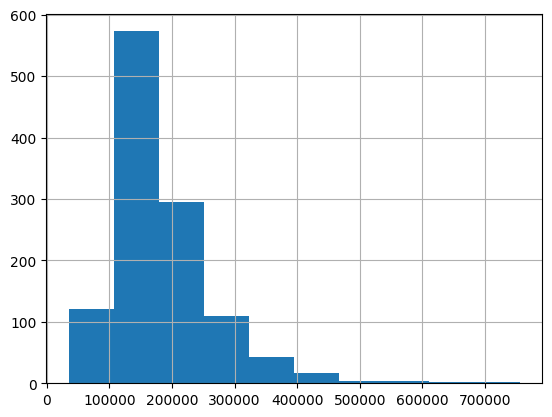

In [72]:
## so lets look at output (should be normal, else try to make it with transformation
## handle multicolinearity, Condition number < 10 ideally
trainData["SalePrice"].hist()

<Axes: >

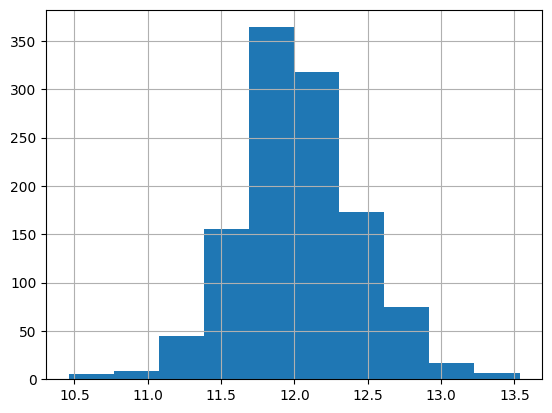

In [73]:
np.log(trainData["SalePrice"]).hist()

### Feature Engineering
Let's do our feature engineering and checks to set this up well for normality.

<Axes: >

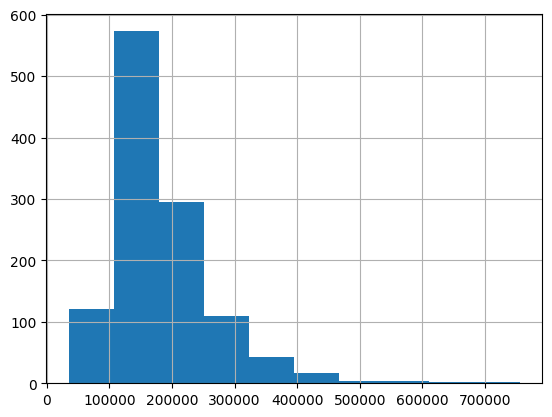

In [74]:
trainData["SalePrice"].hist()

In [75]:
print(metadata["MSSubClass"])
# The only unique info here is PUD, home style, age, number of floors all in rest of metadata
print(metadata["BldgType"])
print(metadata["YearBuilt"])
print(metadata["HouseStyle"])

{'description': 'Identifies the type of dwelling involved in the sale.', 'values': {20: '1-STORY 1946 & NEWER ALL STYLES', 30: '1-STORY 1945 & OLDER', 40: '1-STORY W/FINISHED ATTIC ALL AGES', 45: '1-1/2 STORY - UNFINISHED ALL AGES', 50: '1-1/2 STORY FINISHED ALL AGES', 60: '2-STORY 1946 & NEWER', 70: '2-STORY 1945 & OLDER', 75: '2-1/2 STORY ALL AGES', 80: 'SPLIT OR MULTI-LEVEL', 85: 'SPLIT FOYER', 90: 'DUPLEX - ALL STYLES AND AGES', 120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER', 150: '1-1/2 STORY PUD - ALL AGES', 160: '2-STORY PUD - 1946 & NEWER', 180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'}}
{'description': 'Type of dwelling', 'values': {'1Fam': 'Single-family Detached', '2FmCon': 'Two-family Conversion; originally built as one-family dwelling', 'Duplx': 'Duplex', 'TwnhsE': 'Townhouse End Unit', 'TwnhsI': 'Townhouse Inside Unit'}}
{'description': 'Original construction date', 'values': {}}
{'description': 'Style of dw

In [76]:
trainData.shape

(1167, 81)

In [77]:
train_data_engineered_features = trainData.copy()
metadata_engineered = metadata.copy()
# so we cut out MSSubClass and convert to isPUD
pud_categories = [120, 150, 160, 180]
train_data_engineered_features["isPUD"]  = train_data_engineered_features["MSSubClass"].isin(pud_categories).astype(int)
del metadata_engineered["MSSubClass"]
train_data_engineered_features = train_data_engineered_features.drop(columns=["MSSubClass"])

In [78]:
train_data_engineered_features["isPUD"].value_counts() 
# this is HOA + shared amenities in flexible layouts

isPUD
0    1034
1     133
Name: count, dtype: int64

In [79]:
print(trainData['MSZoning'].value_counts(normalize=True))

MSZoning
RL    0.780634
RM    0.151671
FV    0.045416
RH    0.013710
C     0.008569
Name: proportion, dtype: float64


In [80]:
# keep RL as baseline since its so big,
# group RH and C since they're small (and may have high std errors)
# Features: FV and RH, Other

train_data_engineered_features["MSZoning_is_residential_high_density_or_commercial_from_residential_low_density"]  = train_data_engineered_features["MSZoning"].isin(["RH", "C"]).astype(int)
train_data_engineered_features["MsZoning_is_floating_village_residential_from_residential_low_density"] =  (train_data_engineered_features["MSZoning"] == "FV").astype(int)
train_data_engineered_features["MSZoning_is_residential_medium_density_from_residential_low_densit"] =  (train_data_engineered_features["MSZoning"] == "RM").astype(int)
train_data_engineered_features = train_data_engineered_features.drop(columns=["MSZoning"])
del metadata_engineered["MSZoning"]

<Axes: >

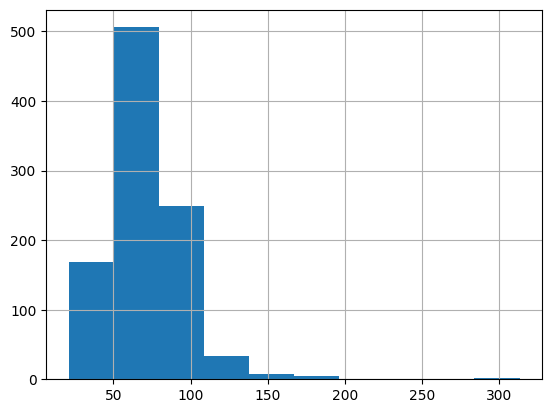

In [81]:
trainData["LotFrontage"].hist()

197
0


<Axes: >

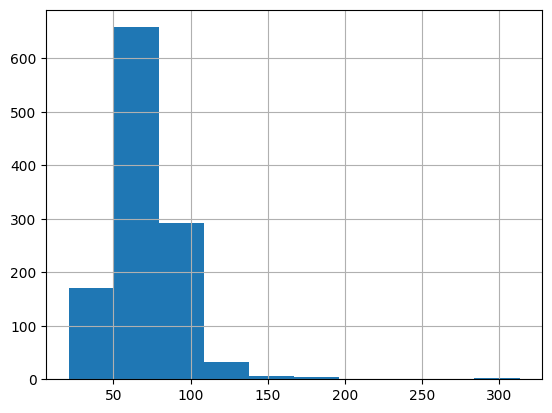

In [82]:
print(train_data_engineered_features["LotFrontage"].isna().sum())
# lets impute median by neighborhood and assumption on neighborhood
# makes p-value smaller and CI's smaller than they really are so just note
train_data_engineered_features['LotFrontage_IsMissing'] = train_data_engineered_features['LotFrontage'].isnull().astype(int)
train_data_engineered_features['LotFrontage'] = train_data_engineered_features.groupby('Neighborhood')['LotFrontage'].transform(
                                            lambda x: x.fillna(x.median()))
print(train_data_engineered_features["LotFrontage"].isna().sum())
train_data_engineered_features['LotFrontage'].hist()

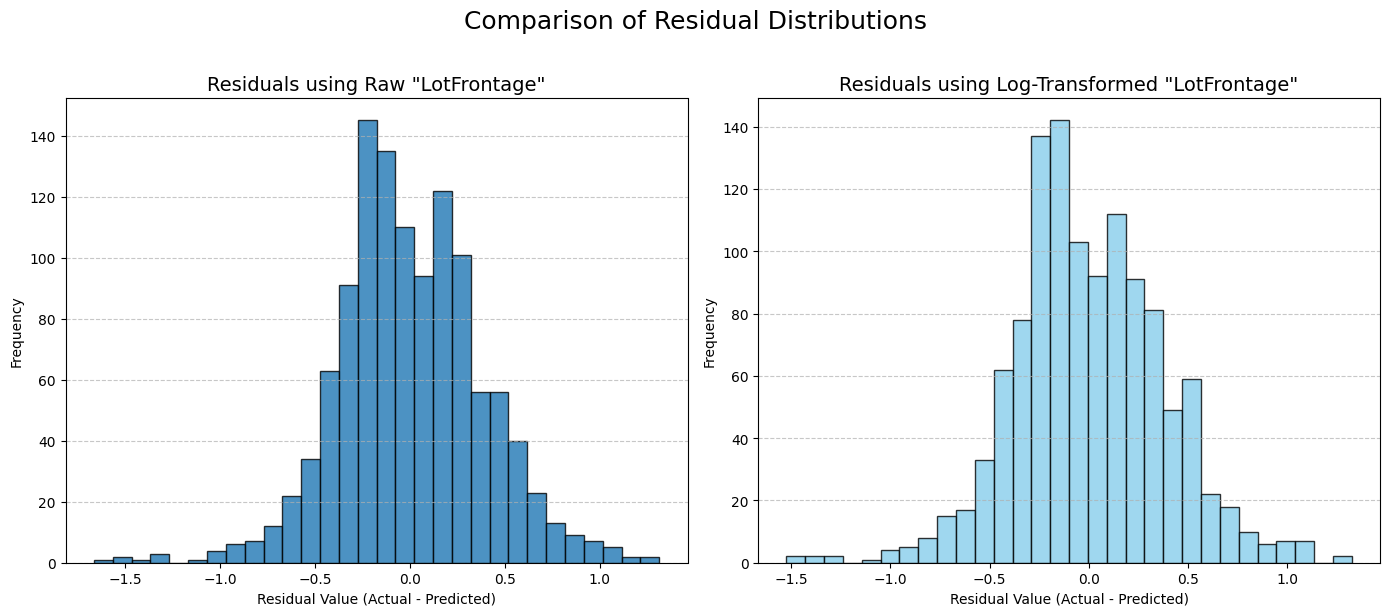

In [83]:
import matplotlib.pyplot as plt
def plot_residuals_single_feature(feature, label):
    """
    Fits two linear regression models (one with the raw feature, one with its log)
    and plots the histograms of their residuals on two separate subplots.
    
    Args:
        feature (pd.Series): The predictor variable.
        label (pd.Series): The target variable (e.g., SalePrice).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    feature_raw = feature.to_numpy().reshape(-1, 1)
    label_numpy = label.to_numpy() 
    
    model_raw = LinearRegression()
    model_raw.fit(feature_raw, label_numpy)
    residuals_raw = label_numpy - model_raw.predict(feature_raw)

    axes[0].hist(residuals_raw, bins=30, edgecolor='black', alpha=0.8)
    axes[0].set_title(f'Residuals using Raw "{feature.name}"', fontsize=14)
    axes[0].set_xlabel("Residual Value (Actual - Predicted)")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    feature_log = np.log(feature_raw)
    
    model_log = LinearRegression()
    model_log.fit(feature_log, label_numpy)
    residuals_log = label_numpy - model_log.predict(feature_log)
    
    axes[1].hist(residuals_log, bins=30, edgecolor='black', alpha=0.8, color='skyblue')
    axes[1].set_title(f'Residuals using Log-Transformed "{feature.name}"', fontsize=14)
    axes[1].set_xlabel("Residual Value (Actual - Predicted)")
    axes[1].set_ylabel("Frequency") 
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Add a main title for the entire figure
    fig.suptitle('Comparison of Residual Distributions', fontsize=18, y=1.02)
    
    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout()
    plt.show()
plot_residuals_single_feature(train_data_engineered_features['LotFrontage'], np.log(trainData["SalePrice"]))


In [84]:
# raw residuals look apropriate (normal)

In [85]:
print(train_data_engineered_features["Street"].value_counts(normalize=True))
# so one sided im dropping it
train_data_engineered_features.drop(columns=["Street"], inplace=True)
del metadata_engineered["Street"]

Street
Pave    0.994859
Grvl    0.005141
Name: proportion, dtype: float64


In [86]:
print(train_data_engineered_features["Alley"].value_counts(normalize=True))

train_data_engineered_features["HasAlley"] = (train_data_engineered_features["Alley"] != "NA").astype(int)
train_data_engineered_features["HasAlley"].value_counts(normalize=True)

train_data_engineered_features.drop(columns=["Alley"], inplace=True)
del metadata_engineered["Alley"]

Alley
NA      0.940017
Grvl    0.034276
Pave    0.025707
Name: proportion, dtype: float64


In [87]:
print(train_data_engineered_features["LotShape"].value_counts(normalize=True))

train_data_engineered_features["isIrregularLotShape"] = (train_data_engineered_features["LotShape"] == "Reg").astype(int)
print(train_data_engineered_features["isIrregularLotShape"].value_counts())
train_data_engineered_features.drop(columns=["LotShape"], inplace=True)
del metadata_engineered["LotShape"]

LotShape
Reg    0.642674
IR1    0.322194
IR2    0.029135
IR3    0.005998
Name: proportion, dtype: float64
isIrregularLotShape
1    750
0    417
Name: count, dtype: int64


In [88]:
print(train_data_engineered_features["LandContour"].value_counts(normalize=True))
train_data_engineered_features["isBankedFromLevelCountour"] = (train_data_engineered_features["LandContour"] == "Bnk").astype(int)
train_data_engineered_features["isLowOrHighSlopeFromLevelCountour"] = (train_data_engineered_features["LandContour"].isin(["Low", "HLS"])).astype(int)
train_data_engineered_features.drop(columns=["LandContour"], inplace=True)
del metadata_engineered["LandContour"]

LandContour
Lvl    0.895458
Bnk    0.043702
HLS    0.032562
Low    0.028278
Name: proportion, dtype: float64


In [89]:
print(train_data_engineered_features["Utilities"].value_counts(normalize=True))
# dropping lol 
train_data_engineered_features.drop(columns=["Utilities"], inplace=True)

Utilities
AllPub    1.0
Name: proportion, dtype: float64


In [90]:
print(train_data_engineered_features["LotConfig"].value_counts(normalize=True))
# inside, corner culdsac and (frontage 2 or 3 roads) due to frequency
train_data_engineered_features["isCornerLotFromInsideLotReference"] = (train_data_engineered_features["LotConfig"] == "Corner").astype(int)
train_data_engineered_features["isCulDSacLotFromInsideLotReference"] = (train_data_engineered_features["LotConfig"] == "CulDSac").astype(int)
train_data_engineered_features["isFrontageOn2Or3RoadsFromInsideLotReference"] = (train_data_engineered_features["LotConfig"].isin(["FR2", "FR3"])).astype(int)
train_data_engineered_features.drop(columns=["LotConfig"], inplace=True);

LotConfig
Inside     0.722365
Corner     0.179092
CulDSac    0.066838
FR2        0.028278
FR3        0.003428
Name: proportion, dtype: float64


In [91]:
print(train_data_engineered_features["LandSlope"].value_counts(normalize=True))
# however I am concerned with overlap for LandContour
# there's high conceptual overlap so I am going to drop less descriptive one which is this one
train_data_engineered_features.drop(columns=["LandSlope"], inplace=True)

LandSlope
Gtl    0.944302
Mod    0.044559
Sev    0.011140
Name: proportion, dtype: float64


Neighborhood
Blueste    0.001714
NPkVill    0.005141
Veenker    0.007712
BrDale     0.010283
Blmngtn    0.010283
MeadowV    0.012853
StoneBr    0.018852
SWISU      0.019709
ClearCr    0.020566
IDOTRR     0.023136
Timber     0.026564
NoRidge    0.028278
Crawfor    0.033419
Mitchel    0.034276
BrkSide    0.035990
SawyerW    0.041988
NWAmes     0.047129
Sawyer     0.047986
Gilbert    0.052271
NridgHt    0.056555
Somerst    0.059983
Edwards    0.070266
OldTown    0.082262
CollgCr    0.103685
Names      0.149100
Name: proportion, dtype: float64


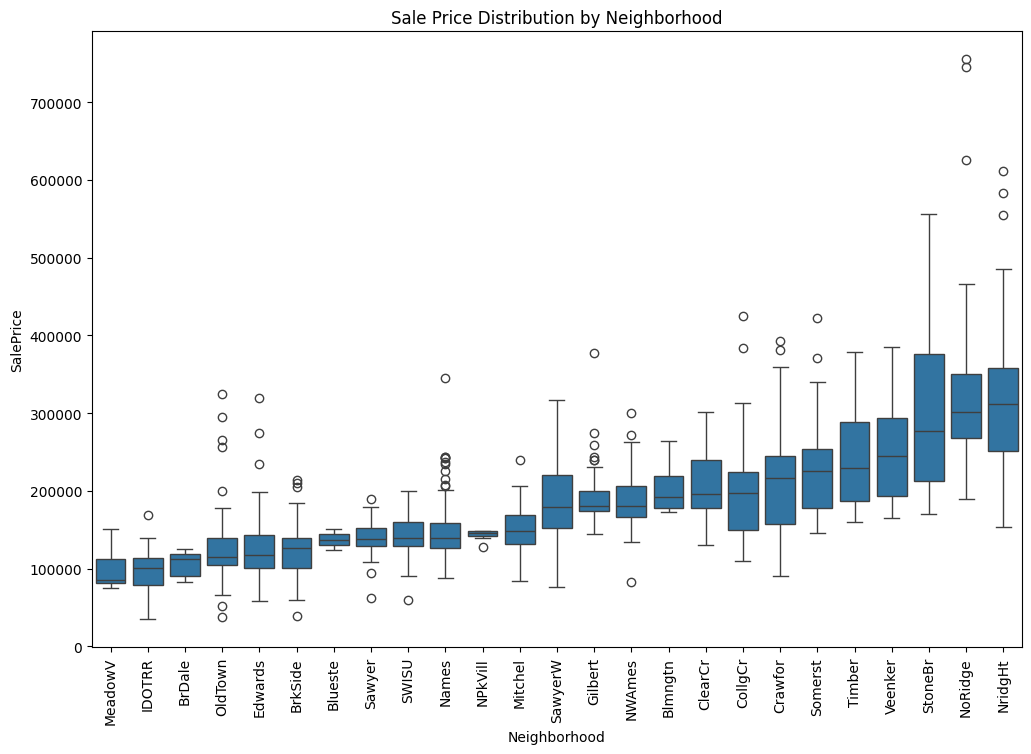

In [92]:
print(train_data_engineered_features["Neighborhood"].value_counts(normalize=True).sort_values())
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot to see the distribution of SalePrice by Neighborhood
plt.figure(figsize=(12, 8))
# Order the boxes by median SalePrice to make trends obvious
order = trainData.groupby('Neighborhood')['SalePrice'].median().sort_values().index
sns.boxplot(x='Neighborhood', y='SalePrice', data=trainData, order=order)
plt.xticks(rotation=90)
plt.title('Sale Price Distribution by Neighborhood')
plt.show()

In [93]:
# so now we will tier the neighborhoods and set reference

tier1_hoods = ['Veenker', 'Somerst', 'Timber', 'StoneBr', 'NoRidge', 'NridgHt']
tier3_hoods = ['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards', 'BrkSide', 'Sawyer', 
               'Blueste', 'SWISU', 'Names', 'NPkVill']

def assign_neighborhood_tier(hood):
    if hood in tier1_hoods:
        return 'Tier_1_HighValue'
    elif hood in tier3_hoods:
        return 'Tier_3_LowerValue'
    else: # Everything else falls into the middle tier
        return 'Tier_2_MidValue'

train_data_engineered_features['Neighborhood_Tier'] = train_data_engineered_features['Neighborhood'].apply(assign_neighborhood_tier)

train_data_engineered_features['isTier2MidValueNeighborhoodFromTier3LowValueNeighborhoodReference'] = (train_data_engineered_features['Neighborhood_Tier'] == "Tier_2_MidValue").astype(int)
train_data_engineered_features['isTier1HighValueNeighborhoodFromTier3LowValueNeighborhoodReference'] = (train_data_engineered_features['Neighborhood_Tier'] == 'Tier_1_HighValue').astype(int)

train_data_engineered_features.drop(columns=["Neighborhood_Tier", "Neighborhood"], inplace=True)

del metadata_engineered["Neighborhood"]

In [94]:
train_data_engineered_features["AdjacentToArterialStreet"] = ((train_data_engineered_features["Condition1"] == "Artery") | (train_data_engineered_features["Condition2"] == "Artery")).astype(int)
print(f"Aterial condition fraction:{train_data_engineered_features['AdjacentToArterialStreet'].mean()}")

train_data_engineered_features["AdjacentToFeederStreet"] = ((train_data_engineered_features["Condition1"] == "Feedr") | (train_data_engineered_features["Condition2"] == "Feedr")).astype(int)
print(f"Feeder condition fraction:{train_data_engineered_features['AdjacentToFeederStreet'].mean()}")

train_data_engineered_features["NormalProximity"] = ((train_data_engineered_features["Condition1"] == "Norm") | (train_data_engineered_features["Condition2"] == "Norm")).astype(int)
print(f"Normal condition fraction:{train_data_engineered_features['NormalProximity'].mean()}")

train_data_engineered_features["RRNnProximity"] = ((train_data_engineered_features["Condition1"] == "RRNn") | (train_data_engineered_features["Condition2"] == "RRNn")).astype(int)
print(f"200' of N-S railroad condition fraction:{train_data_engineered_features['RRNnProximity'].mean()}")

train_data_engineered_features["RRAnAdjacency"] = ((train_data_engineered_features["Condition1"] == "RRAn") | (train_data_engineered_features["Condition2"] == "RRAn")).astype(int)
print(f"Adjacent to N-S railroad condition fraction:{train_data_engineered_features['RRAnAdjacency'].mean()}")

train_data_engineered_features["PositiveOffsiteFeatureProximity"] = ((train_data_engineered_features["Condition1"] == "PosN") | (train_data_engineered_features["Condition2"] == "PosN")).astype(int)
print(f"Positive offsite feature condition fraction:{train_data_engineered_features['PositiveOffsiteFeatureProximity'].mean()}")

train_data_engineered_features["PositiveOffsiteFeatureAdjacent"] = ((train_data_engineered_features["Condition1"] == "PosA") | (train_data_engineered_features["Condition2"] == "PosA")).astype(int)
print(f"Positive offsite feature adjacent condition fraction:{train_data_engineered_features['PositiveOffsiteFeatureAdjacent'].mean()}")

train_data_engineered_features["RRNeProximity"] = ((train_data_engineered_features["Condition1"] == "RRNe") | (train_data_engineered_features["Condition2"] == "RRNe")).astype(int)
print(f"200' of E-W railroad condition fraction:{train_data_engineered_features['RRNeProximity'].mean()}")

train_data_engineered_features["RRNeAdjacency"] = ((train_data_engineered_features["Condition1"] == "RRAe") | (train_data_engineered_features["Condition2"] == "RRAe")).astype(int)
print(f"Adjacent E-W railroad condition fraction:{train_data_engineered_features['RRNeAdjacency'].mean()}")


Aterial condition fraction:0.03513281919451585
Feeder condition fraction:0.05826906598114824
Normal condition fraction:0.988860325621251
200' of N-S railroad condition fraction:0.004284490145672665
Adjacent to N-S railroad condition fraction:0.018851756640959727
Positive offsite feature condition fraction:0.011996572407883462
Positive offsite feature adjacent condition fraction:0.006855184233076264
200' of E-W railroad condition fraction:0.001713796058269066
Adjacent E-W railroad condition fraction:0.007712082262210797


In [95]:
# Since this is like 2 of N, I am considering making isNotNormal a feature as well as AdjacentOrProximityToRailroad combining the 4, and arterialOrFeeder condition another feature.
# isNotNormal since normal is a natural baseline
train_data_engineered_features["isNotNormalProximity"] = ((train_data_engineered_features["Condition1"] != "Norm") & (train_data_engineered_features["Condition2"] == "Norm")).astype(int)
train_data_engineered_features.drop(columns=["NormalProximity"], inplace=True)

train_data_engineered_features["isNearRailRoad"] = (train_data_engineered_features["RRNnProximity"] | train_data_engineered_features["RRAnAdjacency"] | train_data_engineered_features["RRNeProximity"] | train_data_engineered_features["RRNeAdjacency"]).astype(int)
train_data_engineered_features.drop(columns=["RRNnProximity", "RRAnAdjacency", "RRNeProximity", "RRNeAdjacency"], inplace=True)

train_data_engineered_features["isNearPositiveOffsiteFeature"] = (train_data_engineered_features["PositiveOffsiteFeatureProximity"] | train_data_engineered_features["PositiveOffsiteFeatureAdjacent"])
train_data_engineered_features.drop(columns=["PositiveOffsiteFeatureAdjacent", "PositiveOffsiteFeatureProximity"], inplace=True)

train_data_engineered_features.drop(columns=["Condition1", "Condition2"], inplace=True)

In [96]:
print(train_data_engineered_features["HouseStyle"].value_counts(normalize=True))
train_data_engineered_features["is2or2.5StoryFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["2Story", "2.5Fin"]).astype(int)
train_data_engineered_features["is1.5StoryFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["1.5Fin"]).astype(int)
train_data_engineered_features["isSplitLevelOrFoyerFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["SLvl", "SFoyer"]).astype(int)
train_data_engineered_features["isUnfinishedFrom1StoryReference"] = train_data_engineered_features["HouseStyle"].isin(["1.5Unf", "2.5Unf"]).astype(int)
train_data_engineered_features.drop(columns=["HouseStyle"], inplace=True)

HouseStyle
1Story    0.501285
2Story    0.303342
1.5Fin    0.101971
SLvl      0.042845
SFoyer    0.028278
1.5Unf    0.009426
2.5Unf    0.006855
2.5Fin    0.005998
Name: proportion, dtype: float64


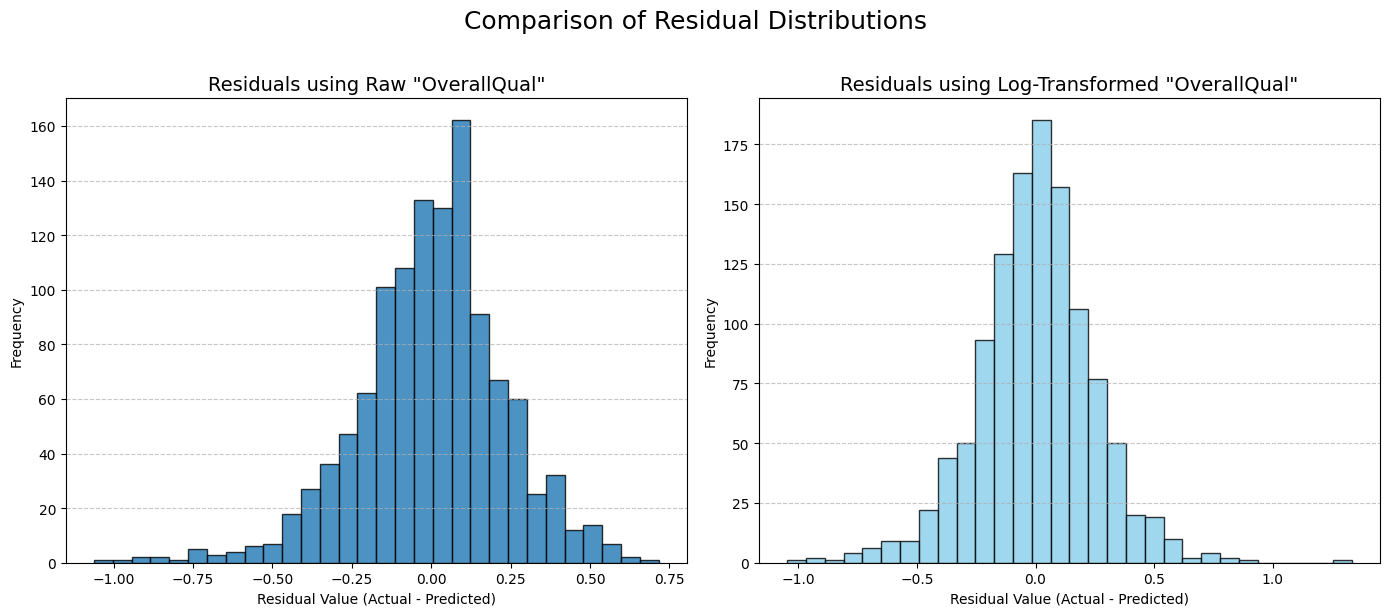

In [97]:
plot_residuals_single_feature(train_data_engineered_features["OverallQual"], np.log(trainData["SalePrice"]))

In [98]:
train_data_engineered_features.drop(columns=["BldgType"], inplace=True)

int64


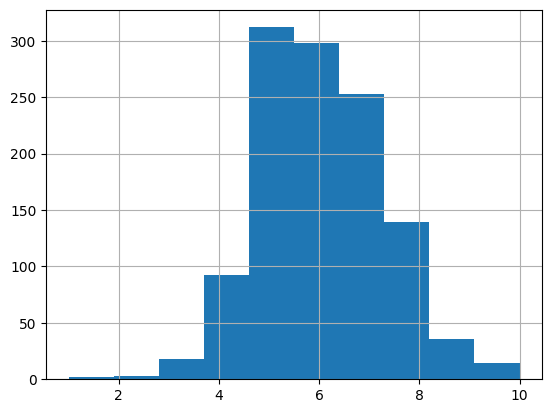

In [99]:
train_data_engineered_features["OverallQual"].hist()
print(train_data_engineered_features["OverallQual"].dtype)
# I feel like we can keep this as is
# not really more normal and the distribution looks okay

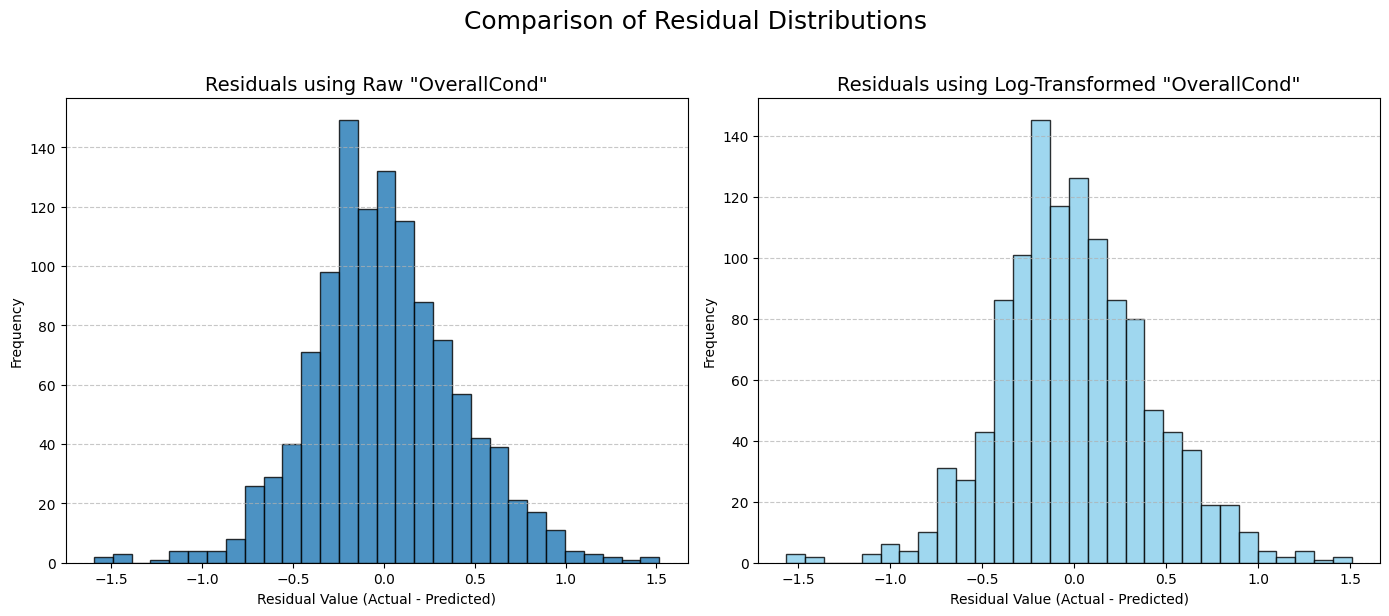

In [100]:
plot_residuals_single_feature(train_data_engineered_features["OverallCond"], np.log(trainData["SalePrice"]))

In [101]:
# overall condition transformed to log doesn't help much either in residuals

In [102]:
# overall condition since its a bit oddly shaped I am considering 3 categories 5, below 5 and above 5
def bin_overall_condition(c):
    if c == 5:
        return "AVG"
    elif c < 5:
        return "BELOW_AVG"
    else:
        return "ABOVE_AVG"

train_data_engineered_features["OverallConditionBinned"] = train_data_engineered_features["OverallCond"].apply(bin_overall_condition)

train_data_engineered_features["isAboveAverageFromBelowAverageReferenceOverallQuality"] = (train_data_engineered_features["OverallConditionBinned"] == "ABOVE_AVG").astype(int)
train_data_engineered_features["isAverageFromBelowAverageReferenceOverallQuality"] = (train_data_engineered_features["OverallConditionBinned"] == "AVG").astype(int)

train_data_engineered_features.drop(columns=["OverallConditionBinned", "OverallCond"], inplace=True)

<Axes: >

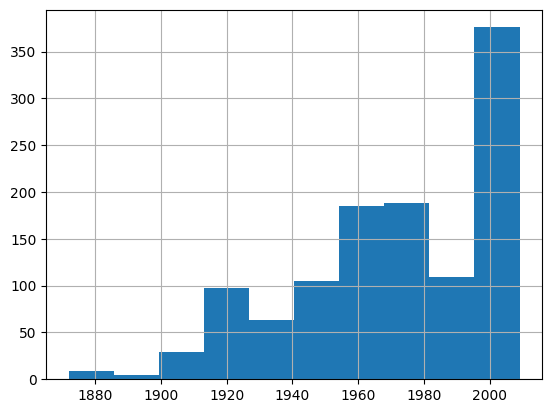

In [103]:
train_data_engineered_features["YearBuilt"].hist()

In [104]:
# reference category will be before 1941
def binYearBuilt(year):
    if year <= 1940:
        return "BEFORE_1941"
    elif year <= 1980:
        return "BETWEEN_1940_AND_1980"
    else:
        return "AFTER_1980"
    
train_data_engineered_features["YearBuiltBinned"] = train_data_engineered_features["YearBuilt"].apply(binYearBuilt)
train_data_engineered_features["isBuiltBetween1940And1980FromReferenceBefore1941"] = (train_data_engineered_features["YearBuiltBinned"] == "BETWEEN_1940_AND_1980").astype(int)
train_data_engineered_features["isBuiltAfter1980FromReferenceBefore1941"] = (train_data_engineered_features["YearBuiltBinned"] == "AFTER_1980").astype(int)
train_data_engineered_features.drop(columns=["YearBuiltBinned", "YearBuilt"], inplace=True)

In [105]:
train_data_engineered_features["wasRemodeled"] = (train_data_engineered_features["YearRemodAdd"] != trainData["YearBuilt"]).astype(int) 
train_data_engineered_features.drop(columns=["YearRemodAdd"], inplace=True) # was remodeled simple bin since ~47%

In [106]:
print(train_data_engineered_features["RoofStyle"].value_counts(normalize=True))
# looks like gable reference, and nonGlableRoofStyle 
train_data_engineered_features["hipOrNonGableRoofStyle"] = (train_data_engineered_features["RoofStyle"] != "Gable").astype(int)
train_data_engineered_features.drop(columns=["RoofStyle"], inplace=True)

RoofStyle
Gable      0.786632
Hip        0.191088
Gambrel    0.007712
Flat       0.006855
Mansard    0.005998
Shed       0.001714
Name: proportion, dtype: float64


In [107]:
print(train_data_engineered_features["RoofMatl"].value_counts(normalize=True))
# 98% one value so skewed will drop
train_data_engineered_features.drop(columns=["RoofMatl"], inplace=True)

RoofMatl
CompShg    0.985433
Tar&Grv    0.005141
WdShngl    0.003428
WdShake    0.002571
Metal      0.000857
ClyTile    0.000857
Roll       0.000857
Membran    0.000857
Name: proportion, dtype: float64


In [108]:
print(train_data_engineered_features["Exterior1st"].value_counts(normalize=True), train_data_engineered_features["Exterior2nd"].value_counts(normalize=True))
# has to have an exterior so cant just do binary for whetehr it has it or not
# will just use exterior 1 reference VinlySd:
train_data_engineered_features["hasHighDensityFiberboardPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "HdBoard").astype(int)
train_data_engineered_features["hasMetalSidingPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "MetalSd").astype(int)
train_data_engineered_features["hasWoodSidingPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "Wd Sdng").astype(int)
train_data_engineered_features["hasPlywoodPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "Plywood").astype(int)
train_data_engineered_features["hasCementBoardPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "CemntBd").astype(int)
train_data_engineered_features["hasBrickFacedPrimaryExteriorFromVinylSdPrimaryExterior"] = (train_data_engineered_features["Exterior1st"] == "BrkFace").astype(int)
train_data_engineered_features["hasWoodShinglesOrStuccoOrAbestosShinglesOrBrickCommonOrStoneOrAsphaltShinglesOrImitationStuccoOrConcreteMasonryUnitPrimaryExteriorFromVinylSlidingPrimaryExterior"] = (train_data_engineered_features["Exterior1st"].isin(["WdShing", "Stucco", "AsbShng", "BrkComm", "Stone", "AsphShn", "ImStucc", "CBlock"])).astype(int)
train_data_engineered_features.drop(columns=["Exterior1st", "Exterior2nd"], inplace=True)

Exterior1st
VinylSd    0.354756
HdBoard    0.149100
MetalSd    0.147386
Wd Sdng    0.143102
Plywood    0.071123
CemntBd    0.043702
BrkFace    0.036847
WdShing    0.018852
Stucco     0.016281
AsbShng    0.013710
BrkComm    0.001714
Stone      0.000857
AsphShn    0.000857
ImStucc    0.000857
CBlock     0.000857
Name: proportion, dtype: float64 Exterior2nd
VinylSd    0.345330
Wd Sdng    0.161954
MetalSd    0.143102
HdBoard    0.138817
Plywood    0.095973
CemntBd    0.043702
BrkFace    0.017995
Stucco     0.017138
AsbShng    0.014567
ImStucc    0.008569
BrkComm    0.005141
Stone      0.003428
AsphShn    0.002571
Other      0.000857
CBlock     0.000857
Name: proportion, dtype: float64


In [109]:
print(train_data_engineered_features["MasVnrType"].value_counts(normalize=True))
train_data_engineered_features["hasBrickFaceOrBrickCommonMasonryVeneerType"] = (train_data_engineered_features["MasVnrType"].isin(["BrkFace", "BrkCmn"])).astype(int)
train_data_engineered_features["hasStoneMasonryVeneerType"] = (train_data_engineered_features["MasVnrType"] == "Stone").astype(int)
train_data_engineered_features.drop(columns=["MasVnrType"], inplace=True)

MasVnrType
None       0.596401
BrkFace    0.299057
Stone      0.094259
BrkCmn     0.010283
Name: proportion, dtype: float64


np.float64(0.005998286203941731)

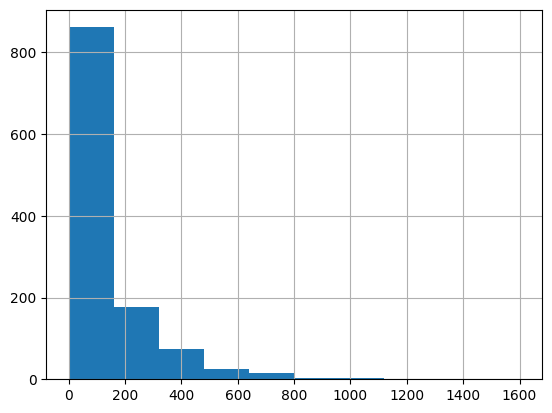

In [110]:
train_data_engineered_features["MasVnrArea"].hist()
(train_data_engineered_features["MasVnrArea"].isna()).mean()

In [111]:
# am going to drop this because it's logically correlated with Masonry veneer type which we already capture
train_data_engineered_features.drop(columns=["MasVnrArea"], inplace=True)

In [112]:
print(train_data_engineered_features["ExterQual"].value_counts(normalize=True))
# dropping this and use overall quality, as there is probably a lot of multi colinearity logically and between good and typical account for over 95% of data
train_data_engineered_features.drop(columns=["ExterQual"], inplace=True)

ExterQual
TA    0.613539
Gd    0.340189
Ex    0.035990
Fa    0.010283
Name: proportion, dtype: float64


In [113]:
print(train_data_engineered_features["ExterCond"].value_counts(normalize=True))
# dropping this and use overall condition, as there is probably a lot of multi colinearity logically and between good and typical account for over 97% of data, not that useful
train_data_engineered_features.drop(columns=["ExterCond"], inplace=True)

ExterCond
TA    0.880891
Gd    0.099400
Fa    0.016281
Ex    0.002571
Po    0.000857
Name: proportion, dtype: float64


In [114]:
print(train_data_engineered_features["Foundation"].value_counts(normalize=True))
train_data_engineered_features["isCinderBlockFoundationFromReferencePouredConcreteFoundation"] = (train_data_engineered_features["Foundation"] == "CBlock").astype(int)
train_data_engineered_features["isBrikeTileFoundationFromReferencePouredConcreteFoundation"] = (train_data_engineered_features["Foundation"] == "BrkTil").astype(int)
train_data_engineered_features["isSlabOrStoneOrWoodFoundationFromReferencePouredConcreteFoundation"] = (train_data_engineered_features["Foundation"].isin(["Slab", "Stone", "Wood"])).astype(int)
train_data_engineered_features.drop(columns=["Foundation"], inplace=True)

Foundation
PConc     0.446444
CBlock    0.430163
BrkTil    0.101971
Slab      0.014567
Stone     0.004284
Wood      0.002571
Name: proportion, dtype: float64


In [115]:
print(train_data_engineered_features["BsmtExposure"].value_counts(normalize=True))
print(train_data_engineered_features["BsmtQual"].value_counts(normalize=True))
print(train_data_engineered_features["BsmtCond"].value_counts(normalize=True))

BsmtExposure
No    0.641817
Av    0.155955
Gd    0.097686
Mn    0.078835
NA    0.025707
Name: proportion, dtype: float64
BsmtQual
TA    0.442159
Gd    0.424165
Ex    0.085690
NA    0.025707
Fa    0.022279
Name: proportion, dtype: float64
BsmtCond
TA    0.898886
Gd    0.043702
Fa    0.030848
NA    0.025707
Po    0.000857
Name: proportion, dtype: float64


In [116]:
# theres a lot of inforamtion on basement, but I think I want to just look at condition as a summary
train_data_engineered_features["BasementHeight90+InchesFromNoBasementReference"] = (train_data_engineered_features["BsmtQual"].isin(["Ex", "Gd"])).astype(int)
train_data_engineered_features["BasementHeight70-89InchesFromNoBasementReference"] = (train_data_engineered_features["BsmtQual"].isin(["TA", "Fa"])).astype(int)
train_data_engineered_features.drop(columns=["BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"], inplace=True)

In [117]:
print(train_data_engineered_features["Heating"].value_counts(normalize=True))
# so dominated by 1 category i will drop
train_data_engineered_features.drop(columns=["Heating"], inplace=True)

Heating
GasA     0.977721
GasW     0.012853
Grav     0.005141
Wall     0.002571
Floor    0.000857
OthW     0.000857
Name: proportion, dtype: float64


In [118]:
print(train_data_engineered_features["HeatingQC"].value_counts(normalize=True))
train_data_engineered_features["HeatingExcellentFromGoodOrTypicalOrFairOrPoorReference"] = (train_data_engineered_features["HeatingQC"] == "Ex").astype(int)
train_data_engineered_features.drop(columns=["HeatingQC"], inplace=True)

HeatingQC
Ex    0.520994
TA    0.281919
Gd    0.165381
Fa    0.030848
Po    0.000857
Name: proportion, dtype: float64


In [119]:
print(train_data_engineered_features["CentralAir"].value_counts(normalize=True))
# big enough good enough
train_data_engineered_features["hasCentralAir"] = (train_data_engineered_features["CentralAir"] == "Y").astype(int)
train_data_engineered_features.drop(columns=["CentralAir"], inplace=True)

CentralAir
Y    0.929734
N    0.070266
Name: proportion, dtype: float64


In [120]:
train_data_engineered_features["Electrical"].value_counts(normalize=True)
train_data_engineered_features["hasStandardCircuitBreakersFromOlderReference"] = (train_data_engineered_features["Electrical"] == "SBrkr").astype(int)
train_data_engineered_features.drop(columns=["Electrical"], inplace=True)

<Axes: >

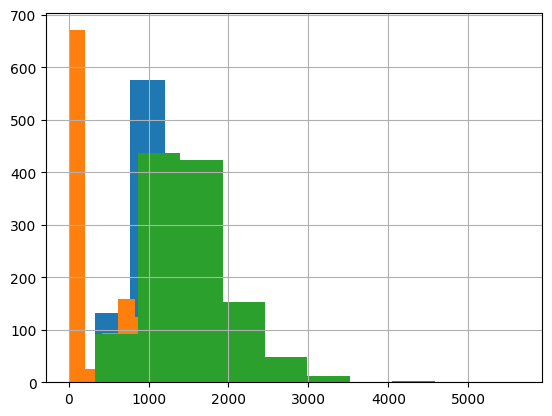

In [121]:
train_data_engineered_features["1stFlrSF"].hist()
train_data_engineered_features["2ndFlrSF"].hist()
train_data_engineered_features["GrLivArea"].hist()

In [122]:
# I think I will use above ground and not look at basement sq footage at all
train_data_engineered_features.drop(columns=["1stFlrSF", "2ndFlrSF", "LowQualFinSF"], inplace=True)

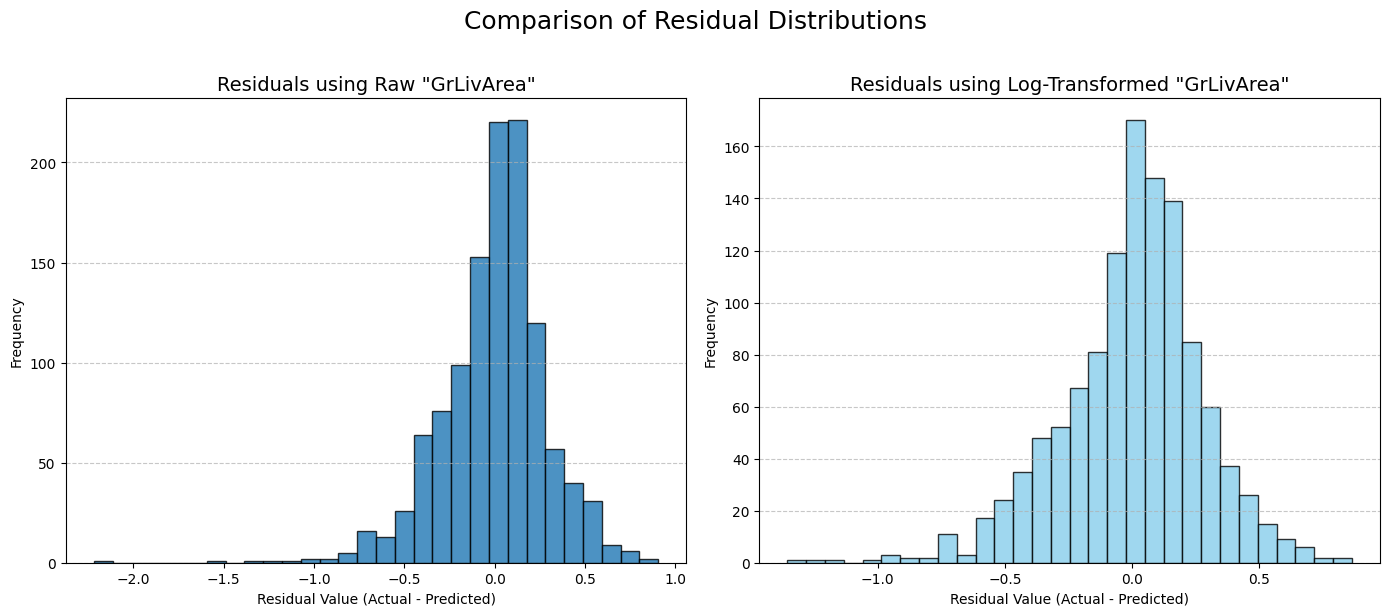

In [123]:
plot_residuals_single_feature(train_data_engineered_features["GrLivArea"], np.log(trainData["SalePrice"]))
# log looks better so 
train_data_engineered_features["LogAboveGroundLivingArea"] = np.log(train_data_engineered_features["GrLivArea"])
train_data_engineered_features.drop(columns=["GrLivArea"], inplace=True)

In [124]:
print(train_data_engineered_features["BsmtFullBath"].value_counts(normalize=True))
# feature for basement in bathroom maybe? will drop afraid of correaltion with having one
train_data_engineered_features.drop(columns=["BsmtFullBath", "BsmtHalfBath"], inplace=True)

BsmtFullBath
0    0.583548
1    0.405313
2    0.011140
Name: proportion, dtype: float64


In [125]:
train_data_engineered_features["NumBathrooms"] = train_data_engineered_features["FullBath"] + 0.5 * train_data_engineered_features["HalfBath"]
train_data_engineered_features.drop(columns=["HalfBath", "FullBath"], inplace=True)

In [126]:
print(train_data_engineered_features["Bedroom"].value_counts(normalize=True))

Bedroom
3    0.543273
2    0.251928
4    0.144816
1    0.034276
5    0.014567
0    0.005141
6    0.005141
8    0.000857
Name: proportion, dtype: float64


In [127]:
# these seem problematic with correlations (livable space, etc):
train_data_engineered_features.drop(columns=["Kitchen", "TotRmsAbvGrd", "Functional", "FireplaceQu"], inplace=True)

In [128]:
train_data_engineered_features["hasFirePlace"] = (train_data_engineered_features["Fireplaces"] > 0).astype(int)
train_data_engineered_features.drop(columns=["Fireplaces"], inplace=True)

In [129]:
print(train_data_engineered_features["GarageType"].value_counts(normalize=True))
# good categories seem refercne garage, attached and detached and built in
train_data_engineered_features["NoGarageFromAttachedGarageReference"] = (train_data_engineered_features["GarageType"] == "NA").astype(int)
train_data_engineered_features["DetachedGarageFromAttachedGarageReference"] = (train_data_engineered_features["GarageType"] == "Detchd").astype(int)
train_data_engineered_features["BuiltInOrBasementOrCarPortOr2TypesGarageFromAttachedGarageReference"] = (train_data_engineered_features["GarageType"].isin(["BuiltIn", "2Types", "CarPort", "Basment"])).astype(int)
train_data_engineered_features.drop(columns=["GarageType"], inplace=True)

GarageType
Attchd     0.596401
Detchd     0.262211
BuiltIn    0.062554
NA         0.053128
Basment    0.015424
CarPort    0.005998
2Types     0.004284
Name: proportion, dtype: float64


In [130]:
# other garage that may be correlated
train_data_engineered_features.drop(columns=["GarageYrBlt", "GarageFinish", "GarageCars",  "GarageArea", "GarageQual", "GarageCond"], inplace=True)

In [131]:
print(train_data_engineered_features["PavedDrive"].value_counts(normalize=True))
# okay at 8% minority
train_data_engineered_features["isFullyPavedDriveway"] = (train_data_engineered_features["PavedDrive"] == "Y").astype(int)
train_data_engineered_features.drop(columns=["PavedDrive"], inplace=True)

PavedDrive
Y    0.914310
N    0.065124
P    0.020566
Name: proportion, dtype: float64


In [132]:
print((train_data_engineered_features["WoodDeckSF"] > 0).mean())
# can make hasWoodDeck
train_data_engineered_features["hasWoodDeck"] = (train_data_engineered_features["WoodDeckSF"] > 0).astype(int)
train_data_engineered_features.drop(columns=["WoodDeckSF"], inplace=True)


0.48414738646101113


In [133]:
print((train_data_engineered_features["OpenPorchSF"] > 0).mean())
# can make hasOpenPorch
train_data_engineered_features["hasOpenPorch"] = (train_data_engineered_features["OpenPorchSF"] > 0).astype(int)
train_data_engineered_features.drop(columns=["OpenPorchSF"], inplace=True)

0.5569837189374465


In [134]:
print((train_data_engineered_features["EnclosedPorch"] > 0).mean())
# can make hasEnclosedPorch
train_data_engineered_features["hasEnclosedPorch"] = (train_data_engineered_features["EnclosedPorch"] > 0).astype(int)
train_data_engineered_features.drop(columns=["EnclosedPorch"], inplace=True)

0.14481576692373607


In [135]:
print((train_data_engineered_features["3SsnPorch"] > 0).mean())
# dropping
train_data_engineered_features.drop(columns=["3SsnPorch"], inplace=True)

0.013710368466152529


In [136]:
print((train_data_engineered_features["ScreenPorch"] > 0).mean())
# can make hasScreenPorch
train_data_engineered_features["hasScreenPorch"] = (train_data_engineered_features["ScreenPorch"] > 0).astype(int)
train_data_engineered_features.drop(columns=["ScreenPorch"], inplace=True)

0.07369323050556983


In [137]:
print((train_data_engineered_features["PoolArea"] > 0).mean())
# too small
train_data_engineered_features.drop(columns=["PoolArea", "PoolQC"], inplace=True)

0.004284490145672665


In [138]:
print(train_data_engineered_features["Fence"].value_counts(normalize=True))
# has fence
train_data_engineered_features["hasFence"] = (train_data_engineered_features["Fence"] != "NA").astype(int)
train_data_engineered_features.drop(columns=["Fence"], inplace=True)

Fence
NA       0.808055
MnPrv    0.103685
GdPrv    0.042845
GdWo     0.037704
MnWw     0.007712
Name: proportion, dtype: float64


In [139]:
# sparse high cardinality columns / irrelevant for interpretation
train_data_engineered_features.drop(columns=["MiscFeature", "MiscVal", "MoSold", "SaleType", "SaleCondition", "Id"], inplace=True)

I think ill leave this in perhaps as a way to capture year over year growth


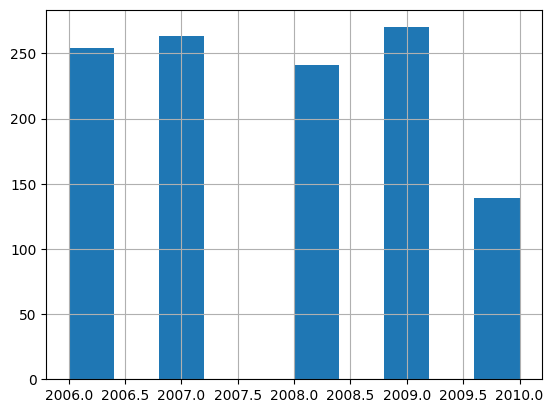

In [140]:
train_data_engineered_features["YrSold"].hist()
print("I think ill leave this in perhaps as a way to capture year over year growth")

In [141]:
train_data_engineered_features.drop(columns=["KitchenQual", "SalePrice"], inplace=True)

In [142]:
# phew thats a lot of feature engineering, so we now have
print(train_data_engineered_features.shape)
train_data_engineered_features.columns

(1167, 63)


Index(['LotFrontage', 'LotArea', 'OverallQual', 'Bedroom', 'YrSold', 'isPUD',
       'MSZoning_is_residential_high_density_or_commercial_from_residential_low_density',
       'MsZoning_is_floating_village_residential_from_residential_low_density',
       'MSZoning_is_residential_medium_density_from_residential_low_densit',
       'LotFrontage_IsMissing', 'HasAlley', 'isIrregularLotShape',
       'isBankedFromLevelCountour', 'isLowOrHighSlopeFromLevelCountour',
       'isCornerLotFromInsideLotReference',
       'isCulDSacLotFromInsideLotReference',
       'isFrontageOn2Or3RoadsFromInsideLotReference',
       'isTier2MidValueNeighborhoodFromTier3LowValueNeighborhoodReference',
       'isTier1HighValueNeighborhoodFromTier3LowValueNeighborhoodReference',
       'AdjacentToArterialStreet', 'AdjacentToFeederStreet',
       'isNotNormalProximity', 'isNearRailRoad',
       'isNearPositiveOffsiteFeature', 'is2or2.5StoryFrom1StoryReference',
       'is1.5StoryFrom1StoryReference',
       'isSpli

(array([  2.,   2.,   4.,   3.,  19., 181., 545., 345.,  59.,   7.]),
 array([-0.99800268, -0.84854147, -0.69908027, -0.54961907, -0.40015787,
        -0.25069666, -0.10123546,  0.04822574,  0.19768694,  0.34714815,
         0.49660935]),
 <BarContainer object of 10 artists>)

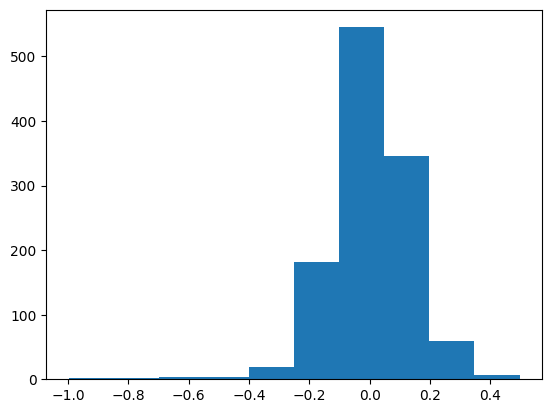

In [143]:
modelWithEngineeredFeatures = LinearRegression()
modelWithEngineeredFeatures.fit(train_data_engineered_features, np.log(trainData["SalePrice"]))
res = np.log(trainData["SalePrice"]) - modelWithEngineeredFeatures.predict(train_data_engineered_features)
plt.hist(res)

In [144]:
import statsmodels.api as sm

X_train_with_const = sm.add_constant(train_data_engineered_features, prepend=True)

X_train_with_const.head()
ols_model = sm.OLS(np.log(trainData["SalePrice"]), X_train_with_const)
results = ols_model.fit()

# Print the comprehensive summary table
print("\n\n--- OLS Regression Results Summary ---")
print(results.summary())



--- OLS Regression Results Summary ---
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     137.4
Date:                Tue, 16 Sep 2025   Prob (F-statistic):               0.00
Time:                        15:39:16   Log-Likelihood:                 664.00
No. Observations:                1167   AIC:                            -1200.
Df Residuals:                    1103   BIC:                            -876.0
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                                                                                                                                        c

In [146]:
# lets layer vif filtering on top of this
from numpy import inf
from statsmodels.stats.outliers_influence import variance_inflation_factor

def remove_high_vif_features(training_features: pd.DataFrame, max_vif: float):
    highest_vif = inf
    removed = []
    while highest_vif > max_vif:
        numpy_features = training_features.to_numpy()
        features_with_const = sm.add_constant(numpy_features, prepend=True)
        vifs = np.array([variance_inflation_factor(features_with_const, i + 1) for i in range(numpy_features.shape[1])])
        feature_index_with_highest_vif = np.argmax(vifs)
        if vifs[feature_index_with_highest_vif] > max_vif:
            column_name_highest_vif = training_features.columns[feature_index_with_highest_vif]
            training_features = training_features.drop(columns=[column_name_highest_vif])
            removed.append(column_name_highest_vif)
        highest_vif = vifs[feature_index_with_highest_vif]
    return training_features, removed

training_features, removed = remove_high_vif_features(train_data_engineered_features, max_vif=1.005)

In [147]:
training_features.shape

(1167, 7)

In [148]:
import statsmodels.api as sm

X_train_with_const = sm.add_constant(training_features, prepend=True)

X_train_with_const.head()
ols_model = sm.OLS(np.log(trainData["SalePrice"]), X_train_with_const)
results = ols_model.fit()

# Print the comprehensive summary table
print("\n\n--- OLS Regression Results Summary ---")
print(results.summary())



--- OLS Regression Results Summary ---
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     13.97
Date:                Tue, 16 Sep 2025   Prob (F-statistic):           1.78e-17
Time:                        15:40:02   Log-Likelihood:                -560.70
No. Observations:                1167   AIC:                             1137.
Df Residuals:                    1159   BIC:                             1178.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [149]:
# got an acceptable condition number (< 10 which means these are independent), and focusing on the low p-value (up to 0.01):

import pandas as pd
import numpy as np
import statsmodels.api as sm

def interpret_regression_model(results, 
                               is_y_log_transformed=False, 
                               alpha=0.05):
    """
    Generates human-readable interpretations for each coefficient in a fitted
    statsmodels OLS regression model.

    Args:
        results (statsmodels.regression.linear_model.RegressionResultsWrapper): 
            The fitted model results object from `sm.OLS(y, X).fit()`.
            
        is_y_log_transformed (bool): 
            Set to True if the dependent variable (y) was log-transformed. 
            This is crucial for correct interpretation. Defaults to False.
            
        alpha (float): 
            The significance level to determine if a coefficient is statistically 
            significant. Defaults to 0.05.
            
        dummy_metadata (dict): 
            A dictionary to provide context for dummy variables.
            - Keys: The column name of the dummy variable in the model.
            - Values: A dictionary with keys 'original_feature', 'this_category', 
                      and 'reference_category'.
            Example: 
            {
                'isTier1HighValueNeighborhoodFromTier3LowValueNeighborhoodReference': {
                    'original_feature': 'Neighborhood',
                    'this_category': 'Tier 1 (High Value)',
                    'reference_category': 'Tier 3 (Lower Value)'
                }
            }
    """
    
    # --- 1. Overall Model Summary ---
    y_name = results.model.endog_names
    r_squared = results.rsquared_adj
    cond_no = results.condition_number
    
    print("--- Overall Model Interpretation ---")
    print(f"The model aims to explain '{y_name}' {'(on a log scale)' if is_y_log_transformed else ''}.")
    print(f"Adjusted R-squared: {r_squared:.3f}. This model explains approximately {r_squared:.1%} of the variance in '{y_name}'.")
    if cond_no > 30:
        print(f"\nWARNING: The Condition Number is {cond_no:.1f}, indicating strong multicollinearity. "
              "Individual coefficient interpretations should be made with extreme caution as they may be unstable.\n")
    
    print("\n--- Interpretation of Individual Coefficients ---")

    # --- 2. Loop Through Each Coefficient ---
    for coef_name, coef_val in results.params.items():
        if coef_name.lower() == 'const':
            continue # Skip the intercept for individual interpretation

        p_value = results.pvalues[coef_name]
        conf_int = results.conf_int(alpha=alpha).loc[coef_name]
        is_significant = p_value < alpha
        
        print(f"\n--- Feature: {coef_name} ---")
    

        # --- 4. Generate Interpretation String ---
        interpretation = ""
        
        # A. Handle Dummy Variables if metadata is provided

        interpretation += (f"Variable: {coef_name}\n")

        if is_y_log_transformed:
            # Log-Level interpretation for dummy
            pct_change = (np.exp(coef_val) - 1) * 100
            direction = "increase" if pct_change > 0 else "decrease"
            interpretation += (f"  Effect: Associated with an average {abs(pct_change):.1f}% {direction} in '{y_name}'.")
        else:
            # Level-Level interpretation for dummy
            direction = "increase" if coef_val > 0 else "decrease"
            interpretation += (f"  Effect: Associated with an average {abs(coef_val):,.0f} unit {direction} in '{y_name}'.")
        
        print(interpretation)

        if is_significant:
            print(f"  Significance: This result is statistically significant (p = {p_value:.3f}).")
        else:
            print(f"  Significance: This result is NOT statistically significant (p = {p_value:.3f}).")

interpret_regression_model(
    results=results, 
    is_y_log_transformed=True, 
    alpha=0.05, 
)

--- Overall Model Interpretation ---
The model aims to explain 'SalePrice' (on a log scale).
Adjusted R-squared: 0.072. This model explains approximately 7.2% of the variance in 'SalePrice'.



--- Interpretation of Individual Coefficients ---

--- Feature: YrSold ---
Variable: YrSold
  Effect: Associated with an average 1.9% decrease in 'SalePrice'.
  Significance: This result is statistically significant (p = 0.027).

--- Feature: isLowOrHighSlopeFromLevelCountour ---
Variable: isLowOrHighSlopeFromLevelCountour
  Effect: Associated with an average 20.7% increase in 'SalePrice'.
  Significance: This result is statistically significant (p = 0.000).

--- Feature: isFrontageOn2Or3RoadsFromInsideLotReference ---
Variable: isFrontageOn2Or3RoadsFromInsideLotReference
  Effect: Associated with an average 0.9% decrease in 'SalePrice'.
  Significance: This result is NOT statistically significant (p = 0.894).

--- Feature: isNearPositiveOffsiteFeature ---
Variable: isNearPositiveOffsiteFeature


In [152]:
new_data_point = pd.DataFrame([{
    'const': 1.0,
    'YrSold': 1990,
    'isLowOrHighSlopeFromLevelCountour': 0,
    'isFrontageOn2Or3RoadsFromInsideLotReference': 0,
    'isNearPositiveOffsiteFeature': 0,
    'isSlabOrStoneOrWoodFoundationFromReferencePouredConcreteFoundation': 1,
    'hasCementBoardPrimaryExteriorFromVinylSdPrimaryExterior': 1,
    'BuiltInOrBasementOrCarPortOr2TypesGarageFromAttachedGarageReference': 0,
}])
new_pred_results = results.get_prediction(new_data_point)

new_pred_summary = new_pred_results.summary_frame(alpha=0.05)

new_pred_summary['predicted_price'] = np.exp(new_pred_summary['mean'])
new_pred_summary['predicted_price_ul'] = np.exp(new_pred_summary['obs_ci_upper'])
new_pred_summary['predicted_price_ll'] = np.exp(new_pred_summary['obs_ci_lower'])
new_pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,predicted_price,predicted_price_ul,predicted_price_ll
0,12.143961,0.184166,11.782625,12.505298,11.293188,12.994735,187955.660241,440090.017529,80272.964188


In [153]:
# practically useless (73k to 351k) confidence interval
# in line with 8% variance explained in responses for the model on the training data.
# so poor predictive power traded off to understand independent effect of the features.

Univariate regression answers:

"What is the gross association between this one feature and SalePrice, ignoring every other factor in the universe?"

The goal of interpretation is almost always to understand the independent contribution of a feature. We want to answer the question:

"Holding all other relevant factors constant, what is the specific effect of this one feature on SalePrice?"

Univariate regression cannot answer this question. By ignoring other relevant variables, its coefficient for a feature gets contaminated by the effects of all the other variables it's correlated with.

### Inference Performance
For inference performance, we will use sci kit learn's libraries as an industry standard.

Inference performance specifically means we seek to optimize the performance of the model on unseen data.

Here we will start with a validation pipeline we can feed a model into (that performs K fold validation on the dataset).

Then we can hyper parameter tune and adjust as needed.

For interpretability we did not use a separate "test" set because the goal there was to understand feature impact (and reducing the samples means we have less reliable estimates) but for inference performance the goal is to understand and optimize generalization error.

#### Note on thought process
I am considering two options:
1. Keep the heavily engineered features. (~80)
2. Use more "RAW" features. (~220)

If I do 1, it may help the model generalize well as the features are already filtered and transformed so there's a balance and better fit with model assumptions (linearity), however my feature engineering may not be optimal, and my manual effort may miss out on some features.

If I do 2, I will have to rely on the regularization (like L1 or elastic net) to zero out unhelpful features, and the model may struggle to do this sort of filtering on it's own.

But here we can do both and use Cross-Validation to guide us.

In [154]:
# we will use RandomizedSearchCV on the already processed primitives (heavily engineered and raw features)
from sklearn.model_selection import RandomizedSearchCV
# for the sake log(y) we need to convert back to raw scale to measure error on same scale
from sklearn.metrics import root_mean_squared_error

def hyperParameterSearch(parameter_distributions, model, x, y):
    searcher = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameter_distributions,
        n_iter=1000,  
        cv=5,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1,
    )
    searcher.fit(x, y)
    return searcher

def getScoreLogYInRawForm(model, x, y):
    log_y_predictions = model.predict(x)
    y_pred = np.exp(log_y_predictions)

    return root_mean_squared_error(y, y_pred)

### Let's look at lasso with our variants

In [155]:
### Lasso Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_params_, estimator.best_score_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(254.4593184581266)}, np.float64(-37490.740777855))

In [156]:
### Lasso Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())


estimator.best_params_, estimator.best_score_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(113.72892203602689)}, np.float64(-38124.04458355894))

In [157]:
### Lasso Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(0.001200171222608837)}, 32750.646420033347)

In [158]:
### Lasso Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Lasso(), train_data_engineered_features.to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(0.00037077901249987387)}, 31155.988758632233)

In [159]:
### Lasso Standardized Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


(np.float64(-39113.1787949447), {'alpha': np.float64(978.4432199258952)})

In [160]:
### Lasso Standardized Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


(np.float64(-38131.40700385168), {'alpha': np.float64(333.1162681212702)})

In [161]:
### Lasso Standardized Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(train_data_engineered_features.to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(0.0017970586826033539)}, 31300.137839727486)

In [162]:
### Lasso Standard Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Lasso


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Lasso(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(0.006405355250061696)}, 25141.5397230316)

For lasso regularization Log-Level and Standardized feature engineered X  gives us an optimal 31k root mean squared error CV score.

ridge regression tests

In [163]:
### Ridge Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_params_, estimator.best_score_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(0.0007251010563046968)}, np.float64(-33863.093813509884))

In [164]:
### Ridge Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())


estimator.best_params_, estimator.best_score_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(4.918453512114908)}, np.float64(-38118.5924380872))

In [165]:
### Ridge Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(8.672249267860602)}, 25853.76431457742)

In [166]:
### Ridge Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), train_data_engineered_features.to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, train_data_engineered_features.to_numpy(), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(4.125596084136468)}, 31193.760304736115)

In [167]:
### Ridge Standardized Raw Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


(np.float64(-35527.82727684257), {'alpha': np.float64(0.07556791379128502)})

In [168]:
### Ridge Standardized Feature Engineered Input Raw Output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())
estimator.best_score_, estimator.best_params_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


(np.float64(-38154.11245572615), {'alpha': np.float64(48.00608550851209)})

In [169]:
### Ridge Standardized Feature Engineered Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(train_data_engineered_features.to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(train_data_engineered_features.to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(train_data_engineered_features.to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(25.131496714581754)}, 31160.499046349167)

In [170]:
### Ridge Standard Raw Input Log output
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, Ridge(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(722.2952814514629)}, 26444.672296501703)

For ridge it looks like for log output, raw input, gets us the best score at 26k.

Lasso did better with feature engineering which kind of makes sense as the features where more meaningful and therefore easier to understand what to zero out.

Log output improved CV score - this is likely because it has a regularizing effect on the output scale, and:

Finding best Ridge model for Raw SalePrice...
Best alpha for raw Y model: 708.5722

Finding best Ridge model for log(SalePrice)...
Best alpha for log Y model: 500.1480


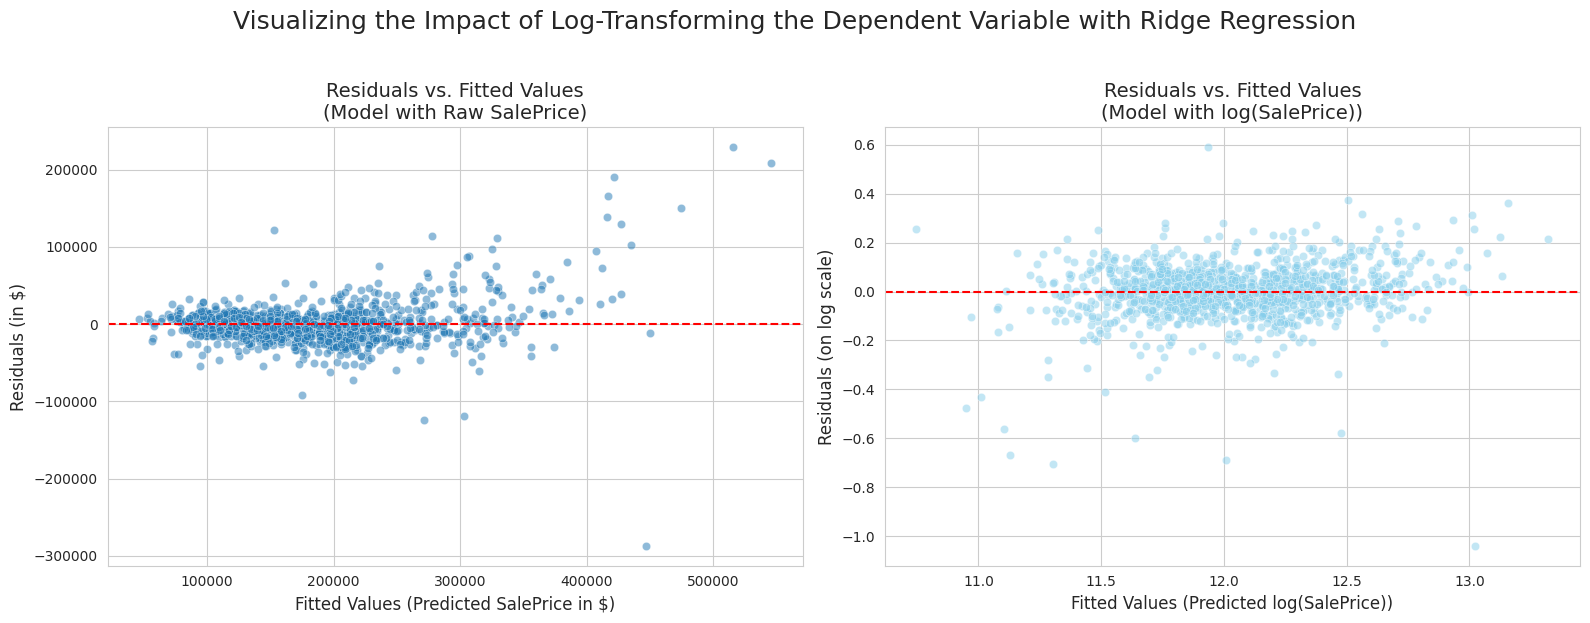

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV # Assuming hyperParameterSearch uses this
from scipy.stats import loguniform

# --- Step 1: Prepare Data and Models ---

# Define your features and both target variables
X = trainDfEncoded.drop(columns=["SalePrice"])
y_raw = trainDfEncoded["SalePrice"]
y_log = np.log(y_raw)

# --- A) MODEL FOR RAW Y: We need to find the best Ridge model for raw SalePrice ---
# This ensures a fair comparison by using an optimized model for the "before" case.
print("Finding best Ridge model for Raw SalePrice...")
scaler_raw = StandardScaler()
X_scaled_raw = scaler_raw.fit_transform(X)
param_distributions_raw = {'alpha': loguniform(1e-2, 1e4)}
# Assuming hyperParameterSearch is like RandomizedSearchCV
hyperParameterSearch_raw = RandomizedSearchCV(
    Ridge(), param_distributions_raw, n_iter=50, cv=5, random_state=42, scoring='neg_mean_squared_error'
)
hyperParameterSearch_raw.fit(X_scaled_raw, y_raw)
estimator_raw_y = hyperParameterSearch_raw.best_estimator_
print(f"Best alpha for raw Y model: {estimator_raw_y.alpha:.4f}")

# --- B) MODEL FOR LOG Y: This is the 'estimator' you already have from your code ---
print("\nFinding best Ridge model for log(SalePrice)...")
scaler_log = StandardScaler()
X_scaled_log = scaler_log.fit_transform(X) # Can use the same scaled data
param_distributions_log = {'alpha': loguniform(1e-7, 1e3)}
hyperParameterSearch_log = RandomizedSearchCV(
    Ridge(), param_distributions_log, n_iter=50, cv=5, random_state=42, scoring='neg_mean_squared_error'
)
hyperParameterSearch_log.fit(X_scaled_log, y_log)
estimator_log_y = hyperParameterSearch_log.best_estimator_ # This is equivalent to your 'estimator'
print(f"Best alpha for log Y model: {estimator_log_y.alpha:.4f}")


# --- Step 2: Get Fitted Values and Residuals for Both Models ---

# For the Raw Y Model
fitted_raw = estimator_raw_y.predict(X_scaled_raw)
residuals_raw = y_raw - fitted_raw

# For the Log Y Model
fitted_log = estimator_log_y.predict(X_scaled_log)
residuals_log = y_log - fitted_log


# --- Step 3: Create the side-by-side plots ---

# Set up the plot style
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Residuals vs. Fitted for the Raw Y Model
sns.scatterplot(x=fitted_raw, y=residuals_raw, ax=axes[0], alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs. Fitted Values\n(Model with Raw SalePrice)', fontsize=14)
axes[0].set_xlabel("Fitted Values (Predicted SalePrice in $)", fontsize=12)
axes[0].set_ylabel("Residuals (in $)", fontsize=12)

# Plot 2: Residuals vs. Fitted for the Log Y Model
sns.scatterplot(x=fitted_log, y=residuals_log, ax=axes[1], alpha=0.5, color='skyblue')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Residuals vs. Fitted Values\n(Model with log(SalePrice))', fontsize=14)
axes[1].set_xlabel("Fitted Values (Predicted log(SalePrice))", fontsize=12)
axes[1].set_ylabel("Residuals (on log scale)", fontsize=12)

# Add a main title for the entire figure
fig.suptitle('Visualizing the Impact of Log-Transforming the Dependent Variable with Ridge Regression', fontsize=18, y=1.03)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Residuals look more constant variance.


Standardizing before hand also tended to help and show improvements in ridge, though not as much in lasso - as expected more pronounced in ridge (since it's squared weights) versus absolute values.

In [172]:
# elasticNet scaled input, log output

from scipy.stats import loguniform, uniform
from sklearn.linear_model import ElasticNet


param_distributions = {
    'alpha': loguniform(1e-7, 1000),  # Overall regularization strength
    'l1_ratio': uniform(0, 1)        # The mix between L1 and L2 (from 0 to 1)
}

scaler = StandardScaler()
scaler.fit(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy())

estimator = hyperParameterSearch(param_distributions, ElasticNet(), scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, scaler.transform(trainDfEncoded.drop(columns=["SalePrice"]).to_numpy()), trainDfEncoded["SalePrice"].to_numpy())

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(0.48370848398201904),
  'l1_ratio': np.float64(0.013256058562268636)},
 30018.44355483119)

In [173]:
# final test set for our best performer:
from scipy.stats import loguniform
from sklearn.linear_model import Ridge


param_distributions = {
    'alpha': loguniform(0.0000001, 1000), 
}

estimator = hyperParameterSearch(param_distributions, Ridge(), trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), np.log(trainDfEncoded["SalePrice"].to_numpy()))
estimator.best_params_, getScoreLogYInRawForm(estimator, trainDfEncoded.drop(columns=["SalePrice"]).to_numpy(), trainDfEncoded["SalePrice"].to_numpy())


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


({'alpha': np.float64(8.870400311035638)}, 25915.032166685152)

In [174]:
# define pipeline 
preprocess_feature_engineer = Pipeline(
    steps= [
        ("clean_and_fix_data", FunctionTransformer(clean_and_fix_data)),
        ("encode_categorical", FunctionTransformer(encode_categorical, kw_args={"encoder": encoder, "categorical_features": categorical_features, "numerical_features": numerical_features})),
        ("lot_frontage_imputer", FunctionTransformer(lot_frontage_imputer, kw_args={"lot_frontage_regressor": lot_frontage_regressor, "columns_with_na": columns_with_na_original})),
        ('garage_age_feature_creator', FunctionTransformer(garage_age_feature_creator)),
        ("fill_na_mas_vnr_area_zero", FunctionTransformer(fill_na_mas_vnr_area_zero)),
        
    ]
)

# do transformations to get it
testDataEncoded = preprocess_feature_engineer.transform(testData)
testDataEncodedX = testDataEncoded.drop(columns=["SalePrice"])
testDataEncodedY = testDataEncoded["SalePrice"]
# run by best estimator
getScoreLogYInRawForm(estimator, testDataEncodedX.to_numpy(), testDataEncodedY.to_numpy())

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 11, 32, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


20462.971005276973

In [175]:

getScoreLogYInRawForm(estimator, np.concat([testDataEncodedX, trainDfEncoded.drop(columns=["SalePrice"])]), np.concat([testDataEncodedY,trainDfEncoded["SalePrice"]]))

24919.532273371253

## High scale Training
For large datasets, we look at how our two methods (batch or stochastic gradient descent) and the analytical solution scale in terms of memory or compute time.


### Analytical Solution
For linear regression, the analytical solution $(X^TX)^{-1} X^T y$ has an overall memory complexity of:

$O(n \cdot p + p^2)$

And an overall time complexity of:

$O(n \cdot p^2 + p^3)$

### Stochastic or Batch Gradient Descent
Memory complexity of:
$ O(BatchSize \cdot p) $

Overall time complexity of:
$ O(NIter \cdot BatchSize \cdot p) $

### Thoughts
Theres some work done to bound the number of iterations for gradient descent but its not a simple polynomial that can be compared to analytical, however you can get a sense of when analytical won't work (particularly very large number of features as its cubic in that direction for time and quadratic for space). Particularly imagine 10,000 features, with perhaps 100,000 examples ~ TBs of memory required. In constrast this could be done with gradient based methods requiring memory in the MB scale.

### High Scale with Spark
To scale beyond the single machine set up, spark is the standard production grade technology. Here we will spin up a spark cluster and run a job to do gradient descent.

In [176]:
# lets try a bigger dataset to see where sci-kit learn breaks
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

In [3]:
import os
import requests
from pathlib import Path
from tqdm import tqdm

def download_taxi_data(year=2022, months=range(1, 13)):
    """
    Downloads the NYC Yellow Taxi trip data for a given year and months.

    Args:
        year (int): The year of the data to download.
        months (iterable): An iterable of month numbers (e.g., range(1, 13) for all months).
    """
    BASE_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata"
    
    # Create a directory to store the data, if it doesn't exist
    output_dir = Path('./.data/')
    output_dir.mkdir(exist_ok=True)
    
    print(f"Downloading data for year {year} into '{output_dir}' directory...")
    
    for month in months:
        # Format the month to be two digits (e.g., 01, 02, ..., 12)
        fmonth = f"{month:02d}"
        
        # Construct the full URL and the local file path
        url = f"{BASE_URL}_{year}-{fmonth}.parquet"
        file_path = output_dir / f"yellow_tripdata_{year}-{fmonth}.parquet"
        
        # Check if the file already exists to avoid re-downloading
        if file_path.exists():
            print(f"File {file_path.name} already exists. Skipping.")
            continue
            
        print(f"\nDownloading {file_path.name}...")
        
        try:
            # Make a streaming request to the URL
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
            
            # Get the total file size from the headers
            total_size = int(response.headers.get('content-length', 0))
            
            # Use tqdm to create a progress bar
            with open(file_path, 'wb') as f, tqdm(
                desc=file_path.name,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=1024):
                    size = f.write(data)
                    bar.update(size)

        except requests.exceptions.RequestException as e:
            print(f"Error downloading {url}: {e}")
            # Clean up partially downloaded file if an error occurs
            if file_path.exists():
                os.remove(file_path)

    print("\nAll files downloaded successfully.")

In [4]:
if __name__ == "__main__":
    # This will run when you execute the script from the command line
    download_taxi_data(year=2022)

yellow_tripdata_2022-01.parquet: 100%|██████████| 36.4M/36.4M [00:02<00:00, 15.8MiB/s]


yellow_tripdata_2022-02.parquet: 100%|██████████| 43.5M/43.5M [00:03<00:00, 14.9MiB/s]


yellow_tripdata_2022-03.parquet: 100%|██████████| 53.1M/53.1M [00:03<00:00, 15.4MiB/s]


yellow_tripdata_2022-04.parquet: 100%|██████████| 52.7M/52.7M [00:03<00:00, 15.4MiB/s]


yellow_tripdata_2022-05.parquet: 100%|██████████| 53.0M/53.0M [00:03<00:00, 15.0MiB/s]


yellow_tripdata_2022-06.parquet: 100%|██████████| 52.8M/52.8M [00:03<00:00, 15.4MiB/s]


yellow_tripdata_2022-07.parquet: 100%|██████████| 47.1M/47.1M [00:03<00:00, 15.2MiB/s]


yellow_tripdata_2022-08.parquet: 100%|██████████| 47.4M/47.4M [00:03<00:00, 15.7MiB/s]


yellow_tripdata_2022-09.parquet: 100%|██████████| 47.3M/47.3M [00:03<00:00, 15.2MiB/s]


yellow_tripdata_2022-10.parquet: 100%|██████████| 54.4M/54.4M [00:03<00:00, 15.5MiB/s]


yellow_tripdata_2022-11.parquet: 100%|██████████| 47.8M/47.8M [00:03<00:00, 15.5MiB/s]


yellow_tripdata_2022-12.parquet: 100%|██████████| 51.2M/51.2M [00:03<00:00, 15.1MiB/s]


All files downloaded successfully.


In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

print("--- STARTING ULTIMATE FAILURE TEST: Loading 12 months of data ---")
print("!!! WARNING: This will consume all available RAM and SWAP. !!!")
print("!!! Your system will become unresponsive. This is expected. !!!")

try:
    # --- Step 1: Find all the parquet files we downloaded ---
    # This will look for all .parquet files in the 'taxi_data_2022' subdirectory
    path_to_data = './.data/*.parquet'
    all_files = glob.glob(path_to_data)
    
    if not all_files:
        raise FileNotFoundError("No parquet files found in 'taxi_data_2022'. Did you run the download script?")
        
    print(f"Found {len(all_files)} files to load.")

    # --- Step 2: Load and combine all files ---
    print("Loading and concatenating all files. This will take some time and memory...")
    list_of_dfs = [pd.read_parquet(f) for f in all_files]
    df = pd.concat(list_of_dfs, ignore_index=True)
    del list_of_dfs # Free up memory
    
    print(f"Successfully created combined DataFrame. Shape: {df.shape}")
    print("Memory usage of combined DataFrame:")
    df.info(memory_usage='deep')

    # --- Feature Engineering (same as before) ---
    print("\nStep 3: Performing feature engineering...")
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60.0

    # Filter for realistic trips
    df = df[(df['trip_duration'] > 1) & (df['trip_duration'] < 60)]
    df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 50)]
    df.dropna(subset=['PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance', 'trip_duration'], inplace=True)
    
    print(f"Shape after cleaning: {df.shape}")

    # --- Model Setup (same as before) ---
    y = df['trip_duration']
    X = df[['PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance']]
    
    del df # Free up memory of the full DataFrame

    categorical_features = ['PULocationID', 'DOLocationID']
    numerical_features = ['passenger_count', 'trip_distance']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='drop'
    )

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))
    ])
    
    # --- THE GUARANTEED FAILURE POINT ---
    print("\nStep 4: Fitting the pipeline on the full year's dataset...")
    print("This will now attempt to allocate over 200 GB of virtual memory.")
    model_pipeline.fit(X, y)

    print("\n--- Succeeded (Impossible on this machine!) ---")

except MemoryError:
    print("\n--- FAILED AS EXPECTED! ---")
    print("A MemoryError was caught. The full year of data is far too large to be processed in memory.")
except Exception as e:
    # The OS might kill the process so forcefully that Python can't even catch a MemoryError.
    # In that case, the script just stops, and your terminal might say "Killed".
    print(f"\n--- AN ERROR OCCURRED OR PROCESS WAS KILLED: {type(e).__name__} ---")
    print("This is the expected outcome due to extreme memory pressure.")
    print(e)

--- STARTING ULTIMATE FAILURE TEST: Loading 12 months of data ---
!!! WARNING: This will consume all available RAM and SWAP. !!!
!!! Your system will become unresponsive. This is expected. !!!
Found 12 files to load.
Loading and concatenating all files. This will take some time and memory...
Successfully created combined DataFrame. Shape: (39656098, 19)
Memory usage of combined DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39656098 entries, 0 to 39656097
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type   

: 

In [57]:
# okay let's create a sample of the data

In [58]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder.appName("LocalClientToDockerSpark") \
    .master(f"spark://spark-master:7077") \
    .getOrCreate()

In [59]:
full_dataset_path = f"./.data/*parquet"
full_df = spark.read.parquet(full_dataset_path)
full_df.count()
# todo mount for all bro

39656098

In [60]:
# 39 million rows cool
# we will sample to get 40k for local pipeline prototyping

In [61]:
sample_df = full_df.sample(fraction=0.001, seed=42)
sample_df.count()

39759

In [62]:
sample_df.coalesce(1).write.mode("overwrite").option("header", "true").csv("./.data/sample.csv")

In [63]:
import pandas as pd
import glob
file_path = glob.glob("./.data/sample.csv/*.csv")[0]
df_sample = pd.read_csv(file_path)

In [64]:
df_sample.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01T01:18:08.000,2022-01-01T01:40:49.000,2.0,5.70,1.0,N,249,49,1,20.0,3.0,0.5,4.75,0.0,0.3,28.55,2.5,0.0
1,2,2022-01-01T01:28:57.000,2022-01-01T01:39:49.000,1.0,2.42,1.0,N,79,233,1,10.0,0.5,0.5,4.14,0.0,0.3,17.94,2.5,0.0
2,1,2022-01-01T01:17:49.000,2022-01-01T01:35:19.000,1.0,2.60,1.0,N,90,148,1,13.0,3.0,0.5,2.00,0.0,0.3,18.80,2.5,0.0
3,1,2022-01-01T01:18:09.000,2022-01-01T01:31:23.000,3.0,0.90,1.0,N,48,50,1,9.0,3.0,0.5,1.00,0.0,0.3,13.80,2.5,0.0
4,1,2022-01-01T02:29:31.000,2022-01-01T02:41:54.000,2.0,4.10,1.0,N,80,97,1,14.0,0.5,0.5,10.00,0.0,0.3,25.30,0.0,0.0


In [65]:
# lets check for nas per feature
df_sample.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,39759.000000,38375.000000,39759.000000,38375.000000,39759.000000,39759.000000,39759.000000,3.975900e+04,39759.000000,39759.000000,3.975900e+04,39759.000000,39759.000000,39759.000000,38375.000000,38375.000000
mean,1.720944,1.394163,3.506174,1.384469,165.078372,162.578661,1.193491,-1.103459e+03,1.015568,0.488941,1.121088e+03,0.555897,0.315861,21.726851,2.288404,0.095733
std,0.486212,0.961660,4.491675,5.461048,65.316916,70.443291,0.527776,2.229917e+05,1.267327,0.091646,2.229917e+05,2.086336,0.127626,18.132061,0.737235,0.335834
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-4.446377e+07,-4.500000,-0.500000,-8.600000e-01,-11.750000,-1.000000,-250.300000,-2.500000,-1.250000
25%,1.000000,1.000000,1.100000,1.000000,132.000000,113.000000,1.000000,7.000000e+00,0.000000,0.500000,8.200000e-01,0.000000,0.300000,12.300000,2.500000,0.000000
50%,2.000000,1.000000,1.900000,1.000000,162.000000,162.000000,1.000000,1.050000e+01,0.500000,0.500000,2.160000e+00,0.000000,0.300000,15.960000,2.500000,0.000000
75%,2.000000,1.000000,3.560000,1.000000,234.000000,234.000000,1.000000,1.650000e+01,2.500000,0.500000,3.390000e+00,0.000000,0.300000,23.160000,2.500000,0.000000
max,6.000000,7.000000,75.790000,99.000000,265.000000,265.000000,4.000000,5.000000e+02,9.750000,0.800000,4.446379e+07,65.580000,1.000000,500.300000,2.500000,1.250000


In [66]:
df_sample.isna().sum(axis=0)

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          1384
trip_distance               0
RatecodeID               1384
store_and_fwd_flag       1384
PULocationID                0
DOLocationID                0
payment_type                0
fare_amount                 0
extra                       0
mta_tax                     0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     1384
airport_fee              1384
dtype: int64

In [67]:
# let's identify a good response.
# vendor id is categorical for company managing the tracking system in the cab.
# tpep times are official times from the tracking system.
# passenger count is self explanatory.
# trip_distance is in miles
# RatecodeID rate code at END of the trip - different from just distance, perhaps flat charge or otherwise
# store_and_fwd_flag is whether or not was cached locally then sent or sent upon creation of record
# PU/DO location is pick up drop off ids
# fare_amount time and distance meter based
# tip cash not included
# other charges 

In [68]:
# seems like fare amount seems the best option - total amount should just be a sum of others so we should remove it as well.
# let's split up our data properly
from sklearn.model_selection import train_test_split
df_sample, df_sample_test = train_test_split(df_sample, test_size=0.2)

In [69]:
df_sample.shape, df_sample_test.shape

((31807, 19), (7952, 19))

In [70]:
# VendorID seems irrelevant to the task so I will drop it
# as well as response and surcharges, taxes, payment type that may be leakage

from sklearn.pipeline import FunctionTransformer, Pipeline

def drop_columns(df):
    df_new = df.copy()
    df_new = df_new.drop(columns=["total_amount", "VendorID", "tip_amount", "tolls_amount", "payment_type", "extra", "mta_tax", "improvement_surcharge", "congestion_surcharge", "airport_fee"])
    return df_new

pipeline = Pipeline(steps=[
    ("dropper", FunctionTransformer(drop_columns))
])

In [71]:
df_sample = pipeline.fit_transform(df_sample)

In [72]:
df_sample.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'fare_amount'],
      dtype='object')

In [73]:
# lets handle tpep_pickup_datetime and tpep_dropoff_datetime, naturally time
df_sample_analysis = df_sample.copy()
df_sample_analysis["tpep_dropoff_datetime_converted"] = pd.to_datetime(df_sample_analysis['tpep_dropoff_datetime'])
df_sample_analysis["tpep_pickup_datetime_converted"] = pd.to_datetime(df_sample_analysis['tpep_pickup_datetime'])

In [74]:
df_sample_analysis["trip_minutes"] = (df_sample_analysis["tpep_dropoff_datetime_converted"] - df_sample_analysis["tpep_pickup_datetime_converted"]).dt.total_seconds() / 60

In [75]:
df_sample_analysis["trip_minutes"].describe()

count    31807.000000
mean        17.474029
std         51.320456
min         -0.583333
25%          7.400000
50%         12.266667
75%         19.900000
max       1439.333333
Name: trip_minutes, dtype: float64

<Axes: >

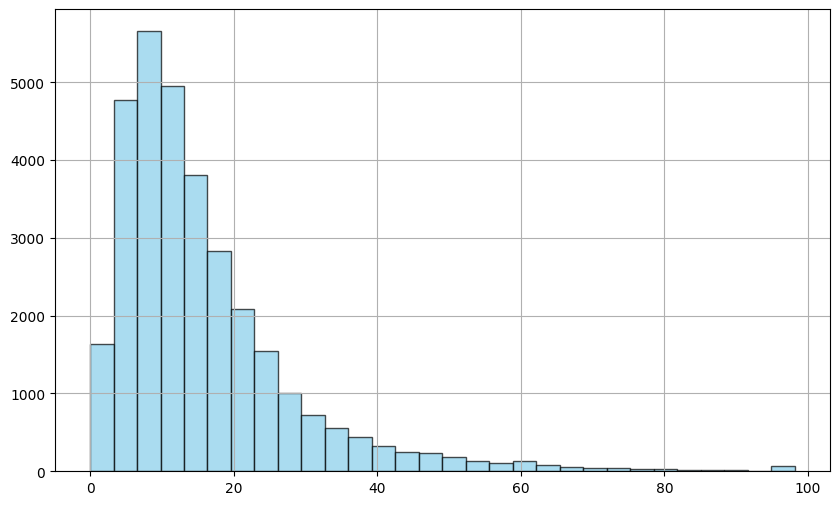

In [76]:
# we want to drop impossible values and clip to some reasonable quantile
df_sample_analysis = df_sample_analysis[df_sample_analysis["trip_minutes"] >= 0].copy()
upper_threshold_duration = df_sample_analysis['trip_minutes'].quantile(0.998)

df_sample_analysis['trip_minutes'] = df_sample_analysis['trip_minutes'].clip(upper=upper_threshold_duration)

df_sample_analysis["trip_minutes"].hist(
    bins=30,         # Number of bins (adjust as needed)
    figsize=(10, 6),  # Figure size (width, height) in inches
    color='skyblue',   # Color of the bars
    edgecolor='black',  # Color of the bar edges
    alpha=0.7       # Transparency of the bars (0.0 to 1.0)
)


In [77]:
df_sample.shape[0] - df_sample_analysis.shape[0]

7

In [78]:
# lost 126 error rows - no big deal though
# let's now make into pipeline
def create_duration(df, upper_threshold):
    df_out = df.copy()
    df_out["tpep_dropoff_datetime_converted"] = pd.to_datetime(df_out['tpep_dropoff_datetime'])
    df_out["tpep_pickup_datetime_converted"] = pd.to_datetime(df_out['tpep_pickup_datetime'])
    df_out["trip_minutes"] = (df_out["tpep_dropoff_datetime_converted"] - df_out["tpep_pickup_datetime_converted"]).dt.total_seconds() / 60
    df_out = df_out[df_out["trip_minutes"] >= 0].copy()
    df_out['trip_minutes'] = df_out['trip_minutes'].clip(upper=upper_threshold)
    df_out = df_out.drop(columns=["tpep_dropoff_datetime_converted", "tpep_pickup_datetime_converted", "tpep_dropoff_datetime", "tpep_pickup_datetime"])
    return df_out

pipeline = Pipeline(steps=[
    ('create_dureation', FunctionTransformer(create_duration, kw_args={"upper_threshold": upper_threshold_duration}))
])
df_sample = pipeline.fit_transform(df_sample)

In [79]:
df_sample.isna().sum()

passenger_count       1103
trip_distance            0
RatecodeID            1103
store_and_fwd_flag    1103
PULocationID             0
DOLocationID             0
fare_amount              0
trip_minutes             0
dtype: int64

In [80]:
df_sample_analysis = df_sample.copy()
# passenger count
## imputation doesn't sound too bad for passenger to be honest - median.
df_sample_analysis["passenger_count"] = df_sample_analysis["passenger_count"].fillna(df_sample_analysis["passenger_count"].median())
df_sample_analysis["RatecodeID"] = df_sample_analysis["RatecodeID"].fillna(df_sample_analysis["RatecodeID"].mode()[0])
df_sample_analysis["store_and_fwd_flag"] = df_sample_analysis["store_and_fwd_flag"].fillna(df_sample_analysis["store_and_fwd_flag"].mode()[0])

In [81]:
df_sample = df_sample_analysis
# as ref:

"""
1 = Standard rate
2 = JFK
3 = Newark
4 = Nassau or Westchester
5 = Negotiated fare
6 = Group ride
99 = Null/unknown
 """
df_sample_analysis["RatecodeID"].value_counts()

RatecodeID
1.0     30104
2.0      1212
5.0       244
99.0      101
3.0        99
4.0        40
Name: count, dtype: int64

In [82]:
df_sample_analysis["store_and_fwd_flag"].value_counts()

store_and_fwd_flag
N    31405
Y      395
Name: count, dtype: int64

In [83]:
pc_median = df_sample_analysis["passenger_count"].median()
rate_code_mode = df_sample_analysis["RatecodeID"].mode()[0]
store_and_fwd_mode = df_sample_analysis["store_and_fwd_flag"].mode()[0]

In [84]:
def impute_values(df, pc_median, rate_code_mode, store_and_fwd_mode):
    df_out = df.copy()
    df_out["passenger_count"] = df_out["passenger_count"].fillna(pc_median)
    df_out["RatecodeID"] = df_out["RatecodeID"].fillna(rate_code_mode)
    df_out["store_and_fwd_flag"] = df_out["store_and_fwd_flag"].fillna(store_and_fwd_mode)
    return df_out

pipeline = Pipeline(
    steps= [
        ("impute_values", FunctionTransformer(impute_values, kw_args={'pc_median': pc_median, 'rate_code_mode': rate_code_mode, 'store_and_fwd_mode': store_and_fwd_mode}))
    ]
)
df_sample = pipeline.fit_transform(df_sample)

In [85]:
df_sample["store_and_fwd_flag"].value_counts()

store_and_fwd_flag
N    31405
Y      395
Name: count, dtype: int64

In [86]:
df_sample["trip_distance"].describe()

count    31800.000000
mean         3.495702
std          4.482288
min          0.000000
25%          1.100000
50%          1.900000
75%          3.530000
max         75.790000
Name: trip_distance, dtype: float64

In [87]:
outlier = df_sample['trip_distance'].quantile(0.9999)
outlier

np.float64(60.58863999998197)

In [88]:
def drop_outlier_milage(df, upper_threshold):
    return df[df["trip_distance"] <= upper_threshold].copy()

pipeline = Pipeline(
    steps= [
        ('drop_outlier_mileage', FunctionTransformer(drop_outlier_milage, kw_args={"upper_threshold": 100}))
    ]
)

df_sample = pipeline.fit_transform(df_sample)

In [89]:
df_sample["trip_distance"].describe()

count    31800.000000
mean         3.495702
std          4.482288
min          0.000000
25%          1.100000
50%          1.900000
75%          3.530000
max         75.790000
Name: trip_distance, dtype: float64

In [90]:
# examine
df_sample["RatecodeID"].value_counts(normalize=True)

RatecodeID
1.0     0.946667
2.0     0.038113
5.0     0.007673
99.0    0.003176
3.0     0.003113
4.0     0.001258
Name: proportion, dtype: float64

In [91]:
df_sample.isna().sum()

passenger_count       0
trip_distance         0
RatecodeID            0
store_and_fwd_flag    0
PULocationID          0
DOLocationID          0
fare_amount           0
trip_minutes          0
dtype: int64

In [92]:
df_sample["DOLocationID"].value_counts(normalize=True)

DOLocationID
236    0.043774
237    0.040220
161    0.037327
230    0.029340
170    0.028994
         ...   
53     0.000031
172    0.000031
150    0.000031
109    0.000031
58     0.000031
Name: proportion, Length: 237, dtype: float64

In [93]:
df_sample["PULocationID"].value_counts(normalize=True)

PULocationID
132    0.047421
237    0.046509
236    0.043050
161    0.039591
142    0.033082
         ...   
101    0.000031
32     0.000031
20     0.000031
165    0.000031
220    0.000031
Name: proportion, Length: 175, dtype: float64

In [94]:
# group ride such a small porportion, could easily just ignore it but having it doesn't necessarily hurt and scaled to 40m * porportion is 700 examples, which isn't that bad.
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(
    handle_unknown='ignore', # Handle unseen categories in test data
    drop='first',            # Create k-1 dummies, dropping the first category
    sparse_output=False      # Output a dense numpy array
)

featuresToEncode = ["RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID"]
encoder.fit(df_sample[featuresToEncode])

encoded_categorical_data = encoder.transform(df_sample[featuresToEncode])
encoded_feature_names = encoder.get_feature_names_out()
encoded_categorical_df = pd.DataFrame(
    encoded_categorical_data, 
    columns=encoded_feature_names, 
    index=df_sample.index
)
encoded_categorical_df

df_sample_analysis = pd.concat([
    df_sample[[item for item in df_sample.columns if item not in featuresToEncode]],
    encoded_categorical_df,
], axis=1)

In [95]:
df_sample_analysis.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'trip_minutes',
       'RatecodeID_2.0', 'RatecodeID_3.0', 'RatecodeID_4.0', 'RatecodeID_5.0',
       'RatecodeID_99.0', 'store_and_fwd_flag_Y',
       ...
       'DOLocationID_256', 'DOLocationID_257', 'DOLocationID_258',
       'DOLocationID_259', 'DOLocationID_260', 'DOLocationID_261',
       'DOLocationID_262', 'DOLocationID_263', 'DOLocationID_264',
       'DOLocationID_265'],
      dtype='object', length=420)

In [96]:
def encode_categorical_features(df, encoder):
    featuresToEncode = ["RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID"]
    df_out = df.copy()
    encoded_categorical_data = encoder.transform(df_out[featuresToEncode])
    encoded_feature_names = encoder.get_feature_names_out()
    encoded_categorical_df = pd.DataFrame(
        encoded_categorical_data, 
        columns=encoded_feature_names, 
        index=df_out.index
    )
    return pd.concat([
        df_out[[item for item in df_out.columns if item not in featuresToEncode]],
        encoded_categorical_df,
    ], axis=1)

pipeline = Pipeline(
    steps = [
        ('encode_categorical_features', FunctionTransformer(encode_categorical_features, kw_args={"encoder": encoder}))
    ]
)

df_sample = pipeline.fit_transform(df_sample)


In [97]:
(df_sample["fare_amount"] < 0).mean()
# wierd fare amount thing but less than 1 percent of the data, I think i should just ignore these for training and test
pipeline = Pipeline(
    steps=[
        ('ignore_negative_fare', FunctionTransformer(lambda x: x[x["fare_amount"] > 0].copy()))
    ]
)
df_sample = pipeline.fit_transform(df_sample)

In [98]:
df_sample["fare_amount"].describe()

count    31595.000000
mean        15.046021
std         14.500938
min          0.010000
25%          7.000000
50%         10.500000
75%         16.500000
max        500.000000
Name: fare_amount, dtype: float64

In [99]:
# 400 seems like a lot to be honest.
print(df_sample["fare_amount"].quantile(.995))
# sounds like we should cut perhaps the top off for training purposes. like > 100 seems fair outlier detection
pipeline = Pipeline(
    steps=[
        ('fare_remove_outliers', FunctionTransformer(lambda x: x[x["fare_amount"] <= 100].copy()))
    ]
)
pipeline.fit_transform(df_sample).shape, df_sample.shape

72.5


((31542, 420), (31595, 420))

In [100]:
df_sample = pipeline.fit_transform(df_sample)
# for training only this step but yeah

In [101]:
# now lets build the complete pipeline
pipeline_inference = Pipeline(
    steps=[
        ("dropper", FunctionTransformer(drop_columns)),
        (
            "create_duration",
            FunctionTransformer(
                create_duration, kw_args={"upper_threshold": upper_threshold_duration}
            ),
        ),
        (
            "impute_values",
            FunctionTransformer(
                impute_values,
                kw_args={
                    "pc_median": pc_median,
                    "rate_code_mode": rate_code_mode,
                    "store_and_fwd_mode": store_and_fwd_mode,
                },
            ),
        ),
        (
            "drop_outlier_mileage",
            FunctionTransformer(drop_outlier_milage, kw_args={"upper_threshold": 100}),
        ),
        (
            "encode_categorical_features",
            FunctionTransformer(
                encode_categorical_features, kw_args={"encoder": encoder}
            ),
        ),
        (
            "ignore_negative_fare",
            FunctionTransformer(lambda x: x[x["fare_amount"] > 0].copy()),
        ),
    ]
)

df_sample_test = pipeline_inference.fit_transform(df_sample_test)

/opt/bitnami/python/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [102]:
pipeline_inference

Pipeline(steps=[('dropper',
                 FunctionTransformer(func=<function drop_columns at 0xffff8cfcc360>)),
                ('create_duration',
                 FunctionTransformer(func=<function create_duration at 0xffff8c36bb00>,
                                     kw_args={'upper_threshold': np.float64(98.14429999999915)})),
                ('impute_values',
                 FunctionTransformer(func=<function impute_values at 0xffff8c36bd80>,
                                     kw_args={'pc_median': np.float...
                 FunctionTransformer(func=<function drop_outlier_milage at 0xffff8c36b920>,
                                     kw_args={'upper_threshold': 100})),
                ('encode_categorical_features',
                 FunctionTransformer(func=<function encode_categorical_features at 0xffff8c36bec0>,
                                     kw_args={'encoder': OneHotEncoder(drop='first',
                                                                       handle_unknown='ignore',
                                                                       sparse_output=False)})),
                ('ignore_negative_fare',
                 FunctionTransformer(func=<function <lambda> at 0xffff8c3980e0>))])

In [103]:
# fare amount transformation test
## lets see if a basic model will do better with log or no log
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

trainX = df_sample[[col for col in df_sample.columns if col != "fare_amount"]]
trainY = df_sample["fare_amount"]

testX, testY = df_sample_test[[col for col in df_sample_test.columns if col != "fare_amount"]], df_sample_test["fare_amount"]

model_raw = LinearRegression()
model_raw.fit(trainX, trainY)

# Get predictions on the test set (already in dollars)
y_pred_raw = model_raw.predict(testX)

# Calculate R2 and RMSE on the original dollar scale
r2_raw = r2_score(testY, y_pred_raw)
rmse_raw = np.sqrt(mean_squared_error(testY, y_pred_raw))

print("--- Model 1 Results (Predicting fare_amount) ---")
print(f"Test R²: {r2_raw:.4f}")
print(f"Test RMSE: ${rmse_raw:,.2f}")


# --- Model 2: Trained on Log Scale, Evaluated on Original Scale ---
model_log = LinearRegression()
# Fit the model on the log of the training target
model_log.fit(trainX, np.log(trainY))

# Get predictions on the test set (these will be on the log scale)
y_pred_log_scale = model_log.predict(testX)

# Back-transform the predictions to the original dollar scale
y_pred_dollar_scale = np.exp(y_pred_log_scale)

# Calculate R2 and RMSE using the back-transformed predictions and the original testY
r2_log = r2_score(testY, y_pred_dollar_scale)
rmse_log = np.sqrt(mean_squared_error(testY, y_pred_dollar_scale))

print("\n--- Model 2 Results (Predicting log(fare_amount)) ---")
print(f"Test R² (back-transformed): {r2_log:.4f}")
print(f"Test RMSE (back-transformed): ${rmse_log:,.2f}")

print("\n--- Comparison ---")
if rmse_log < rmse_raw:
    print("The model trained on log(fare_amount) has a lower RMSE and is the better predictive model.")
else:
    print("The model trained on the raw fare_amount has a lower RMSE and is the better predictive model.")

--- Model 1 Results (Predicting fare_amount) ---
Test R²: 0.8706
Test RMSE: $5.03

--- Model 2 Results (Predicting log(fare_amount)) ---
Test R² (back-transformed): -40.7154
Test RMSE (back-transformed): $90.34

--- Comparison ---
The model trained on the raw fare_amount has a lower RMSE and is the better predictive model.


In [104]:
# log looks terrible - we will stick to fare_amount raw as response.
# let's try standardization

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

scaling_columns = [x for x in trainX.columns if x[:2] not in ['Ra', 'DO', 'PU', 'st']]
trainXScaled = trainX.copy()

trainXScaled[scaling_columns] = scaler.fit_transform(trainX[scaling_columns])

model_scaled = LinearRegression()
model_scaled.fit(trainXScaled, trainY)

LinearRegression()

In [105]:
testXScaled = testX.copy()
testXScaled[scaling_columns] = scaler.transform(testXScaled[scaling_columns])
model_scaled.score(testXScaled, testY)


0.8705944970628291

In [106]:
# not much better from an R^2 point of view (as expected, didn't change underlying relationship) so we should search with ridge regression and scaling CV for generalization performance.
# so lets build the entire pipeline from raw data to a hyper parameter tuned linear regression model with cross validation - then run it on our test set - this will serve as the model process we will scale to spark.
## we will have a raw data to feature pipeline and then include it in a training data to hyper parameter tuned model (and give us some pointers on ranges to try to scale up to all the data)
## raw data to features

def scale_continous(df, scaler, columns):
    df_out = df.copy()
    df_out[columns] = scaler.transform(df_out[columns])
    return df_out

raw_data_to_features_pipeline = Pipeline(
    steps=[
        ("dropper", FunctionTransformer(drop_columns)),
        (
            "create_duration",
            FunctionTransformer(
                create_duration, kw_args={"upper_threshold": upper_threshold_duration}
            ),
        ),
        (
            "impute_values",
            FunctionTransformer(
                impute_values,
                kw_args={
                    "pc_median": pc_median,
                    "rate_code_mode": rate_code_mode,
                    "store_and_fwd_mode": store_and_fwd_mode,
                },
            ),
        ),
        (
            "drop_outlier_mileage",
            FunctionTransformer(drop_outlier_milage, kw_args={"upper_threshold": 100}),
        ),
        (
            "encode_categorical_features",
            FunctionTransformer(
                encode_categorical_features, kw_args={"encoder": encoder}
            ),
        ),
        (
            "ignore_negative_fare",
            FunctionTransformer(lambda x: x[x["fare_amount"] > 0].copy()),
        ),
        (
            "scale_continous",
            FunctionTransformer(scale_continous, kw_args={"scaler": scaler, "columns": scaling_columns}),
        ),
    ]
)

In [107]:
# rebuild from raw
df_sample = pd.read_csv(file_path)
from sklearn.model_selection import train_test_split
df_sample, df_sample_test = train_test_split(df_sample, test_size=0.8)

In [108]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from scipy.stats import loguniform

df_sample = raw_data_to_features_pipeline.fit_transform(df_sample)

full_modeling_pipeline = Pipeline(steps=[
    ('regressor', Ridge())
])


param_distributions = {
    'regressor__alpha': loguniform(0.0000001, 1000), 
}

grid_search = RandomizedSearchCV(
    estimator=full_modeling_pipeline,
    param_distributions=param_distributions,
    n_iter=1000,  
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(df_sample[[col for col in df_sample.columns if col != "fare_amount"]], df_sample["fare_amount"])

/opt/bitnami/python/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5, estimator=Pipeline(steps=[('regressor', Ridge())]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'regressor__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0xffff8d7b8260>},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [109]:
best_model = grid_search.best_estimator_
print("\nThe Best Model Pipeline:")
print(best_model)
best_cv_score = grid_search.best_score_
print(f"Best Cross-Validated Score: {best_cv_score:.4f}")


The Best Model Pipeline:
Pipeline(steps=[('regressor', Ridge(alpha=np.float64(6.71906784439569)))])
Best Cross-Validated Score: -5.5979


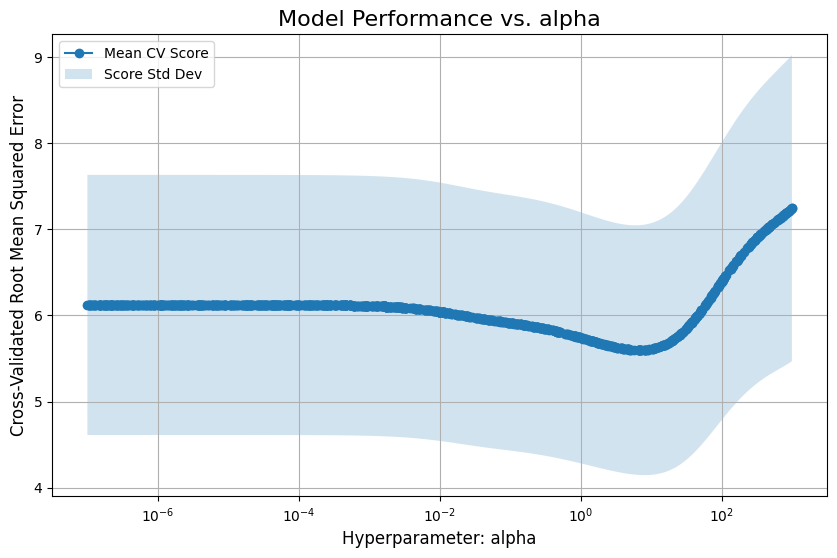

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_random_search_results_1d(random_search, param_name, log_scale=True):
    """
    Plots the results of a 1D RandomizedSearchCV, sorting the values
    to create a clean line plot.

    Args:
        random_search: The fitted RandomizedSearchCV object.
        param_name (str): The name of the hyperparameter that was tuned.
        log_scale (bool): Whether to plot the hyperparameter on a log scale.
    """
    # Extract results into a DataFrame
    cv_results = pd.DataFrame(random_search.cv_results_)

    # --- THE KEY FIX: Sort the DataFrame by the hyperparameter value ---
    param_col_name = f'param_{param_name}'
    cv_results = cv_results.sort_values(by=param_col_name)
    # --------------------------------------------------------------------

    # Get the mean and standard deviation of the validation scores
    mean_scores = cv_results['mean_test_score']
    std_scores = cv_results['std_test_score']
    
    # Get the sorted hyperparameter values
    params = cv_results[param_col_name]

    # Flip the sign of the scores if they are negative
    if random_search.scoring.startswith('neg_'):
        mean_scores = -mean_scores
        score_label = random_search.scoring[4:].replace('_', ' ').title()
    else:
        score_label = random_search.scoring.replace('_', ' ').title()

    plt.figure(figsize=(10, 6))
    
    # Now that 'params' and 'mean_scores' are sorted, the plot will be a clean line
    plt.plot(params, mean_scores, 'o-', label='Mean CV Score')
    
    # Plot the uncertainty band
    plt.fill_between(params, mean_scores - std_scores, mean_scores + std_scores, 
                     alpha=0.2, label='Score Std Dev')

    plt.title(f"Model Performance vs. {param_name.split('__')[-1]}", fontsize=16)
    plt.xlabel(f"Hyperparameter: {param_name.split('__')[-1]}", fontsize=12)
    plt.ylabel(f"Cross-Validated {score_label}", fontsize=12)
    
    if log_scale:
        plt.xscale('log')
        
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Example Usage ---
# Assuming 'grid_search' is your fitted RandomizedSearchCV object from the Ridge model
# and you tuned 'regressor__alpha'
if 'grid_search' in locals():
    plot_random_search_results_1d(grid_search, 'regressor__alpha', log_scale=True)

In [111]:
# interesting the optimal looks around 0.01 to 100, probably a good place to check. in full run
df_sample_test = raw_data_to_features_pipeline.transform(df_sample_test)

/opt/bitnami/python/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [115]:
from sklearn.metrics import root_mean_squared_error
y_test_predicted = grid_search.best_estimator_.predict(df_sample_test[[col for col in df_sample_test.columns if col != "fare_amount"]])
-1 * root_mean_squared_error(df_sample_test["fare_amount"], y_test_predicted)

-5.762027157147309

In [116]:
# since I tested the sample it can be the seed starting point for the pipeline to scale up, then I can explore different things (like what if I drop, what if I change imputation strategy)
# if i run into an error or something else I can debug and decide it then, sample should have taken care of most of snags though
# we should build seperate pipelines for data splitter (test set vs training),  feature engineering (produce features, and statistics for inference/training pipeline) , then model training, then a pipeline for inference.

In [7]:
spark.stop()

In [8]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder.appName("DatasetSplitter") \
    .master(f"spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

In [9]:
def create_train_test_split(spark, config):
    """
    Reads the full raw dataset, performs a train/test split,
    and writes the splits back to a persistent location.

    Args:
        spark (SparkSession): The active SparkSession.
        config (dict): A dictionary containing configuration parameters like
                       input_path, train_output_path, test_output_path, etc.
    """
    print("--- Starting Data Splitting Job ---")

    # --- 1. Load the Full Raw Dataset ---
    print(f"Reading full dataset from: {config['input_path']}")
    full_df = spark.read.parquet(config['input_path']).repartition(500)
    
    total_count = full_df.count()
    print(f"Successfully loaded full dataset with {total_count:,} rows.")

    # --- 3. Perform the Train/Test Split ---
    train_fraction = config.get('train_fraction', 0.8)
    test_fraction = 1.0 - train_fraction
    seed = config.get('seed', 42)
    
    print(f"Splitting data into {train_fraction*100}% train and {test_fraction*100}% test sets...")
    
    train_df, test_df = full_df.randomSplit([train_fraction, test_fraction], seed=seed)
    

    full_df.unpersist()
    

    print(f"\nWriting training data to: {config['train_output_path']}")
    train_df.write.mode("overwrite").parquet(config['train_output_path'])
    
    print(f"Writing test data to: {config['test_output_path']}")
    test_df.write.mode("overwrite").parquet(config['test_output_path'])

    print("\n--- Data Splitting Job Finished Successfully! ---")

create_train_test_split(spark, {
    "input_path": "/home/jovyan/workspace/.data/*parquet",
    "train_output_path": "/home/jovyan/workspace/.data/out_train_raw/",
    "test_output_path": "/home/jovyan/workspace/.data/out_test_raw/"
})

--- Starting Data Splitting Job ---
Reading full dataset from: /home/jovyan/workspace/.data/*parquet


Successfully loaded full dataset with 39,656,098 rows.
Splitting data into 80.0% train and 19.999999999999996% test sets...

Writing training data to: /home/jovyan/workspace/.data/out_train_raw/


Writing test data to: /home/jovyan/workspace/.data/out_test_raw/



--- Data Splitting Job Finished Successfully! ---


In [12]:
spark.stop()

In [14]:
import pandas as pd
import json
import os

from pyspark.ml import Estimator, Model, Transformer, Pipeline
from pyspark.ml.param.shared import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler


class RawFeatureCalculator(Transformer):
    """
    A stateless Transformer that performs initial calculations and creates a
    raw data quality report as a side effect.
    """

    def __init__(self):
        super(RawFeatureCalculator, self).__init__()

    def _transform(self, dataset):
        print("--- Stage 1: Calculating Raw Features ---")
        
        # --- A. Perform stateless calculations ---
        df_out = dataset.withColumn("trip_minutes",
            (F.unix_timestamp(F.col("tpep_dropoff_datetime")) - F.unix_timestamp(F.col("tpep_pickup_datetime"))) / 60.0
        )
        
        return df_out

# ==============================================================================
# STAGE 2: Stateful Data Cleaner and Imputer (Estimator + Model)
# ==============================================================================

# --- The "Model" part (the Transformer that gets produced by .fit()) ---
class DataCleanerAndImputerModel(Model):
    """
    The fitted Transformer. Applies pre-learned imputation and clipping,
    filters data, and produces a transform-time audit report as a side effect.
    """
    def __init__(self, imputation_values=None, clipping_bounds=None,
                 filter_condition=None, label_col=None, label_filter_condition=None,
                 invalid_records_path=None, transform_report_path=None):
        super(DataCleanerAndImputerModel, self).__init__()
        self.imputation_values = imputation_values or {}
        self.clipping_bounds = clipping_bounds or {}
        self.filter_condition = filter_condition
        self.label_col = label_col
        self.label_filter_condition = label_filter_condition # New
        self.invalid_records_path = invalid_records_path
        self.transform_report_path = transform_report_path # New

    def _transform(self, dataset):
        print("--- [Transform] Applying Cleaning, Imputation, Clipping, and Filtering ---")
        
        input_count = dataset.count()
        if input_count == 0:
            print("Warning: Input dataset for transform is empty. Returning empty DataFrame.")
            dataset.unpersist()
            return dataset # Return the empty df with original schema


        df_out = dataset
        
        # Initialize a dictionary to hold our audit report for this transformation
        transform_report = {
            "timestamp": pd.Timestamp.now().isoformat(),
            "input_rows": input_count,
            "imputation_counts": {},
            "clipping_stats": {},
            "filtered_out_counts": {}
        }

        # --- 1. Apply learned imputation ---
        if self.imputation_values:
            print(f"Applying learned imputation for: {list(self.imputation_values.keys())}")
            for col_name in self.imputation_values.keys():
                if col_name in df_out.columns:
                    null_count = df_out.filter(F.col(col_name).isNull()).count()
                    transform_report["imputation_counts"][col_name] = {
                        "count": null_count,
                        "fraction": null_count / input_count if input_count > 0 else 0
                    }
            # Apply imputation in one go
            df_out = df_out.fillna(self.imputation_values)

        # --- 2. Apply learned clipping bounds (Winsorizing) ---
        if self.clipping_bounds:
            print(f"Applying clipping to columns: {list(self.clipping_bounds.keys())}")
            for col_name, bounds in self.clipping_bounds.items():
                if col_name in df_out.columns:
                    lower_b = bounds['lower']
                    upper_b = bounds['upper']
                    
                    # Count how many rows will be clipped
                    clipped_lower_count = df_out.filter(F.col(col_name) < lower_b).count()
                    clipped_upper_count = df_out.filter(F.col(col_name) > upper_b).count()
                    total_clipped = clipped_lower_count + clipped_upper_count
                    
                    # Add stats to the report
                    transform_report["clipping_stats"][col_name] = {
                        "clipped_lower_count": clipped_lower_count,
                        "clipped_upper_count": clipped_upper_count,
                        "total_clipped_count": total_clipped,
                        "total_clipped_fraction": total_clipped / input_count
                    }
                    
                    # Apply the clipping
                    df_out = df_out.withColumn(col_name,
                        F.when(F.col(col_name) < lower_b, lower_b)
                         .when(F.col(col_name) > upper_b, upper_b)
                         .otherwise(F.col(col_name))
                    )

        # --- 3. Filter data based on FEATURES and save invalid records ---
        if self.filter_condition:
            print(f"Filtering features with condition: {self.filter_condition}")
            df_after_feature_filter = df_out.filter(self.filter_condition)
            df_invalid_features = df_out.filter(f"NOT ({self.filter_condition})")
            
            invalid_feature_count = df_invalid_features.count()
            transform_report["filtered_out_counts"]["by_feature_rules"] = {
                "count": invalid_feature_count,
                "fraction": invalid_feature_count/ input_count
            }
            
            
            if self.invalid_records_path and invalid_feature_count > 0:
                print(f"Saving {invalid_feature_count:,} records failing feature rules")
                # Append a timestamp to the path to avoid overwriting between train/test runs
                path = self.invalid_records_path.replace(".parquet", f"_features_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.parquet")
                df_invalid_features.write.mode("overwrite").parquet(path)
        else:
            df_after_feature_filter = df_out
        
        # --- 4. Handle the label column on the feature-clean data ---
        df_final_clean = df_after_feature_filter
        if self.label_col and self.label_col in df_after_feature_filter.columns:
            print(f"Processing label column: '{self.label_col}'")
            
            # 4a. Apply label-specific filtering
            if self.label_filter_condition:
                print(f"Filtering label with condition: {self.label_filter_condition}")
                df_final_clean = df_after_feature_filter.filter(self.label_filter_condition)
                df_invalid_label = df_after_feature_filter.filter(f"NOT ({self.label_filter_condition})")
                
                invalid_label_count = df_invalid_label.count()
                transform_report["filtered_out_counts"]["by_label_rules"] = {
                    "count": invalid_label_count,
                    "fraction": invalid_label_count / input_count
                }

                if self.invalid_records_path and invalid_label_count > 0:
                    path = self.invalid_records_path.replace(".parquet", f"_label_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.parquet")
                    print(f"Saving {invalid_label_count:,} records failing label rules")
                    df_invalid_label.write.mode("overwrite").parquet(path)

        # --- 5. Finalize and save the transform-time report (side effect) ---
        transform_report["output_rows"] = df_final_clean.count()

        if self.transform_report_path:
            path = self.transform_report_path.replace(".json", f"_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json")
            print(f"Saving transform-time audit report to: {path}")
            os.makedirs(os.path.dirname(path), exist_ok=True)
            with open(path, 'w') as f:
                json.dump(transform_report, f, indent=4)
        
        return df_final_clean

# --- The "Estimator" part (the learning object) ---
class DataStats(Estimator):
    """
    The Estimator. Learns imputation statistics from the clean portion
    of the training data.
    """
    filterCondition = Param(Params._dummy(), "filterCondition", "record filtering condition")
    invalidRecordsPath = Param(Params._dummy(), "invalidRecordsPath", "where to put the bad records")
    numericalImputeCols = Param(Params._dummy(), "numericalImputeCols", "numerical columns to impute")
    categoricalImputeCols = Param(Params._dummy(), "categoricalImputeCols", "categorical columns to impute")
    numericalClipCols = Param(Params._dummy(), "numericalClipCols", "List of numerical columns to calculate clipping bounds for")
    labelCol = Param(Params._dummy(), "labelCol", "label column name")
    statsOutputPath = Param(Params._dummy(), "statsOutputPath", "Path to save the learned statistics JSON report")
    labelFilterCondition = Param(Params._dummy(), "labelFilterCondition", "label filtering condition")
    transformReportPath = Param(Params._dummy(), "transformReportPath", "path for transformation report")

    def __init__(self, **kwargs):
        super(DataStats, self).__init__()
        self._setDefault(filterCondition=None, invalidRecordsPath=None, numericalImputeCols=[],
                         categoricalImputeCols=[], labelCol=None, numericalClipCols=[], statsOutputPath=None, labelFilterCondition=None, transformReportPath=None)
        self.setParams(**kwargs)

    def setParams(self, **kwargs):
        return self._set(**kwargs)

    def _fit(self, dataset):
        print("--- [Fit] Learning Imputation Stats and clipping stats ---")
        
        filter_cond = self.getOrDefault(self.filterCondition)
        num_impute_cols = self.getOrDefault(self.numericalImputeCols)
        cat_impute_cols = self.getOrDefault(self.categoricalImputeCols)
        num_clip_cols = self.getOrDefault(self.numericalClipCols) 
        stats_path = self.getOrDefault(self.statsOutputPath)
        
        # Filter to get the clean data for learning
        df_clean = dataset.filter(filter_cond)
        
        learned_stats = {
            "imputation_values": {},
            "clipping_bounds": {}
        }
        
        # Learn imputation values
        imputation_values = {}
        if num_impute_cols:
            median_exprs = [F.expr(f"percentile_approx({c}, 0.5)").alias(c) for c in num_impute_cols]
            medians = df_clean.agg(*median_exprs).first().asDict()
            imputation_values.update(medians)
        clipping_bounds = {}
        if num_clip_cols:
            # Create aggregation expressions for the 0.5th and 99.5th percentiles
            quantile_exprs = []
            for c in num_clip_cols:
                quantile_exprs.append(F.expr(f"percentile_approx({c}, 0.005)").alias(f"{c}_lower_bound"))
                quantile_exprs.append(F.expr(f"percentile_approx({c}, 0.995)").alias(f"{c}_upper_bound"))

            # Execute the aggregation
            bounds_row = df_clean.agg(*quantile_exprs).first()
            for c in num_clip_cols:
                clipping_bounds[c] = {
                    "lower": bounds_row[f"{c}_lower_bound"],
                    "upper": bounds_row[f"{c}_upper_bound"]
                }
        if cat_impute_cols:
            for c in cat_impute_cols:
                mode_val = df_clean.groupBy(c).count().orderBy(F.desc("count")).first()[0]
                imputation_values[c] = mode_val
        learned_stats["imputation_values"] = imputation_values
        print(f"Learned imputation values: {imputation_values}")
        learned_stats["clipping_bounds"] = clipping_bounds
        print(f"Learned clipping bounds: {clipping_bounds}")


        if stats_path:
            print(f"Saving learned statistics to: {stats_path}")
            os.makedirs(os.path.dirname(stats_path), exist_ok=True)
            with open(stats_path, 'w') as f:
                # Use a custom JSON encoder for NumPy types if necessary
                class NpEncoder(json.JSONEncoder):
                    def default(self, obj):
                        if isinstance(obj, np.integer):
                            return int(obj)
                        if isinstance(obj, np.floating):
                            return float(obj)
                        if isinstance(obj, np.ndarray):
                            return obj.tolist()
                        return super(NpEncoder, self).default(obj)
                json.dump(learned_stats, f, indent=4, cls=NpEncoder)
        
        # Return the fitted Model, passing all necessary parameters to it
        return DataCleanerAndImputerModel(
            imputation_values=imputation_values,
            clipping_bounds=clipping_bounds,
            filter_condition=self.getOrDefault(self.filterCondition),
            label_col=self.getOrDefault(self.labelCol),
            label_filter_condition=self.getOrDefault(self.labelFilterCondition), # Pass new param
            invalid_records_path=self.getOrDefault(self.invalidRecordsPath),
            transform_report_path=self.getOrDefault(self.transformReportPath)  # Pass new param
        )

from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCols, Param, Params, TypeConverters
from pyspark.sql.types import StructType


class ColumnDropper(Transformer, HasInputCols):
    """
    A custom Spark ML Transformer that drops one or more specified columns
    from a DataFrame.
    """

    def __init__(self, inputCols=None):
        """
        Initializes the ColumnDropper transformer.

        Args:
            inputCols (list of str, optional): A list of column names to drop. 
                                              Defaults to None.
        """
        super(ColumnDropper, self).__init__()
        # We use 'inputCols' as the parameter name to be consistent with other Spark transformers.
        self._setDefault(inputCols=[])
        if inputCols is not None:
            self.set(self.inputCols, inputCols)

    def setInputCols(self, value):
        """Sets the value of inputCols."""
        return self._set(inputCols=value)
    
    # The _transform method is the core of any Transformer.
    def _transform(self, dataset):
        """
        Transforms the input dataset by dropping the specified columns.

        Args:
            dataset (DataFrame): The input Spark DataFrame.

        Returns:
            DataFrame: The transformed DataFrame with columns dropped.
        """
        cols_to_drop = self.getInputCols()
        
        if not cols_to_drop:
            print("ColumnDropper: No columns specified to drop. Returning original DataFrame.")
            return dataset
            
        print(f"ColumnDropper: Dropping columns: {cols_to_drop}")
        
        # The '*' unpacks the list into individual arguments for the .drop() method
        return dataset.drop(*cols_to_drop)

    # The following methods are required for ML Pipeline persistence and schema validation.

    def copy(self, extra=None):
        """
        Creates a copy of this instance with the same UID and params.
        This is required for Spark pipelines.
        """
        if extra is None:
            extra = dict()
        return self.__class__(inputCols=self.getInputCols())

    def transformSchema(self, schema):
        """
        Transforms the input schema to the output schema by removing the specified columns.
        Spark uses this to validate the pipeline before running data through it.
        
        Args:
            schema (StructType): The input schema.

        Returns:
            StructType: The output schema.
        """
        cols_to_drop = self.getInputCols()
        
        # Create a new list of schema fields, excluding the ones to be dropped
        new_columns = [field for field in schema.fields if field.name not in cols_to_drop]
        
        # Return a new StructType with the updated fields
        return StructType(new_columns)
if __name__ == "__main__":
    
    spark = SparkSession.builder.appName("FeaturePipeline").getOrCreate()
    
    raw_train_df = spark.read.parquet("/home/jovyan/workspace/.data/*parquet")
    
    print("--- Original Raw Training Data ---")
    raw_train_df.show()
    
    # --- 2. Define the stages of your FeaturePipeline ---
    
    # Stage 1: Raw Feature Calculator
    raw_feature_calculator = RawFeatureCalculator()

    # Stage 2: Data Cleaner and Imputer
    cleaner_and_imputer = DataStats(
        filterCondition="trip_distance > 0 AND trip_minutes > 0",
        invalidRecordsPath="/tmp/spark_artifacts/invalid_records.parquet",
        numericalImputeCols=["passenger_count"],
        categoricalImputeCols=["RatecodeID", "store_and_fwd_flag"],
        numericalClipCols=["trip_minutes", "trip_distance"],
        labelCol="fare_amount",
        statsOutputPath="/tmp/spark_artifacts/training_stats.json",
        transformReportPath="/tmp/spark_artifacts/transformation_report.json",
        labelFilterCondition= "fare_amount > 0"
    )
    

    dropper = ColumnDropper(inputCols=[
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "total_amount",
        "VendorID",
        "tip_amount",
        "tolls_amount",
        "payment_type",
        "extra",
        "mta_tax",
        "improvement_surcharge",
        "congestion_surcharge",
        "airport_fee"
    ])
    categorical_cols_to_encode = ["RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID"]
    
    # Create the lists of StringIndexer and OneHotEncoder stages
    indexers = [
        StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid='keep')
        for c in categorical_cols_to_encode
    ]
    
    encoders = [
        OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_ohe")
        for c in categorical_cols_to_encode
    ]

    # --- Stage 5: Vector Assembler and Scaler for Final Features ---
    
    # Define your final numerical features (after imputation/clipping)
    final_numerical_cols = ["passenger_count", "trip_minutes", "trip_distance"]
    
    # Define the inputs for the assembler: all OHE columns + all numerical columns
    assembler_input_cols = [f"{c}_ohe" for c in categorical_cols_to_encode] + final_numerical_cols
    
    # Create the VectorAssembler
    assembler = VectorAssembler(
        inputCols=assembler_input_cols,
        outputCol="unscaled_features"
    )
    
    # Create the StandardScaler to scale the final vector
    scaler = StandardScaler(
        inputCol="unscaled_features",
        outputCol="features" # This is the conventional final feature column name
    )

    cols_to_clean_up = ["unscaled_features"] + final_numerical_cols + categorical_cols_to_encode
    for c in categorical_cols_to_encode:
        cols_to_clean_up.append(f"{c}_idx")
        cols_to_clean_up.append(f"{c}_ohe")
        
    final_dropper = ColumnDropper(inputCols=cols_to_clean_up)
    # --- 3. Assemble the FeaturePipeline Estimator ---
    FeaturePipeline = Pipeline(stages=[
        raw_feature_calculator,
        cleaner_and_imputer,
        dropper,
        *indexers,  # Unpack the lists of stages
        *encoders,
        assembler,
        scaler,
        final_dropper
    ])

    # --- 4. Fit the pipeline on the raw training data ---
    print("\n\n FITTING THE FEATURE PIPELINE ".center(80, "="))
    fitted_feature_pipeline = FeaturePipeline.fit(raw_train_df)
    print("\n\n TRANSFORMING THE TRAINING DATA ".center(80, "="))
    transformed_train_df = fitted_feature_pipeline.transform(raw_train_df)
    print("--- Training Features ---")
    transformed_train_df.show()
    features_output_path = "/home/jovyan/workspace/.data/processed/train_features.parquet"

    print(f"\n--- Saving final features to: {features_output_path} ---")

    # Use the .write API.
    # 'overwrite' mode will delete the directory if it already exists, which is
    # useful for re-running your pipeline.
    transformed_train_df.write.mode("overwrite").parquet(features_output_path)

    print("done.")

--- Original Raw Training Data ---
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1| 2022-01-01 00:35:40|  2022-01-01 00:53:29|            2.0|          3.8|       1.0|                 N|         142|         236|           1|

Learned imputation values: {'passenger_count': 1.0, 'RatecodeID': 1.0, 'store_and_fwd_flag': 'N'}
Learned clipping bounds: {'trip_minutes': {'lower': 1.0333333333333334, 'upper': 77.6}, 'trip_distance': {'lower': 0.17, 'upper': 21.7}}
Saving learned statistics to: /tmp/spark_artifacts/training_stats.json
--- [Transform] Applying Cleaning, Imputation, Clipping, and Filtering ---
Applying learned imputation for: ['passenger_count', 'RatecodeID', 'store_and_fwd_flag']
Applying clipping to columns: ['trip_minutes', 'trip_distance']
Filtering features with condition: trip_distance > 0 AND trip_minutes > 0
Processing label column: 'fare_amount'
Filtering label with condition: fare_amount > 0
Saving 270,174 records failing label rules


Saving transform-time audit report to: /tmp/spark_artifacts/transformation_report_20250918_151150.json
ColumnDropper: Dropping columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount', 'VendorID', 'tip_amount', 'tolls_amount', 'payment_type', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']



 TRANSFORMING THE TRAINING DATA =======================
--- Stage 1: Calculating Raw Features ---
--- [Transform] Applying Cleaning, Imputation, Clipping, and Filtering ---
Applying learned imputation for: ['passenger_count', 'RatecodeID', 'store_and_fwd_flag']
Applying clipping to columns: ['trip_minutes', 'trip_distance']
Filtering features with condition: trip_distance > 0 AND trip_minutes > 0
Processing label column: 'fare_amount'
Filtering label with condition: fare_amount > 0
Saving 270,174 records failing label rules


Saving transform-time audit report to: /tmp/spark_artifacts/transformation_report_20250918_151209.json
ColumnDropper: Dropping columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount', 'VendorID', 'tip_amount', 'tolls_amount', 'payment_type', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']
ColumnDropper: Dropping columns: ['unscaled_features', 'passenger_count', 'trip_minutes', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'RatecodeID_idx', 'RatecodeID_ohe', 'store_and_fwd_flag_idx', 'store_and_fwd_flag_ohe', 'PULocationID_idx', 'PULocationID_ohe', 'DOLocationID_idx', 'DOLocationID_ohe']
--- Training Features ---
+-----------+--------------------+
|fare_amount|            features|
+-----------+--------------------+
|       14.5|(536,[0,7,13,271,...|
|        8.0|(536,[0,7,11,322,...|
|        7.5|(536,[0,7,54,314,...|
|        8.0|(536,[0,7,43,281,...|
|       23.5|(536,[0,7,25,282,...|
|      

done.


In [15]:
spark.stop()

In [1]:
import os
import json
import pandas as pd # For timestamp in report name
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np # For defining the hyperparameter search space

def train_and_tune_model(spark, config):
    """
    Loads pre-processed features, tunes a Ridge regression model using
    CrossValidator, and saves the best model found.
    """
    print("--- Starting Model Training and Tuning Job ---")

    # --- 1. Load the Pre-processed Training Features ---
    print(f"Loading training features from: {config['train_features_path']}")
    train_df = spark.read.parquet(config['train_features_path']).repartition(1000) 
    train_df.cache()

    print(f"Loaded {train_df.count():,} rows for training.")
    
    # --- 2. Define the Estimator (the Model to be Tuned) ---
    # Ridge Regression in Spark is implemented as LinearRegression with l1_ratio (elasticNetParam) = 0.
    lr = LinearRegression(
        featuresCol="features",
        labelCol=config['label_col'],
        elasticNetParam=0.0  # This makes it a Ridge (L2) regression
    )
    
    # --- 3. Define the Hyperparameter Grid ---
    # You identified a good range from your earlier analysis.
    # We will use ParamGridBuilder to create a grid of values to test.
    # np.logspace is great for searching over a wide range of values.
    # This will create values like [0.01, 0.012, 0.015, ..., 80, 100]
    alpha_values = np.logspace(-3, 2, 20).tolist() # 20 values from 0.01 to 100

    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam, alpha_values) \
        .build()
        
    print(f"\nCreated hyperparameter grid with {len(paramGrid)} combinations for 'alpha' (regParam).")

    # --- 4. Define the Evaluator ---
    # This is what CrossValidator will use to judge which model is best.
    # The metric should be calculated on the log scale, as that's what the model predicts.
    evaluator = RegressionEvaluator(
        labelCol=config['label_col'],
        predictionCol="prediction",
        metricName="rmse" # Root Mean Squared Error
    )
    
    # --- 5. Set up the CrossValidator ---
    # CrossValidator is Spark's equivalent of GridSearchCV/RandomizedSearchCV
    crossval = CrossValidator(
        estimator=lr,
        estimatorParamMaps=paramGrid,
        evaluator=evaluator,
        numFolds=config.get('cv_folds', 5), # Use 3 folds for speed, 5 is also common
        parallelism=1, # Number of models to train in parallel
        seed=config.get('seed', 42)
    )

    # --- 6. Run the Tuning and Training Process (The .fit() call) ---
    print("\nStarting Cross-Validation to find the best model...")
    # This is the most computationally intensive step.
    # Spark will train (number of alphas * numFolds) models.
    cv_model = crossval.fit(train_df)
    print("--- Cross-Validation complete! ---")

    # The cv_model object now holds the BEST model found during the search,
    # automatically re-trained on the entire training dataset.
    
    # --- 7. Save the Final Model Artifact ---
    print(f"\nSaving the best model to: {config['model_output_path']}")
    cv_model.bestModel.write().overwrite().save(config['model_output_path'])
    train_df.unpersist()
    # --- 8. (Side Effect) Save the CV Metrics ---
    # It's great practice to save the results of your tuning.
    print(f"Saving CV metrics to: {config['metrics_output_path']}")
    
    cv_metrics = {
        "best_alpha": cv_model.bestModel.getRegParam(),
        "avg_rmse_per_fold": cv_model.avgMetrics,
        "params_tested": [p.values() for p in paramGrid]
    }
    
    os.makedirs(os.path.dirname(config['metrics_output_path']), exist_ok=True)
    with open(config['metrics_output_path'], 'w') as f:
        # A simple way to write the metrics out
        f.write(f"Best Alpha (regParam): {cv_metrics['best_alpha']}\n\n")
        f.write("Average RMSE for each parameter combination:\n")
        for params, metric in zip(cv_metrics['params_tested'], cv_metrics['avg_rmse_per_fold']):
            f.write(f"Params: {list(params)} -> Avg RMSE: {metric:.4f}\n")

    print("\n--- Model Training Job Finished Successfully! ---")
    
    return cv_model.bestModel
job_config = {
    "train_features_path": "/home/jovyan/workspace/.data/processed/train_features.parquet",
    "label_col": "fare_amount",
    "model_output_path": "/home/jovyan/workspace/.data/artifacts/ridge_model.spark",
    "metrics_output_path": "/home/jovyan/workspace/.data/artifacts/ridge_cv_metrics.txt",
    "cv_folds": 5,
    "seed": 42
}
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Trainer").master(f"spark://spark-master:7077").config("spark.executor.memory", "6g").getOrCreate()
train_and_tune_model(spark, job_config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/19 15:14:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


--- Starting Model Training and Tuning Job ---
Loading training features from: /home/jovyan/workspace/.data/processed/train_features.parquet


Loaded 39,385,924 rows for training.

Created hyperparameter grid with 20 combinations for 'alpha' (regParam).

Starting Cross-Validation to find the best model...


25/09/19 15:16:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/09/19 15:16:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/09/19 15:16:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


--- Cross-Validation complete! ---

Saving the best model to: /home/jovyan/workspace/.data/artifacts/ridge_model.spark
Saving CV metrics to: /home/jovyan/workspace/.data/artifacts/ridge_cv_metrics.txt

--- Model Training Job Finished Successfully! ---


LinearRegressionModel: uid=LinearRegression_a36e50850f79, numFeatures=536

In [ ]:
spark.stop()
# 26 minutes! and such bad score
# TODO: figure out why its bad.

In [ ]:
# todo why transform run twice?? can we keep the result?
# run on train data for the win
# todo modeling (fails lol)

validating /Users/angelbarranco/Desktop/machine-learning/linear-models/regression/spark-cluster/docker-compose.yml: services.spark-worker.deploy.resources additional properties 'requests' not allowed


In [ ]:
# TODO: Full dataset spark pipeline + hyper hyper search build, consider missing values etc.
# TODO: high scale serving (offline, online?)